###Importing packages and mounting gdrive

In [1]:
#supress output
%%capture
!pip install pandas
!pip install ydata_profiling
!pip install -U catboost

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns

from google.colab import drive
from matplotlib import pyplot as plt

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Olist datasets: [e-commerce](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) and [marketing](https://www.kaggle.com/datasets/olistbr/marketing-funnel-olist?select=olist_marketing_qualified_leads_dataset.csv)

In [4]:
# path to the sqlite database (e.g., online_transactions.sqlite)
db_path = '/content/gdrive/MyDrive/Colab Notebooks/online_transactions.sqlite'

In [5]:
# connect() method from sqlite3
con = sqlite3.connect(db_path)

Read in all datasets

In [6]:
customers_dataset = pd.read_sql(sql="SELECT * FROM olist_customers_dataset", con=con)
orders_dataset = pd.read_sql(sql="SELECT * FROM olist_orders_dataset", con=con)
products_dataset = pd.read_sql(sql="SELECT * FROM olist_products_dataset", con=con)
order_items_dataset = pd.read_sql(sql="SELECT * FROM olist_order_items_dataset", con=con)
order_payments_dataset = pd.read_sql(sql="SELECT * FROM olist_order_payments_dataset", con=con)
order_reviews_dataset = pd.read_sql(sql="SELECT * FROM olist_order_reviews_dataset", con=con)
sellers_dataset = pd.read_sql(sql="SELECT * FROM olist_sellers_dataset", con=con)
product_category_name_translation = pd.read_sql(sql="SELECT * FROM product_category_name_translation", con=con)
maketing_qualified_leads_dataset = pd.read_sql(sql="SELECT * FROM olist_marketing_qualified_leads_dataset", con=con)
geolocation_dataset = pd.read_sql(sql="SELECT * FROM olist_geolocation_dataset", con=con)
closed_deals_dataset = pd.read_sql(sql="SELECT * FROM olist_closed_deals_dataset", con=con)

###Denormalization

Merge all tables

First merge 'orders' with 'order_items'

In [8]:
orders_order_items= pd.merge(
    left=orders_dataset,
    right=order_items_dataset,
    how = 'left',
    left_on='order_id',
    right_on='order_id',
    indicator=True
)

In [9]:
orders_order_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

   shipping_limit_date   price  freight_value _merge  
0  2017-10-06 11:07:15   29.99           8.72   both  
1  2018-07-30 03:24:27  118.70          22.76   both  
2  2018-08-13 08:55:23  159.90          19.22   both  
3  2017-11-23 19:45:59   45.00          27.20   both  
4  2018-02-19 20:31:37   19.90           8.72   both

In [10]:
orders_order_items['_merge'].value_counts()

_merge
both          112650
left_only        775
right_only         0
Name: count, dtype: int64

775 orders without items

In [11]:
s1 = orders_order_items['_merge'] == 'left_only'
orders_order_items[s1]['order_status'].value_counts()

order_status
unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: count, dtype: int64

Most of the itemless orders are either unavailable or canceled and very few (e.g., < 10) are relevant --> remove itemless orders

In [12]:
s1 = orders_order_items['_merge'] == 'both'
orders_order_items = orders_order_items[s1]

In [13]:
orders_order_items = orders_order_items.drop(columns = '_merge')

Next merge w/ 'customers'

In [14]:
merge_customers= pd.merge(
    left=orders_order_items,
    right=customers_dataset,
    how = 'left',
    left_on='customer_id',
    right_on='customer_id',
    indicator=True
)

In [15]:
merge_customers.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

   shipping_limit_date   price  freight_value  \
0  2017-10-06 11:07:15   29.99           8.72   
1  2018-07-30 03:24:27  118.70          22.76   
2  2018-08-13 08:55:23  159.90          19.22   
3  2017-11-23 19:45:59   45.00          27.20   
4  2018-02-19 20:31:37   19.90           8.72   

                 customer_unique_id customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                    03149   
1  af07308b275d755c9edb36a90c618231                    47813   
2  3a653a41f6f9fc3d2a113cf8398680e8                    75265   
3  7c142cf63193a1473d2e66489a9ae977                    59296   
4  72632f0f9dd73dfee390c9b22eb56dd6                    09195   

             customer_city customer_state _merge  
0                sao paulo             SP   both  
1                barreiras             BA   both  
2               vianopolis             GO   both  
3  sao goncalo do amarante             RN   both  
4              santo andre             SP   both

In [16]:
merge_customers['_merge'].value_counts()

_merge
both          112650
left_only          0
right_only         0
Name: count, dtype: int64

All purchased items have corresponding customer info!

In [17]:
merge_customers = merge_customers.drop(columns = '_merge')

Merge w/sellers

In [18]:
merge_sellers= pd.merge(
    left=merge_customers,
    right=sellers_dataset,
    how = 'left',
    left_on='seller_id',
    right_on='seller_id',
    indicator=True
)

In [19]:
merge_sellers.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id  ...   price freight_value  \
0  87285b34884572647811a353c7ac498a  ...   29.99          8.72   
1  595fac2a385ac33a80bd5114aec74eb8  ...  118.70         22.76   
2  aa4383b373c6aca5d8797843e5594415  ...  159.90         19.22   
3  d0b61bfb1de832b15ba9d266ca96e5b0  ...   45.00         27.20   
4  65266b2da20d04dbe00c5c2d3bb7859e  ...   19.90          8.72   

                 customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                     03149   
1  af07308b275d755c9edb36a90c618231                     47813   
2  3a653a41f6f9fc3d2a113cf8398680e8                     75265   
3  7c142cf63193a1473d2e66489a9ae977                     59296   
4  72632f0f9dd73dfee390c9b22eb56dd6                     09195   

             customer_city customer_state seller_zip_code_prefix  \
0                sao paulo             SP                   9350   
1                barreiras             BA                  31570   
2               vianopolis             GO                  14840   
3  sao goncalo do amarante             RN                  31842   
4              santo andre             SP                   8752   

       seller_city  seller_state _merge  
0             maua            SP   both  
1   belo horizonte            SP   both  
2          guariba            SP   both  
3   belo horizonte            MG   both  
4  mogi das cruzes            SP   both  

[5 rows x 22 columns]

In [20]:
merge_sellers['_merge'].value_counts()

_merge
both          112650
left_only          0
right_only         0
Name: count, dtype: int64

In [21]:
merge_sellers = merge_sellers.drop(columns = '_merge')

Merge w/products

In [22]:
merge_products= pd.merge(
    left=merge_sellers,
    right=products_dataset,
    how = 'left',
    left_on='product_id',
    right_on='product_id',
    indicator=True
)

In [23]:
merge_products.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id  ... seller_state  product_category_name  \
0  87285b34884572647811a353c7ac498a  ...           SP  utilidades_domesticas   
1  595fac2a385ac33a80bd5114aec74eb8  ...           SP             perfumaria   
2  aa4383b373c6aca5d8797843e5594415  ...           SP             automotivo   
3  d0b61bfb1de832b15ba9d266ca96e5b0  ...           MG               pet_shop   
4  65266b2da20d04dbe00c5c2d3bb7859e  ...           SP              papelaria   

   product_name_lenght  product_description_lenght product_photos_qty  \
0                 40.0                       268.0                4.0   
1                 29.0                       178.0                1.0   
2                 46.0                       232.0                1.0   
3                 59.0                       468.0                3.0   
4                 38.0                       316.0                4.0   

  product_weight_g product_length_cm product_height_cm  product_width_cm  \
0            500.0              19.0               8.0              13.0   
1            400.0              19.0              13.0              19.0   
2            420.0              24.0              19.0              21.0   
3            450.0              30.0              10.0              20.0   
4            250.0              51.0              15.0              15.0   

  _merge  
0   both  
1   both  
2   both  
3   both  
4   both  

[5 rows x 30 columns]

In [24]:
merge_products['_merge'].value_counts()

_merge
both          112650
left_only          0
right_only         0
Name: count, dtype: int64

There are orders without product categories

In [25]:
merge_products = merge_products.drop(columns = '_merge')

Check if each product has corresponding category

In [26]:
s1 = merge_products['product_category_name'].isna()
merge_products[s1]

order_id                       customer_id  \
6       136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
122     bfe42c22ecbf90bc9f35cf591270b6a7  803ac05904124294f8767894d6da532b   
212     58ac1947c1a9067b9f416cba6d844a3f  ee8e1d37f563ecc11cc4dcb4dfd794c2   
264     e22b71f6e4a481445ec4527cb4c405f7  1faf89c8f142db3fca6cf314c51a37b6   
303     a094215e786240fcfefb83d18036a1cd  86acfb656743da0c113d176832c9d535   
...                                  ...                               ...   
112228  1a10e938a1c7d8e5eecc3380f71ca76b  8a81607347c25d881d995d94de6ad824   
112397  e33865519137f5737444109ae8438633  64b086bdcc54458af3ea3bd838db54a5   
112404  f0dd9af88d8ef5a8e4670fbbedaf19c4  30ddb50bd22ee927ebe308ea3da60735   
112410  272874573723eec18f23c0471927d778  48e080c8001e92ebea2b64e474f91a60   
112427  dff2b9b8d7cfc595836945e1443789c3  2436fb2666a65fbacae82532e797cabf   

       order_status order_purchase_timestamp    order_approved_at  \
6          invoiced      2017-04-11 12:22:08  2017-04-13 13:25:17   
122       delivered      2018-01-27 22:04:34  2018-01-27 22:16:18   
212       delivered      2017-09-13 09:18:50  2017-09-13 13:45:43   
264       delivered      2017-04-22 13:48:18  2017-04-22 14:01:13   
303       delivered      2018-02-08 18:56:45  2018-02-08 19:32:18   
...             ...                      ...                  ...   
112228    delivered      2018-07-25 08:58:35  2018-07-26 03:10:20   
112397    delivered      2018-05-28 00:44:06  2018-05-29 03:31:17   
112404    delivered      2017-09-02 20:38:29  2017-09-05 04:24:12   
112410    delivered      2017-12-20 23:10:33  2017-12-20 23:29:37   
112427    delivered      2018-07-16 12:59:02  2018-07-17 04:21:00   

       order_delivered_carrier_date order_delivered_customer_date  \
6                              None                          None   
122             2018-02-03 03:56:00           2018-02-09 20:16:40   
212             2017-09-14 21:20:03           2017-09-21 21:16:17   
264             2017-04-24 19:08:53           2017-05-02 15:45:27   
303             2018-02-09 21:41:54           2018-02-19 13:28:50   
...                             ...                           ...   
112228          2018-07-27 11:32:00           2018-08-01 19:28:20   
112397          2018-05-30 13:13:00           2018-06-01 22:25:39   
112404          2017-09-14 23:13:41           2017-09-15 14:59:50   
112410          2017-12-21 21:49:35           2017-12-26 22:29:32   
112427          2018-07-17 15:08:00           2018-07-20 20:41:32   

       order_estimated_delivery_date  order_item_id  \
6                2017-05-09 00:00:00            1.0   
122              2018-02-26 00:00:00            1.0   
212              2017-09-25 00:00:00            1.0   
264              2017-05-11 00:00:00            1.0   
303              2018-02-22 00:00:00            1.0   
...                              ...            ...   
112228           2018-08-10 00:00:00            1.0   
112397           2018-06-20 00:00:00            1.0   
112404           2017-09-19 00:00:00            1.0   
112410           2018-01-09 00:00:00            1.0   
112427           2018-08-07 00:00:00            1.0   

                              product_id  ...     seller_city seller_state  \
6       a1804276d9941ac0733cfd409f5206eb  ...       sao paulo           SP   
122     71225f49be70df4297892f6a5fa62171  ...         limeira           SP   
212     9820e04e332fc450d6fd975befc1bc28  ...          santos           SP   
264     3bc5164bc7f4be77002d6651da65c98c  ...  belo horizonte           MG   
303     5a848e4ab52fd5445cdc07aab1c40e48  ...       guarulhos           SP   
...                                  ...  ...             ...          ...   
112228  8d39a63db6a98e40571f486e0c711cf7  ...       guarulhos           SP   
112397  e9cbc0910ab050cbd92fbeb051c270ea  ...       sao paulo           SP   
112404  0c877471e35049402bca235e06cb8063  ...       sao paulo           SP

In [27]:
merge_products[s1]['product_id'].nunique()

610

There are 1603 orders with 610 unique products w/o a category

Merge w/translations

In [28]:
merge_products= pd.merge(
    left=merge_products,
    right=product_category_name_translation,
    how = 'left',
    left_on='product_category_name',
    right_on='product_category_name',
    indicator=True
)

In [29]:
merge_products.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id  ...  product_category_name  \
0  87285b34884572647811a353c7ac498a  ...  utilidades_domesticas   
1  595fac2a385ac33a80bd5114aec74eb8  ...             perfumaria   
2  aa4383b373c6aca5d8797843e5594415  ...             automotivo   
3  d0b61bfb1de832b15ba9d266ca96e5b0  ...               pet_shop   
4  65266b2da20d04dbe00c5c2d3bb7859e  ...              papelaria   

  product_name_lenght  product_description_lenght  product_photos_qty  \
0                40.0                       268.0                 4.0   
1                29.0                       178.0                 1.0   
2                46.0                       232.0                 1.0   
3                59.0                       468.0                 3.0   
4                38.0                       316.0                 4.0   

  product_weight_g product_length_cm product_height_cm product_width_cm  \
0            500.0              19.0               8.0             13.0   
1            400.0              19.0              13.0             19.0   
2            420.0              24.0              19.0             21.0   
3            450.0              30.0              10.0             20.0   
4            250.0              51.0              15.0             15.0   

   product_category_name_english _merge  
0                     housewares   both  
1                      perfumery   both  
2                           auto   both  
3                       pet_shop   both  
4                     stationery   both  

[5 rows x 31 columns]

In [30]:
merge_products['_merge'].value_counts()

_merge
both          111023
left_only       1627
right_only         0
Name: count, dtype: int64

There are 1627 orders without product category translations substract 1603 orders without product category --> 24 orders with Portugese-only product category

In [31]:
s1 = merge_products['product_category_name_english'].isna()
merge_products[s1]['product_category_name'].value_counts()

product_category_name
portateis_cozinha_e_preparadores_de_alimentos    15
pc_gamer                                          9
Name: count, dtype: int64

In [32]:
merge_products = merge_products.drop(columns = '_merge')

Merge w/payments

In [33]:
merge_payments= pd.merge(
    left=merge_products,
    right=order_payments_dataset,
    how = 'left',
    left_on='order_id',
    right_on='order_id',
    indicator=True
)
merge_payments.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id  ... product_weight_g product_length_cm  \
0  87285b34884572647811a353c7ac498a  ...            500.0              19.0   
1  87285b34884572647811a353c7ac498a  ...            500.0              19.0   
2  87285b34884572647811a353c7ac498a  ...            500.0              19.0   
3  595fac2a385ac33a80bd5114aec74eb8  ...            400.0              19.0   
4  aa4383b373c6aca5d8797843e5594415  ...            420.0              24.0   

   product_height_cm  product_width_cm product_category_name_english  \
0                8.0              13.0                    housewares   
1                8.0              13.0                    housewares   
2                8.0              13.0                    housewares   
3               13.0              19.0                     perfumery   
4               19.0              21.0                          auto   

  payment_sequential payment_type payment_installments  payment_value _merge  
0                1.0  credit_card                  1.0          18.12   both  
1                3.0      voucher                  1.0           2.00   both  
2                2.0      voucher                  1.0          18.59   both  
3                1.0       boleto                  1.0         141.46   both  
4                1.0  credit_card                  3.0         179.12   both  

[5 rows x 35 columns]

In [34]:
merge_payments['_merge'].value_counts()

_merge
both          117601
left_only          3
right_only         0
Name: count, dtype: int64

3 orders w/o payment information

In [35]:
s1 = merge_payments['payment_type'].isna()
merge_payments[s1]

order_id                       customer_id  \
36410  bfbd0f9bdef84302105ad712db648a6c  86dc2ffce2dfff336de2f386a786e574   
36411  bfbd0f9bdef84302105ad712db648a6c  86dc2ffce2dfff336de2f386a786e574   
36412  bfbd0f9bdef84302105ad712db648a6c  86dc2ffce2dfff336de2f386a786e574   

      order_status order_purchase_timestamp    order_approved_at  \
36410    delivered      2016-09-15 12:16:38  2016-09-15 12:16:38   
36411    delivered      2016-09-15 12:16:38  2016-09-15 12:16:38   
36412    delivered      2016-09-15 12:16:38  2016-09-15 12:16:38   

      order_delivered_carrier_date order_delivered_customer_date  \
36410          2016-11-07 17:11:53           2016-11-09 07:47:38   
36411          2016-11-07 17:11:53           2016-11-09 07:47:38   
36412          2016-11-07 17:11:53           2016-11-09 07:47:38   

      order_estimated_delivery_date  order_item_id  \
36410           2016-10-04 00:00:00            1.0   
36411           2016-10-04 00:00:00            2.0   
36412           2016-10-04 00:00:00            3.0   

                             product_id  ... product_weight_g  \
36410  5a6b04657a4c5ee34285d1e4619a96b4  ...           1000.0   
36411  5a6b04657a4c5ee34285d1e4619a96b4  ...           1000.0   
36412  5a6b04657a4c5ee34285d1e4619a96b4  ...           1000.0   

      product_length_cm  product_height_cm  product_width_cm  \
36410              16.0               16.0              16.0   
36411              16.0               16.0              16.0   
36412              16.0               16.0              16.0   

      product_category_name_english payment_sequential payment_type  \
36410                 health_beauty                NaN          NaN   
36411                 health_beauty                NaN          NaN   
36412                 health_beauty                NaN          NaN   

      payment_installments  payment_value     _merge  
36410                  NaN            NaN  left_only  
36411                  NaN            NaN  left_only  
36412                  NaN            NaN  left_only  

[3 rows x 35 columns]

Relevant order with 3 items with status delivered --> remove items

In [36]:
merge_payments = merge_payments[~s1]

In [37]:
merge_payments = merge_payments.drop(columns = '_merge')

Merge w/reviews

In [38]:
merge_reviews= pd.merge(
    left=merge_payments,
    right=order_reviews_dataset,
    how = 'left',
    left_on='order_id',
    right_on='order_id',
    indicator=True
)
merge_reviews.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id  ... payment_type payment_installments  \
0  87285b34884572647811a353c7ac498a  ...  credit_card                  1.0   
1  87285b34884572647811a353c7ac498a  ...      voucher                  1.0   
2  87285b34884572647811a353c7ac498a  ...      voucher                  1.0   
3  595fac2a385ac33a80bd5114aec74eb8  ...       boleto                  1.0   
4  aa4383b373c6aca5d8797843e5594415  ...  credit_card                  3.0   

   payment_value                         review_id review_score  \
0          18.12  a54f0611adc9ed256b57ede6b6eb5114          4.0   
1           2.00  a54f0611adc9ed256b57ede6b6eb5114          4.0   
2          18.59  a54f0611adc9ed256b57ede6b6eb5114          4.0   
3         141.46  8d5266042046a06655c8db133d120ba5          4.0   
4         179.12  e73b67b67587f7644d5bd1a52deb1b01          5.0   

  review_comment_title                             review_comment_message  \
0                 None  Não testei o produto ainda, mas ele veio corre...   
1                 None  Não testei o produto ainda, mas ele veio corre...   
2                 None  Não testei o produto ainda, mas ele veio corre...   
3     Muito boa a loja                               Muito bom o produto.   
4                 None                                               None   

  review_creation_date  review_answer_timestamp _merge  
0  2017-10-11 00:00:00      2017-10-12 03:43:48   both  
1  2017-10-11 00:00:00      2017-10-12 03:43:48   both  
2  2017-10-11 00:00:00      2017-10-12 03:43:48   both  
3  2018-08-08 00:00:00      2018-08-08 18:37:50   both  
4  2018-08-18 00:00:00      2018-08-22 19:07:58   both  

[5 rows x 41 columns]

In [39]:
merge_reviews['_merge'].value_counts()

_merge
both          117329
left_only        978
right_only         0
Name: count, dtype: int64

In [40]:
s1 = merge_reviews['_merge'] == 'left_only'
merge_reviews[s1]['order_id'].nunique()

749

978 order items belonging to 749 unique orders do not have reviews --> ok, review not required

In [41]:
merge_reviews = merge_reviews.drop(columns = '_merge')

In [42]:
merge_reviews['order_status'].value_counts()

order_status
delivered      115720
shipped          1255
canceled          570
invoiced          376
processing        376
unavailable         7
approved            3
Name: count, dtype: int64

Merge with 'closed_deals_dataset' on 'seller_id'; link to mql_id

In [43]:
merge_closed= pd.merge(
    left=merge_reviews,
    right=closed_deals_dataset,
    how = 'left',
    left_on='seller_id',
    right_on='seller_id',
    indicator=True
)
merge_closed.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id  ... business_segment lead_type  \
0  87285b34884572647811a353c7ac498a  ...              NaN       NaN   
1  87285b34884572647811a353c7ac498a  ...              NaN       NaN   
2  87285b34884572647811a353c7ac498a  ...              NaN       NaN   
3  595fac2a385ac33a80bd5114aec74eb8  ...              NaN       NaN   
4  aa4383b373c6aca5d8797843e5594415  ...              NaN       NaN   

   lead_behaviour_profile  has_company has_gtin average_stock business_type  \
0                     NaN          NaN      NaN           NaN           NaN   
1                     NaN          NaN      NaN           NaN           NaN   
2                     NaN          NaN      NaN           NaN           NaN   
3                     NaN          NaN      NaN           NaN           NaN   
4                     NaN          NaN      NaN           NaN           NaN   

  declared_product_catalog_size  declared_monthly_revenue     _merge  
0                           NaN                       NaN  left_only  
1                           NaN                       NaN  left_only  
2                           NaN                       NaN  left_only  
3                           NaN                       NaN  left_only  
4                           NaN                       NaN  left_only  

[5 rows x 54 columns]

In [44]:
merge_closed['_merge'].value_counts()

_merge
left_only     113033
both            5274
right_only         0
Name: count, dtype: int64

In [45]:
merge_closed['seller_id'].nunique()

3095

In [46]:
#see the review scores for sellers with closed deals
s1 = merge_closed['_merge'] == 'both'
merge_closed[s1]['review_score'].value_counts()

review_score
5.0    3284
4.0     921
1.0     507
3.0     347
2.0     185
Name: count, dtype: int64

Add 'seller_closed' column to indicated orders by a seller that appears in the olist_closed_deals_dataset

In [47]:
merge_closed['seller_closed'] = merge_closed['_merge'] == 'both'
merge_closed.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id  ... lead_type lead_behaviour_profile  \
0  87285b34884572647811a353c7ac498a  ...       NaN                    NaN   
1  87285b34884572647811a353c7ac498a  ...       NaN                    NaN   
2  87285b34884572647811a353c7ac498a  ...       NaN                    NaN   
3  595fac2a385ac33a80bd5114aec74eb8  ...       NaN                    NaN   
4  aa4383b373c6aca5d8797843e5594415  ...       NaN                    NaN   

   has_company  has_gtin average_stock business_type  \
0          NaN       NaN           NaN           NaN   
1          NaN       NaN           NaN           NaN   
2          NaN       NaN           NaN           NaN   
3          NaN       NaN           NaN           NaN   
4          NaN       NaN           NaN           NaN   

  declared_product_catalog_size declared_monthly_revenue     _merge  \
0                           NaN                      NaN  left_only   
1                           NaN                      NaN  left_only   
2                           NaN                      NaN  left_only   
3                           NaN                      NaN  left_only   
4                           NaN                      NaN  left_only   

  seller_closed  
0         False  
1         False  
2         False  
3         False  
4         False  

[5 rows x 55 columns]

In [48]:
#of the sellers with closed deals, what is their business
merge_closed[s1]['business_type'].value_counts()

business_type
reseller        4553
manufacturer     716
Name: count, dtype: int64

In [49]:
merge_closed[s1]['seller_id'].nunique()

380

In [50]:
merge_closed = merge_closed.drop(columns = '_merge')

Now merge 'maketing_qualified_leads_dataset' on 'mql_id'

In [51]:
merge_mql= pd.merge(
    left=merge_closed,
    right=maketing_qualified_leads_dataset,
    how = 'left',
    left_on='mql_id',
    right_on='mql_id',
    indicator=True
)
merge_mql.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id  ... has_gtin average_stock  \
0  87285b34884572647811a353c7ac498a  ...      NaN           NaN   
1  87285b34884572647811a353c7ac498a  ...      NaN           NaN   
2  87285b34884572647811a353c7ac498a  ...      NaN           NaN   
3  595fac2a385ac33a80bd5114aec74eb8  ...      NaN           NaN   
4  aa4383b373c6aca5d8797843e5594415  ...      NaN           NaN   

   business_type  declared_product_catalog_size declared_monthly_revenue  \
0            NaN                            NaN                      NaN   
1            NaN                            NaN                      NaN   
2            NaN                            NaN                      NaN   
3            NaN                            NaN                      NaN   
4            NaN                            NaN                      NaN   

  seller_closed first_contact_date landing_page_id  origin     _merge  
0         False                NaN             NaN     NaN  left_only  
1         False                NaN             NaN     NaN  left_only  
2         False                NaN             NaN     NaN  left_only  
3         False                NaN             NaN     NaN  left_only  
4         False                NaN             NaN     NaN  left_only  

[5 rows x 58 columns]

In [52]:
merge_mql['_merge'].value_counts()

_merge
left_only     113033
both            5274
right_only         0
Name: count, dtype: int64

In [53]:
merge_mql = merge_mql.drop(columns = '_merge')

Merge 'geolocation_dataset' on both seller zip codes -- returns less (e.g., 265) missing order items' coordinates -- and on customer zip codes (e.g., 317)

In [54]:
merge_geolocation= pd.merge(
    left=merge_mql,
    right=geolocation_dataset.groupby('geolocation_zip_code_prefix')[['geolocation_lat','geolocation_lng']].mean().reset_index(),
    how = 'left',
    left_on=merge_mql['seller_zip_code_prefix'].astype(int),
    right_on='geolocation_zip_code_prefix',
    indicator=True
)

merge_geolocation.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id  ... declared_product_catalog_size  \
0  87285b34884572647811a353c7ac498a  ...                           NaN   
1  87285b34884572647811a353c7ac498a  ...                           NaN   
2  87285b34884572647811a353c7ac498a  ...                           NaN   
3  595fac2a385ac33a80bd5114aec74eb8  ...                           NaN   
4  aa4383b373c6aca5d8797843e5594415  ...                           NaN   

  declared_monthly_revenue  seller_closed  first_contact_date landing_page_id  \
0                      NaN          False                 NaN             NaN   
1                      NaN          False                 NaN             NaN   
2                      NaN          False                 NaN             NaN   
3                      NaN          False                 NaN             NaN   
4                      NaN          False                 NaN             NaN   

  origin geolocation_zip_code_prefix geolocation_lat  geolocation_lng _merge  
0    NaN                        9350      -23.680729       -46.444238   both  
1    NaN                        9350      -23.680729       -46.444238   both  
2    NaN                        9350      -23.680729       -46.444238   both  
3    NaN                       31570      -19.807681       -43.980427   both  
4    NaN                       14840      -21.363502       -48.229601   both  

[5 rows x 61 columns]

In [55]:
merge_geolocation['_merge'].value_counts()

_merge
both          118042
left_only        265
right_only         0
Name: count, dtype: int64

In [56]:
merge_geolocation = merge_geolocation.drop(columns = '_merge')

Now merge on customer zip codes

In [57]:
merge_geolocation_cust= pd.merge(
    left=merge_geolocation,
    right=geolocation_dataset.groupby('geolocation_zip_code_prefix')[['geolocation_lat','geolocation_lng']].mean().reset_index(),
    how = 'left',
    left_on=merge_geolocation['customer_zip_code_prefix'].astype(int),
    right_on='geolocation_zip_code_prefix',
    indicator=True
)
merge_geolocation_cust.head()

geolocation_zip_code_prefix                          order_id  \
0                         3149  e481f51cbdc54678b7cc49136f2d6af7   
1                         3149  e481f51cbdc54678b7cc49136f2d6af7   
2                         3149  e481f51cbdc54678b7cc49136f2d6af7   
3                        47813  53cdb2fc8bc7dce0b6741e2150273451   
4                        75265  47770eb9100c2d0c44946d9cf07ec65d   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
2  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
3  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37   
4  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49   

     order_approved_at order_delivered_carrier_date  \
0  2017-10-02 11:07:15          2017-10-04 19:55:00   
1  2017-10-02 11:07:15          2017-10-04 19:55:00   
2  2017-10-02 11:07:15          2017-10-04 19:55:00   
3  2018-07-26 03:24:27          2018-07-26 14:31:00   
4  2018-08-08 08:55:23          2018-08-08 13:50:00   

  order_delivered_customer_date order_estimated_delivery_date  order_item_id  \
0           2017-10-10 21:25:13           2017-10-18 00:00:00            1.0   
1           2017-10-10 21:25:13           2017-10-18 00:00:00            1.0   
2           2017-10-10 21:25:13           2017-10-18 00:00:00            1.0   
3           2018-08-07 15:27:45           2018-08-13 00:00:00            1.0   
4           2018-08-17 18:06:29           2018-09-04 00:00:00            1.0   

   ... first_contact_date landing_page_id origin  \
0  ...                NaN             NaN    NaN   
1  ...                NaN             NaN    NaN   
2  ...                NaN             NaN    NaN   
3  ...                NaN             NaN    NaN   
4  ...                NaN             NaN    NaN   

   geolocation_zip_code_prefix_x  geolocation_lat_x geolocation_lng_x  \
0                           9350         -23.680729        -46.444238   
1                           9350         -23.680729        -46.444238   
2                           9350         -23.680729        -46.444238   
3                          31570         -19.807681        -43.980427   
4                          14840         -21.363502        -48.229601   

  geolocation_zip_code_prefix_y geolocation_lat_y geolocation_lng_y  _merge  
0                        3149.0        -23.576983        -46.587161    both  
1                        3149.0        -23.576983        -46.587161    both  
2                        3149.0        -23.576983        -46.587161    both  
3                       47813.0        -12.177924        -44.660711    both  
4                       75265.0        -16.745150        -48.514783    both  

[5 rows x 65 columns]

In [58]:
merge_geolocation_cust['_merge'].value_counts()

_merge
both          117990
left_only        317
right_only         0
Name: count, dtype: int64

In [59]:
merge_geolocation_cust = merge_geolocation_cust.drop(columns = ['_merge', 'geolocation_zip_code_prefix'])

In [60]:
merged = merge_geolocation_cust.copy()

In [61]:
merged.shape

(118307, 63)

In [62]:
merged.to_csv('merged_olist_data.csv', sep = ',')

In [63]:
ls

gdrive/  merged_olist_data.csv  sample_data/


In [64]:
cp merged_olist_data.csv /content/gdrive/MyDrive/

###merged.csv

In [476]:
merged = pd.read_csv('/content/gdrive/MyDrive/merged_olist_data.csv')
merged.drop(labels= 'Unnamed: 0', axis=1, inplace=True)
pd.set_option('display.max_columns', None)
merged.head()

<ipython-input-476-225c28003060>:1: DtypeWarning: Columns (48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv('/content/gdrive/MyDrive/merged_olist_data.csv')


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2017-10-18 00:00:00            1.0   
2           2017-10-18 00:00:00            1.0   
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

   shipping_limit_date   price  freight_value  \
0  2017-10-06 11:07:15   29.99           8.72   
1  2017-10-06 11:07:15   29.99           8.72   
2  2017-10-06 11:07:15   29.99           8.72   
3  2018-07-30 03:24:27  118.70          22.76   
4  2018-08-13 08:55:23  159.90          19.22   

                 customer_unique_id  customer_zip_code_prefix customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
3  af07308b275d755c9edb36a90c618231                     47813     barreiras   
4  3a653a41f6f9fc3d2a113cf8398680e8                     75265    vianopolis   

  customer_state  seller_zip_code_prefix     seller_city seller_state  \
0             SP                    9350            maua           SP   
1             SP                    9350            maua           SP   
2             SP                    9350            maua           SP   
3             BA                   31570  belo horizonte           SP   
4             GO                   14840         guariba           SP   

   product_category_name  product_name_lenght  product_description_lenght  \
0  utilidades_domesticas                 40.0                       268.0   
1  utilidades_domesticas                 40.0                       268.0   
2  utilidades_domesticas                 40.0                       268.0   
3             perfumaria                 29.0                       178.0   
4             automotivo                 46.0                       232.0   

   product_photos_qty  product_weight_g  product_length_cm  product_height_cm  \
0                 4.0             500.0               19.0                8.0   
1                 4.0             500.0               19.0                8.0   
2                 4.0             500.0               19.0                8.0   
3                 1.0             400.0               19.0               13.0   
4

###Basic information about each dataset (e.g., dimensions, columns, averages, groups, time averages)

In [477]:
print(customers_dataset.shape)
print(customers_dataset.columns)
print(customers_dataset.dtypes)
customers_dataset.head()

(99441, 5)
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix    object
customer_city               object
customer_state              object
dtype: object


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

  customer_zip_code_prefix          customer_city customer_state  
0                    14409                 franca             SP  
1                    09790  sao bernardo do campo             SP  
2                    01151              sao paulo             SP  
3                    08775        mogi das cruzes             SP  
4                    13056               campinas             SP

'customer_id' common to customers_dataset, orders_dataset

In [478]:
customers_dataset.groupby('customer_unique_id')['customer_id'].count().sort_values(ascending=False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
5657dfebff5868c4dc7e8355fea865c4     1
5657596addb4d7b07b32cd330614bdf8     1
5656eb169546146caeab56c3ffc3d268     1
5656a8fabc8629ff96b2bc14f8c09a27     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Name: customer_id, Length: 96096, dtype: int64

In [479]:
customers_dataset.groupby('customer_unique_id')['customer_id'].count().value_counts()

customer_id
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

The customer with the most orders (e.g., 17) is '8d50f5eadf50201ccdcedfb9e2ac8455'; of the 96096 unique customers, 2997 have made more than 1 order

In [480]:
print(sellers_dataset.shape)
print(sellers_dataset.columns)
print(sellers_dataset.dtypes)
sellers_dataset.head()

(3095, 4)
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object


seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [481]:
sellers_dataset['seller_id'].nunique()

3095

'seller_id' common to sellers_dataset, order_items_dataset, and closed_deals_dataset

In [482]:
print(orders_dataset.shape)
print(orders_dataset.columns)
print(orders_dataset.dtypes)
orders_dataset.head()

(99441, 11)
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'early', 'total', 'carrier'],
      dtype='object')
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
early                            float64
total                            float64
carrier                          float64
dtype: object


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  early  total  carrier  
0           2017-10-18 00:00:00   -8.0    8.0      2.0  
1           2018-08-13 00:00:00   -6.0   13.0      1.0  
2           2018-09-04 00:00:00  -18.0    9.0      0.0  
3           2017-12-15 00:00:00  -13.0   13.0      3.0  
4           2018-02-26 00:00:00  -10.0    2.0      0.0

In [483]:
#how many unique orders?
orders_dataset['order_id'].nunique()

99441

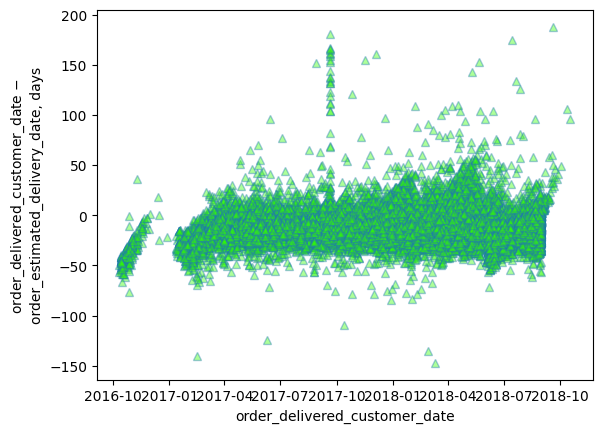

In [484]:
#how does shipping estimation change over time?
plt.plot(pd.to_datetime(orders_dataset['order_delivered_customer_date']), \
 (pd.to_datetime(orders_dataset['order_delivered_customer_date']) - pd.to_datetime(orders_dataset['order_estimated_delivery_date'])).dt.days,'^', markerfacecolor=(0.2, 1, 0, 0.4))
plt.xlabel(f'{orders_dataset.columns.to_list()[6]}')
plt.ylabel(f'{orders_dataset.columns.to_list()[6]} $-$ \n{orders_dataset.columns.to_list()[7]}, days')
plt.show()

Volume of deliveries was low at the start of data (e.g., ~10/2016) and close to stopped arround 01/2017; appears that the number of deliveries arriving after estimation nominally increases with time; start of data coincides with political unrest, voting

In [485]:
timestamps = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for i in timestamps:
  print(pd.to_datetime(orders_dataset[i]).agg(['min','max']))

min   2016-09-04 21:15:19
max   2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: datetime64[ns]
min   2016-09-15 12:16:38
max   2018-09-03 17:40:06
Name: order_approved_at, dtype: datetime64[ns]
min   2016-10-08 10:34:01
max   2018-09-11 19:48:28
Name: order_delivered_carrier_date, dtype: datetime64[ns]
min   2016-10-11 13:46:32
max   2018-10-17 13:22:46
Name: order_delivered_customer_date, dtype: datetime64[ns]
min   2016-09-30
max   2018-11-12
Name: order_estimated_delivery_date, dtype: datetime64[ns]


Absolute start-end dates: 09/04/2016 (first purchase)-11/12/2018 (last delivery)

In [486]:
#default colors
'#1f77b4', '#ff7f0e', '#2ca02c'

('#1f77b4', '#ff7f0e', '#2ca02c')

Text(0, 0.5, 'Count')

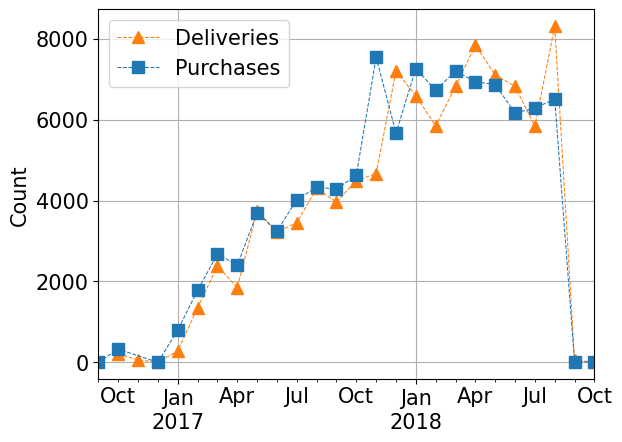

In [487]:
#how many deliveries and purchases per month?
ax = orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))['order_id'].count().plot(style='--^', color='#ff7f0e', linewidth=0.75, \
                        label = 'Deliveries', ylabel='count', fontsize=15, markersize=9)
orders_dataset.groupby(pd.to_datetime(orders_dataset['order_purchase_timestamp']).dt.to_period('M'))['order_id'].count().plot(ax=ax, style='--s', color='#1f77b4', \
                        linewidth=0.75, label = 'Purchases', markersize=9)
plt.legend(fontsize = 15)
plt.grid(True)
ax.set(xlabel=None)
ax.set_ylabel('Count', fontsize=15)
#plt.axis('off')

It appears that there is start-up period in purchase growth from early 2017 until Nov. 2017 when purchases reached a steady-state before abrupt stop Oct. 2018. This time coincides with the presidential elections in Brazil and similarly for deliveries.

'#1f77b4', '#ff7f0e', '#2ca02c'

[Text(0.5, 0, '')]

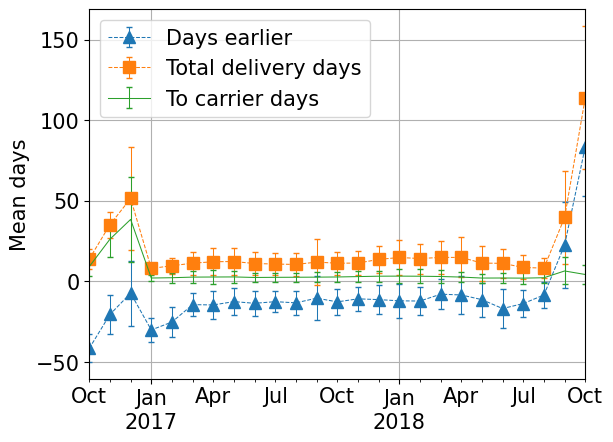

In [488]:
#on average how much earlier than promised were orders delivered over time
orders_dataset['early'] = (pd.to_datetime(orders_dataset['order_delivered_customer_date']) - pd.to_datetime(orders_dataset['order_estimated_delivery_date'])).dt.days
orders_dataset['total'] = (pd.to_datetime(orders_dataset['order_delivered_customer_date']) - pd.to_datetime(orders_dataset['order_purchase_timestamp'])).dt.days
orders_dataset['carrier'] = (pd.to_datetime(orders_dataset['order_delivered_carrier_date']) - pd.to_datetime(orders_dataset['order_purchase_timestamp'])).dt.days

err_erl=orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['early'].describe()['std']
err_tot=orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['total'].describe()['std']
err_car=orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['carrier'].describe()['std']

ax = orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['early'].mean().plot(yerr=err_erl, fmt='--^', color='#1f77b4', capsize=2, linewidth=0.75, label = 'Days earlier', ylabel='Mean days', fontsize=15, markersize=9)

orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['total'].mean().plot(yerr=err_tot, fmt='--s', color='#ff7f0e', capsize=2, linewidth=0.75, label = 'Total delivery days', markersize=9)

orders_dataset.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['carrier'].mean().plot(yerr=err_car, fmt='-', color='#2ca02c', capsize=2, linewidth=0.75, label = 'To carrier days', markersize=9)

ax.set_ylabel('Mean days', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
ax.set(xlabel=None)

Possibly meaningful to only look at data in steady-state reagion (e.g., 3/2017 - 7/2018) for 'review_score' Moreover, outside error, appears that on average the delivery days are due to the carrier not the sellers dropping off their orders at the carrier to be shipped. And orders are on average delivered on time month to month with the exceptions of the start and end of the data

[Text(0.5, 0, '')]

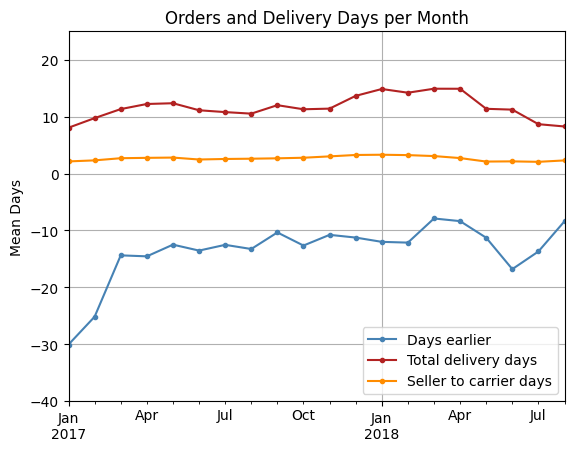

In [489]:
import matplotlib.dates as mdates
#on average how much earlier than promised were orders delivered over time
start_date = '2017-01-01'
end_date = '2018-09-01'
orders_dataset_trim = orders_dataset[(orders_dataset['order_delivered_customer_date'] >= start_date) & (orders_dataset['order_delivered_customer_date'] <= end_date)].copy()

orders_dataset_trim['early'] = (pd.to_datetime(orders_dataset_trim['order_delivered_customer_date']) - pd.to_datetime(orders_dataset_trim['order_estimated_delivery_date'])).dt.days
orders_dataset_trim['total'] = (pd.to_datetime(orders_dataset_trim['order_delivered_customer_date']) - pd.to_datetime(orders_dataset_trim['order_purchase_timestamp'])).dt.days
orders_dataset_trim['carrier'] = (pd.to_datetime(orders_dataset_trim['order_delivered_carrier_date']) - pd.to_datetime(orders_dataset_trim['order_purchase_timestamp'])).dt.days

ax = orders_dataset.groupby(pd.to_datetime(orders_dataset_trim['order_delivered_customer_date']).dt.to_period('M'))\
 ['early'].mean().plot(style='.-', color='steelblue', label = 'Days earlier')

orders_dataset.groupby(pd.to_datetime(orders_dataset_trim['order_delivered_customer_date']).dt.to_period('M'))\
 ['total'].mean().plot(style='.-', color='firebrick', label = 'Total delivery days')

orders_dataset.groupby(pd.to_datetime(orders_dataset_trim['order_delivered_customer_date']).dt.to_period('M'))\
 ['carrier'].mean().plot(style='.-', color='darkorange', label = 'Seller to carrier days')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
#plt.xticks(mdates.MonthLocator())
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 2)))
plt.ylabel('Mean Days')
#plt.xlabel('Date')
plt.title('Orders and Delivery Days per Month')
#plt.axis(mdates.MonthLocator(bymonth=(1, 4)))
#plt.xticks([2017-4, 2017-7, 2017-10, 2018-4])
plt.grid(True)
plt.legend()
plt.ylim(-40,25)
#ax.xaxis.grid(True, which='both')
ax.set(xlabel=None)

In [490]:
#order status types?
orders_dataset['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Of 99441 unique orders it may be only relevant to work with 'delivered' (e.g., 96478)

'order_id' common to orders_dataset, orders_reviews_dataset, order_payments_dataset, order_items_dataset

In [491]:
print(products_dataset.shape)
print(products_dataset.columns)
print(products_dataset.dtypes)
products_dataset.head()

(32951, 9)
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object


product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [492]:
#how is the weight of the products distributed?
prod_view = products_dataset.groupby('product_category_name')['product_weight_g'].agg(['mean', 'median', 'min', 'max','count']).reset_index()
prod_view

product_category_name         mean  median    min      max  count
0   agro_industria_e_comercio  5263.405405  2681.5   50.0  30000.0     74
1                   alimentos   923.414634   541.5   75.0   8238.0     82
2           alimentos_bebidas  1307.932692   600.0   50.0  10800.0    104
3                       artes  1691.763636   700.0  100.0  15400.0     55
4          artes_e_artesanato  1164.578947   500.0  100.0   6850.0     19
..                        ...          ...     ...    ...      ...    ...
68    sinalizacao_e_seguranca  2969.817204   575.0  100.0  27100.0     93
69   tablets_impressao_imagem   381.444444   300.0  100.0   1100.0      9
70                  telefonia   236.506173   200.0   50.0   8100.0   1134
71             telefonia_fixa   660.827586   414.5   50.0   6050.0    116
72      utilidades_domesticas  3020.793576  1050.0   50.0  30000.0   2335

[73 rows x 6 columns]

Attempt to use 'business_segment' to distribute product categories and see corresponding distribution of product weights. See below for more explanation and box plots of the same information.

<Axes: ylabel='business_segment'>

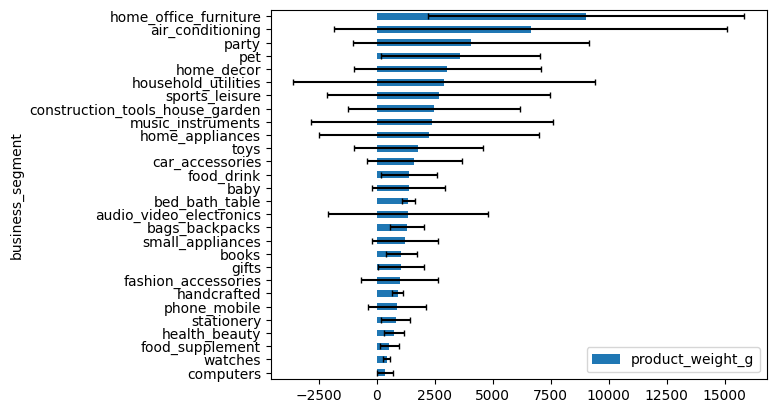

In [493]:
#sorted
errd=merged.groupby(['business_segment','product_category_name_english'])['product_weight_g'].mean().reset_index()
merged.groupby(['business_segment','product_category_name_english'])['product_weight_g'].mean().groupby('business_segment').mean().sort_values()\
.plot(kind = 'barh',\
      xerr=[errd.groupby('business_segment')['product_weight_g'].describe().sort_values(by='mean')['std']], capsize=2, legend=True, rot='horizontal')

In [494]:
err_prod=products_dataset.groupby('product_category_name')['product_weight_g'].describe().sort_values(by='mean')['std']

In [495]:
err_prod

product_category_name
telefonia                                           335.883175
fashion_roupa_infanto_juvenil                       223.338308
fashion_esporte                                     329.938857
fashion_underwear_e_moda_praia                      311.271533
tablets_impressao_imagem                            303.745416
                                                      ...     
eletrodomesticos_2                                 7355.328045
moveis_quarto                                      6278.091918
moveis_cozinha_area_de_servico_jantar_e_jardim     8925.999669
moveis_escritorio                                  6106.700414
moveis_colchao_e_estofado                         12336.391513
Name: std, Length: 73, dtype: float64

<Axes: ylabel='product_category_name'>

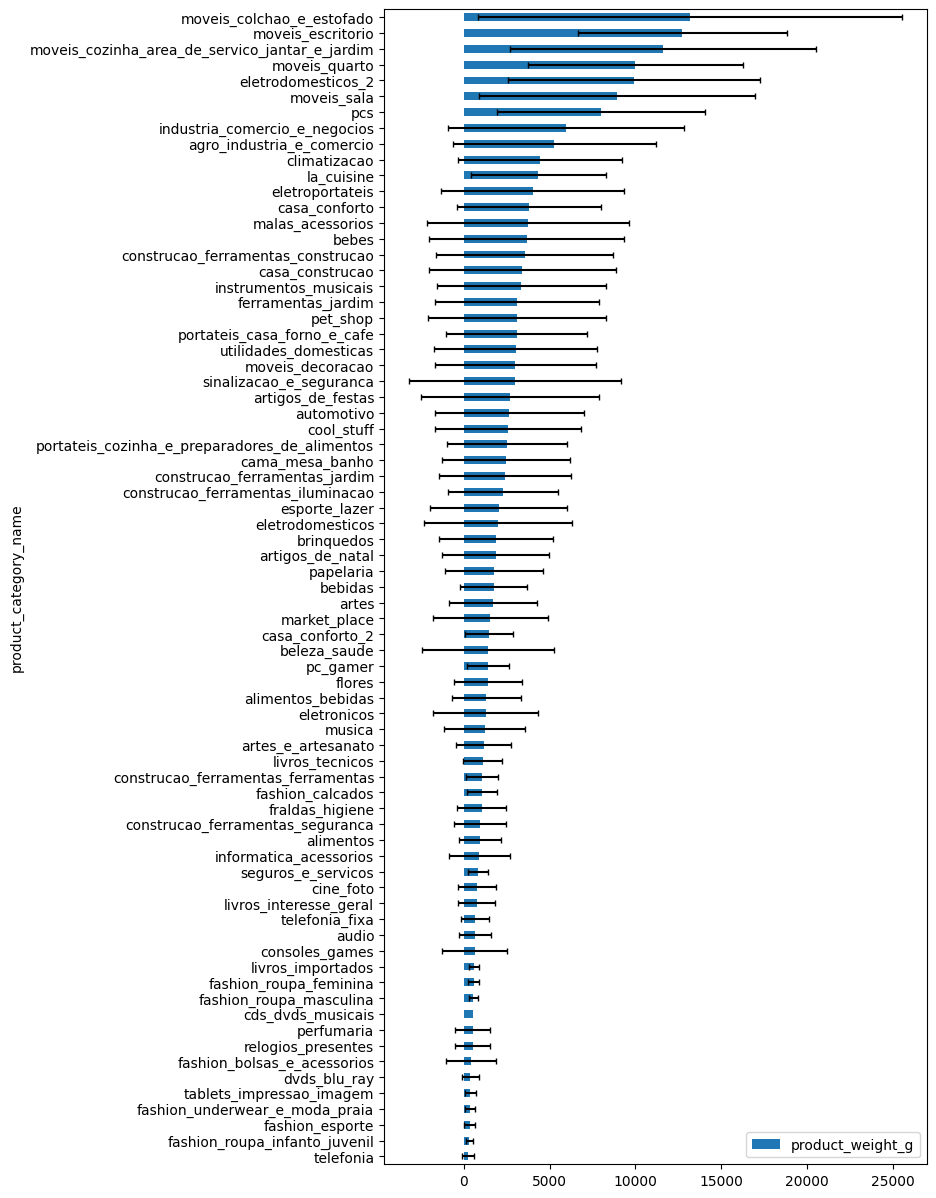

In [496]:
#visualization of mean weight per category descending plus standard deviation error bars
products_dataset.groupby('product_category_name')['product_weight_g'].mean().sort_values().plot(kind = 'barh',\
      xerr=err_prod, capsize=2, legend=True, rot='horizontal', figsize = (7,15))

'product_id' common to products_dataset, order_items_dataset

In [497]:
print(order_items_dataset.shape)
print(order_items_dataset.columns)
print(order_items_dataset.dtypes)
order_items_dataset.head()

(112650, 7)
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [498]:
order_items_dataset['order_id'].nunique()

98666

In [499]:
#orders per seller
order_items_dataset.groupby('seller_id')['order_id'].nunique().sort_values().describe()

count    3095.000000
mean       32.313409
std       105.139763
min         1.000000
25%         2.000000
50%         6.000000
75%        21.500000
max      1854.000000
Name: order_id, dtype: float64

In [500]:
#total sales per seller
sell_df = order_items_dataset.groupby('seller_id')[['price','freight_value']].apply(lambda x: (x['freight_value'] + x['price']).sum())
sell_df.describe()

count      3095.000000
mean       5119.080207
std       15922.192727
min          12.220000
25%         269.735000
50%         996.840000
75%        3964.530000
max      249640.700000
dtype: float64

In [501]:
#top sales seller
order_items_dataset[order_items_dataset['seller_id']=='4869f7a5dfa277a7dca6462dcf3b52b2']

order_id  order_item_id  \
108     003d804eef0e1b856881cd18e0cc0d4c              1   
384     00f1bb0af030935db1745ee28367ea26              1   
450     010f223ddbec749e95ef3f5414f9c4ee              1   
542     013d92e415d1de7bf3b3b706f1b6d292              1   
625     01721e0729fcb75ab238248fdbb48eeb              1   
...                                  ...            ...   
111891  fe349b1979d7bcce7bce8df71ca6a902              1   
111981  fe627312004674a9606716ab2feada47              1   
112107  feb21ca266014309faca2e2621a1c1e7              1   
112289  ff18b518679a92dcb00e16fae93c6d59              1   
112607  ffe73fc1d73e03fdb50e63903ddfe882              1   

                              product_id                         seller_id  \
108     41402af2a88247152583bb812ba235dd  4869f7a5dfa277a7dca6462dcf3b52b2   
384     677d8ace413e0060fa8686cde56eaf10  4869f7a5dfa277a7dca6462dcf3b52b2   
450     24e8c79f39c68fbdbd57a5813ae72b94  4869f7a5dfa277a7dca6462dcf3b52b2   
542     8317b177579dd27ff068b83205e2169b  4869f7a5dfa277a7dca6462dcf3b52b2   
625     7a10781637204d8d10485c71a6108a2e  4869f7a5dfa277a7dca6462dcf3b52b2   
...                                  ...                               ...   
111891  7a10781637204d8d10485c71a6108a2e  4869f7a5dfa277a7dca6462dcf3b52b2   
111981  bc4c74766d34e4f4f9b803e75d1e689d  4869f7a5dfa277a7dca6462dcf3b52b2   
112107  8317b177579dd27ff068b83205e2169b  4869f7a5dfa277a7dca6462dcf3b52b2   
112289  461f43be3bdf8844e65b62d9ac2c7a5a  4869f7a5dfa277a7dca6462dcf3b52b2   
112607  53b36df67ebb7c41585e8d54d6772e08  4869f7a5dfa277a7dca6462dcf3b52b2   

        shipping_limit_date  price  freight_value  
108     2017-11-27 12:15:18  277.0          35.74  
384     2018-08-08 23:31:34  268.9          19.98  
450     2018-06-13 20:31:51   79.0          18.43  
542     2018-02-01 14:22:15  188.0          16.07  
625     2018-03-23 13:49:35  219.0          24.11  
...                     ...    ...            ...  
111891  2018-03-01 12:09:30  204.0          20.67  
111981  2018-07-25 04:05:13  105.9          18.84  
112107  2018-03-27 20:47:55  175.9          13.67  
112289  2017-11-07 16:31:14  146.0          26.30  
112607  2018-04-23 13:15:15  112.9           0.00  

[1156 rows x 7 columns]

In [502]:
#total sales for specific seller
order_items_dataset[order_items_dataset['seller_id']=='ffdd9f82b9a447f6f8d4b91554cc7dd3'].groupby('order_id')[['price','freight_value']].apply(lambda x: (x['freight_value'] + x['price']).sum()).sum()

2828.6599999999994

<Axes: xlabel='order_item_id'>

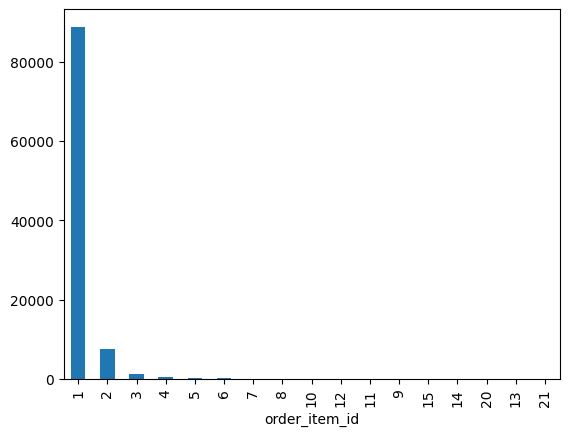

In [503]:
#how many orders with more than 1 item
order_items_dataset.groupby('order_id')['order_item_id'].count().value_counts().plot(kind='bar')

Of the 98666 orders, 88863 have more than 1 item ~ 10% of total orders

In [504]:
#'price' statistics per order
order_items_dataset.groupby('order_id')['price'].sum().agg(['mean', 'median', 'min', 'max','count']).reset_index()

index         price
0    mean    137.754076
1  median     86.900000
2     min      0.850000
3     max  13440.000000
4   count  98666.000000

In [505]:
order_items_dataset.groupby('order_id')['price'].sum().describe()

count    98666.000000
mean       137.754076
std        210.645145
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: price, dtype: float64

In [506]:
#order_items_dataset.groupby('order_id')['price'].sum().plot(kind='kde')

In [507]:
order_items_dataset.groupby('order_id')['freight_value'].sum().describe()

count    98666.000000
mean        22.823562
std         21.650909
min          0.000000
25%         13.850000
50%         17.170000
75%         24.040000
max       1794.960000
Name: freight_value, dtype: float64

In [508]:
order_items_dataset.groupby('order_id')['freight_value'].sum().agg(['mean', 'median', 'min', 'max','count']).reset_index()

index  freight_value
0    mean      22.823562
1  median      17.170000
2     min       0.000000
3     max    1794.960000
4   count   98666.000000

<Axes: xlabel='freight_value/price', ylabel='count'>

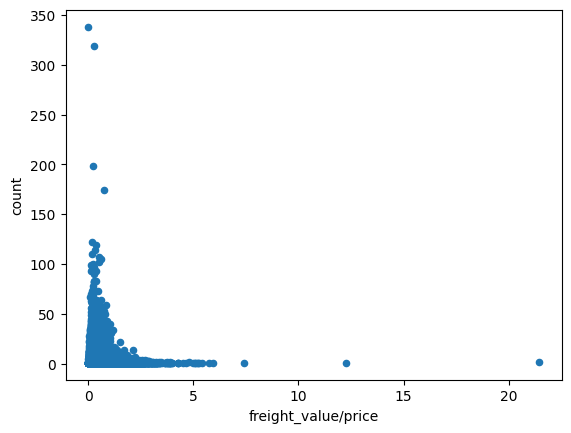

In [509]:
(order_items_dataset.groupby('order_id')['freight_value'].sum()/order_items_dataset.groupby('order_id')['price']\
 .sum()).value_counts().reset_index().plot(x='index', y='count', kind='scatter', xlabel='freight_value/price')

In [510]:
#'freight_value'/'price' ratio
df = order_items_dataset.groupby('order_id')[['freight_value', 'price']].apply(lambda x: x['freight_value'].sum() / x['price'].sum()).reset_index()

In [511]:
df[0].describe()

count    98666.000000
mean         0.308389
std          0.314762
min          0.000000
25%          0.131864
50%          0.224374
75%          0.380191
max         21.447059
Name: 0, dtype: float64

<Axes: xlabel='0', ylabel='Density'>

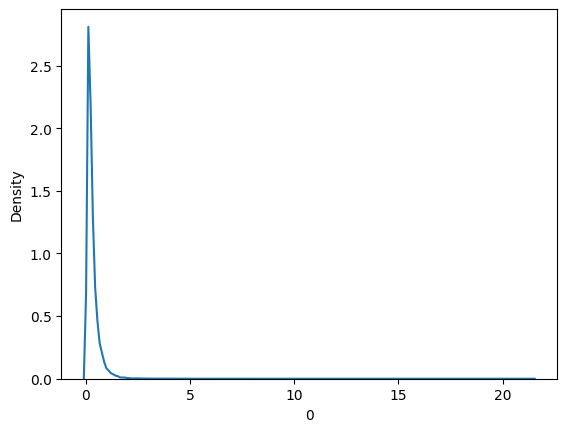

In [512]:
sns.kdeplot(data=df, x=0)

In [513]:
df[df[0]>=1].count()

order_id    3159
0           3159
dtype: int64

Of the 98666 orders, 3159 have a 'freight_value'/'price' ratio >= 1, ~3%

In [514]:
#confirm 'payment_value' = 'price' + 'freight_value'
order_items_dataset[order_items_dataset['order_id']=='1e6f350c900ca357945126e20117d293']

order_id  order_item_id  \
13398  1e6f350c900ca357945126e20117d293              1   

                             product_id                         seller_id  \
13398  372645c7439f9661fbbacfd129aa92ec  da8622b14eb17ae2831f4ac5b9dab84a   

       shipping_limit_date  price  freight_value  
13398  2017-09-14 20:30:15  119.9          18.09

In [515]:
print(order_payments_dataset.shape)
print(order_payments_dataset.columns)
print(order_payments_dataset.dtypes)
order_payments_dataset.head()

(103886, 5)
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [516]:
order_payments_dataset['order_id'].nunique()

99440

In [517]:
order_payments_dataset.groupby('order_id')['payment_sequential'].count().value_counts()

payment_sequential
1     96479
2      2382
3       301
4       108
5        52
6        36
7        28
8        11
9         9
11        8
12        8
10        5
13        3
15        2
14        2
19        2
22        1
21        1
26        1
29        1
Name: count, dtype: int64

Of the 99440 orders, 96479 have just one payment type, ~3% have more than 1

In [518]:
#pick an order w/more than 1 payments
pay_view = order_payments_dataset.groupby('order_id')['payment_sequential'].count().reset_index()
pay_view[pay_view['payment_sequential']==10]

order_id  payment_sequential
11816  1e6f350c900ca357945126e20117d293                  10
21050  364f451ee38a4268d7c15d317021eb35                  10
28374  48f2d0b950703bfb145b7c3c0641b4bb                  10
79536  ccc1762fa4bea334f80983e3f3a933b6                  10
96572  f8a8d05d951ce7e359dfd0c67f1de017                  10

In [519]:
#confirm that total payment = sum of 'payment_value' for orders with more than 1 payment --> 'price' + 'freight_value' from order_items_dataset
order_payments_dataset[order_payments_dataset['order_id']=='1e6f350c900ca357945126e20117d293']['payment_value'].sum()

137.99

In [520]:
order_payments_dataset.groupby('order_id')['payment_value'].sum().agg(['mean', 'median', 'min', 'max','count'])

mean        160.990267
median      105.290000
min           0.000000
max       13664.080000
count     99440.000000
Name: payment_value, dtype: float64

In [521]:
order_payments_dataset.groupby('order_id')['payment_value'].sum().describe()

count    99440.000000
mean       160.990267
std        221.951257
min          0.000000
25%         62.010000
50%        105.290000
75%        176.970000
max      13664.080000
Name: payment_value, dtype: float64

<Axes: xlabel='payment_value, R$', ylabel='count'>

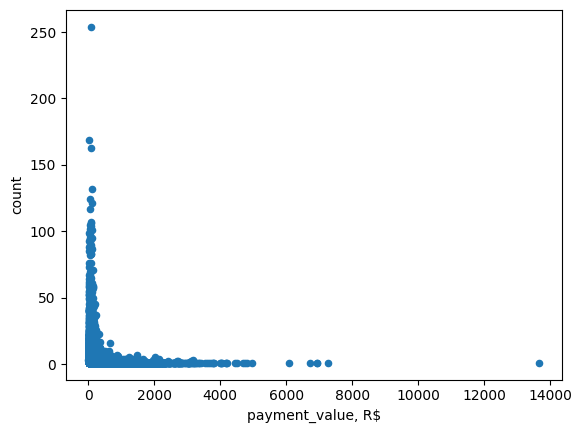

In [522]:
order_payments_dataset.groupby('order_id')['payment_value'].sum().value_counts().reset_index().plot(x='payment_value', y='count', kind='scatter', xlabel='payment_value, R$')

In [523]:
pay_view2 = order_payments_dataset.groupby('order_id')['payment_value'].sum().value_counts().reset_index()
pay_view2[pay_view2['payment_value']>200]['count'].sum()

20279

Of the 99440 orders, 20279 orders are priced higher than R$200, ~20%

In [524]:
print(order_reviews_dataset.shape)
print(order_reviews_dataset.columns)
print(order_reviews_dataset.dtypes)
order_reviews_dataset.head()

(99224, 7)
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                 None   
1             5                 None   
2             5                 None   
3             5                 None   
4             5                 None   

                              review_comment_message review_creation_date  \
0                                               None  2018-01-18 00:00:00   
1                                               None  2018-03-10 00:00:00   
2                                               None  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [525]:
order_reviews_dataset[['order_id','review_id']].nunique()

order_id     98673
review_id    98410
dtype: int64

In [526]:
order_reviews_dataset.groupby(pd.to_datetime(order_reviews_dataset['review_answer_timestamp']).dt.to_period('M'))['review_score'].value_counts().reset_index()

review_answer_timestamp  review_score  count
0                   2016-10             5     95
1                   2016-10             4     24
2                   2016-10             1     18
3                   2016-10             3     11
4                   2016-10             2      3
..                      ...           ...    ...
119                 2018-10             5     22
120                 2018-10             1      7
121                 2018-10             4      5
122                 2018-10             2      1
123                 2018-10             3      1

[124 rows x 3 columns]

In [527]:
rev_view=order_reviews_dataset.groupby(pd.to_datetime(order_reviews_dataset['review_answer_timestamp']).dt.to_period('M'))['review_score'].mean()

<Axes: xlabel='review_answer_timestamp'>

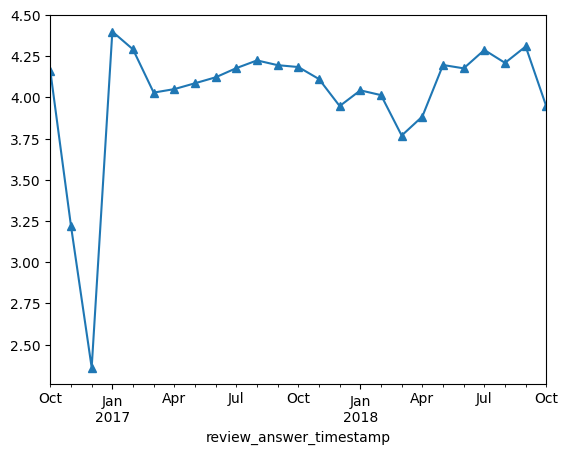

In [528]:
rev_view.plot(style='-^')

In [529]:
order_reviews_dataset['review_comment_message'].isna().value_counts()

review_comment_message
True     58274
False    40950
Name: count, dtype: int64

In [530]:
#deleting orders without comments
order_reviews_comments = order_reviews_dataset[~order_reviews_dataset['review_comment_message'].isna()].copy()

In [531]:
len(order_reviews_comments)

40950

In [532]:
#default split of 'comment_length_wrds' by space only, no other delimeters
order_reviews_comments['comment_length_wrds'] = order_reviews_comments['review_comment_message'].apply(lambda x: len(x.split()))

In [533]:
order_reviews_comments

review_id                          order_id  \
3      e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4      f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
9      8670d52e15e00043ae7de4c01cc2fe06  b9bf720beb4ab3728760088589c62129   
12     4b49719c8a200003f700d3d986ea1a19  9d6f15f95d01e79bd1349cc208361f09   
15     3948b09f7c818e2d86c9a546758b2335  e51478e7e277a83743b6f9991dbfa3fb   
...                                 ...                               ...   
99205  98fffa80dc9acbde7388bef1600f3b15  d398e9c82363c12527f71801bf0e6100   
99208  df5fae90e85354241d5d64a8955b2b09  509b86c65fe4e2ad5b96408cfef9755e   
99215  a709d176f59bc3af77f4149c96bae357  d5cb12269711bd1eaf7eed8fd32a7c95   
99221  b3de70c89b1510c4cd3d0649fd302472  55d4004744368f5571d1f590031933e4   
99223  efe49f1d6f951dd88b51e6ccd4cc548f  90531360ecb1eec2a1fbb265a0db0508   

       review_score review_comment_title  \
3                 5                 None   
4                 5                 None   
9                 4            recomendo   
12                4                 None   
15                5      Super recomendo   
...             ...                  ...   
99205             4                 None   
99208             5                 None   
99215             3                 None   
99221             5                 None   
99223             1                 None   

                                  review_comment_message review_creation_date  \
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
9      aparelho eficiente. no site a marca do aparelh...  2018-05-22 00:00:00   
12           Mas um pouco ,travando...pelo valor ta Boa.  2018-02-16 00:00:00   
15     Vendedor confiável, produto ok e entrega antes...  2018-05-23 00:00:00   
...                                                  ...                  ...   
99205  para este produto recebi de acordo com a compr...  2017-11-29 00:00:00   
99208  Entregou dentro do prazo. O produto chegou em ...  2018-02-07 00:00:00   
99215  O produto não foi enviado com NF, não existe v...  2018-05-19 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  comment_length_wrds  
3         2017-04-21 22:02:06                    6  
4         2018-03-02 10:26:53                   15  
9         2018-05-23 16:45:47                   30  
12        2018-02-20 10:52:22                    7  
15        2018-05-24 03:00:01                    9  
...                       ...                  ...  
99205     2017-11-30 15:52:51                   10  
99208     2018-02-19 19:47:23                   13  
99215     2018-05-20 21:51:06                   25  
99221     2018-03-23 09:10:43                    9  
99223     2017-07-03 21:01:49                   16  

[40950 rows x 8 columns]

In [534]:
#how many unique order_id's and review_id's are there?
order_reviews_comments[['order_id','review_id']].nunique()

order_id     40809
review_id    40641
dtype: int64

In [535]:
order_reviews_comments.groupby('review_id')['order_id'].count().value_counts()

order_id
1    40342
2      289
3       10
Name: count, dtype: int64

Appears that 40342 reviews with comments are regarding 1 order, 289 are regarding 2 orders, and 10 are regarding 3 orders

In [536]:
order_reviews_comments.groupby('order_id')['review_id'].count().value_counts()

review_id
1    40669
2      139
3        1
Name: count, dtype: int64

40669 orders have a single review, 139 have 2 reviews and 1 order has 3 reviews

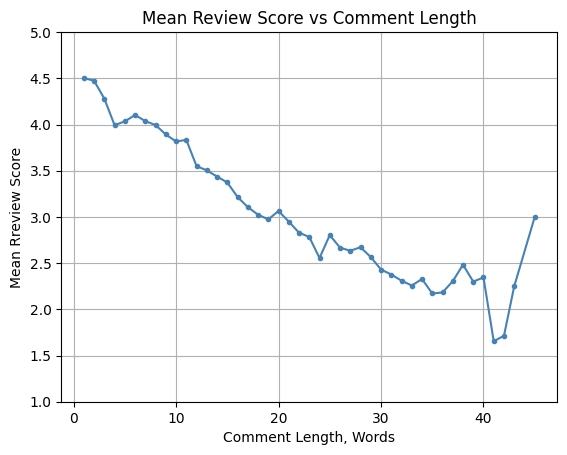

In [537]:
plt.plot(order_reviews_comments.groupby('comment_length_wrds')['review_score'].mean(), '.-', color = 'steelblue')
plt.xlabel('Comment Length, Words')
plt.ylabel('Mean Rreview Score')
plt.title('Mean Review Score vs Comment Length')
plt.ylim(1,5)
plt.grid()
plt.show()

In [538]:
x=order_reviews_comments.groupby('comment_length_wrds')['review_score'].mean().reset_index()['comment_length_wrds']
y=order_reviews_comments.groupby('comment_length_wrds')['review_score'].mean().reset_index()['review_score']

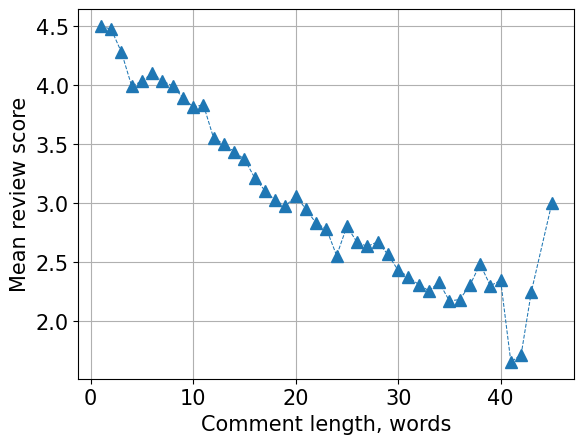

In [539]:
errb=order_reviews_comments.groupby('comment_length_wrds')['review_score'].describe()['std']

plt.plot(order_reviews_comments.groupby('comment_length_wrds')['review_score'].mean(), '^--', color = '#1f77b4', linewidth=0.75, markersize=9)
plt.xlabel('Comment length, words', fontsize=15)
plt.ylabel('Mean review score', fontsize=15)
plt.tick_params(labelsize=15)
plt.grid()
#plt.errorbar(x,y,yerr=errb, fmt='b^', capsize=2, linewidth=0.75)
plt.show()

In [540]:
order_reviews_comments.groupby('comment_length_wrds')['review_score'].describe()

count      mean       std  min  25%  50%   75%  max
comment_length_wrds                                                      
1                    2664.0  4.503003  0.913860  1.0  4.0  5.0  5.00  5.0
2                    2981.0  4.474002  1.025061  1.0  4.0  5.0  5.00  5.0
3                    2130.0  4.280282  1.220167  1.0  4.0  5.0  5.00  5.0
4                    2581.0  3.993026  1.487659  1.0  3.0  5.0  5.00  5.0
5                    2575.0  4.034175  1.462958  1.0  4.0  5.0  5.00  5.0
6                    2525.0  4.102970  1.408209  1.0  4.0  5.0  5.00  5.0
7                    2379.0  4.036570  1.447689  1.0  3.0  5.0  5.00  5.0
8                    2174.0  3.994020  1.484840  1.0  3.0  5.0  5.00  5.0
9                    1944.0  3.892490  1.564619  1.0  3.0  5.0  5.00  5.0
10                   1776.0  3.816441  1.554305  1.0  3.0  5.0  5.00  5.0
11                   1544.0  3.833549  1.574304  1.0  3.0  5.0  5.00  5.0
12                   1441.0  3.550312  1.652566  1.0  2.0  4.0  5.00  5.0
13                   1278.0  3.503130  1.650677  1.0  2.0  4.0  5.00  5.0
14                   1142.0  3.436953  1.680157  1.0  1.0  4.0  5.00  5.0
15                    982.0  3.372709  1.671122  1.0  1.0  4.0  5.00  5.0
16                    815.0  3.215951  1.709201  1.0  1.0  4.0  5.00  5.0
17                    810.0  3.106173  1.673198  1.0  1.0  3.0  5.00  5.0
18                    702.0  3.024217  1.699454  1.0  1.0  3.0  5.00  5.0
19                    638.0  2.973354  1.683117  1.0  1.0  3.0  5.00  5.0
20                    638.0  3.064263  1.699739  1.0  1.0  3.0  5.00  5.0
21                    530.0  2.949057  1.709323  1.0  1.0  3.0  5.00  5.0
22                    475.0  2.829474  1.650462  1.0  1.0  3.0  5.00  5.0
23                    469.0  2.782516  1.638099  1.0  1.0  3.0  4.00  5.0
24                    400.0  2.555000  1.580576  1.0  1.0  2.0  4.00  5.0
25                    387.0  2.803618  1.645432  1.0  1.0  3.0  4.00  5.0
26                    409.0  2.667482  1.621529  1.0  1.0  2.0  4.00  5.0
27                    393.0  2.633588  1.620371  1.0  1.0  2.0  4.00  5.0
28                    360.0  2.672222  1.665078  1.0  1.0  2.0  4.00  5.0
29                    368.0  2.565217  1.578495  1.0  1.0  2.0  4.00  5.0
30                    369.0  2.430894  1.643902  1.0  1.0  1.0  4.00  5.0
31                    430.0  2.376744  1.584428  1.0  1.0  2.0  4.00  5.0
32                    442.0  2.309955  1.544896  1.0  1.0  1.0  4.00  5.0
33                    458.0  2.257642  1.462588  1.0  1.0  2.0  3.00  5.0
34                    427.0  2.327869  1.576007  1.0  1.0  2.0  4.00  5.0
35                    402.0  2.171642  1.431004  1.0  1.0  1.0  3.00  5.0
36                    340.0  2.182353  1.419101  1.0  1.0  1.0  3.00  5.0
37                    237.0  2.303797  1.495936  1.0  1.0  2.0  4.00  5.0
38                    147.0  2.482993  1.472830  1.0  1.0  2.0  4.00  5.0
39                     90.0  2.300000  1.539371  1.0  1.0  1.0  4.00  5.0
40                     58.0  2.344828  1.504983  1.0  1.0  2.0  4.00  5.0
41                     26.0  1.653846  1.231010  1.0  1.0  1.0  1.75  5.0
42                      7.0  1.714286  0.755929  1.0  1.0  2.0  2.00  3.0
43                      4.0  2.250000  1.892969  1.0  1.0  1.5  2.75  5.0
45                      3.0  3.000000  2.000000  1.0  2.0  3.0  4.00  5.0

Mean review score almost monotonic function of 'comment length, words': the higher the score the shorter the length! Comments longer than ~35 words and score of ~2 can be found for 2 < 'mean_review_score' < 3, still considered 'unsatisfied' < 4 and very few comments that are that long

Text(0, 0.5, 'Count')

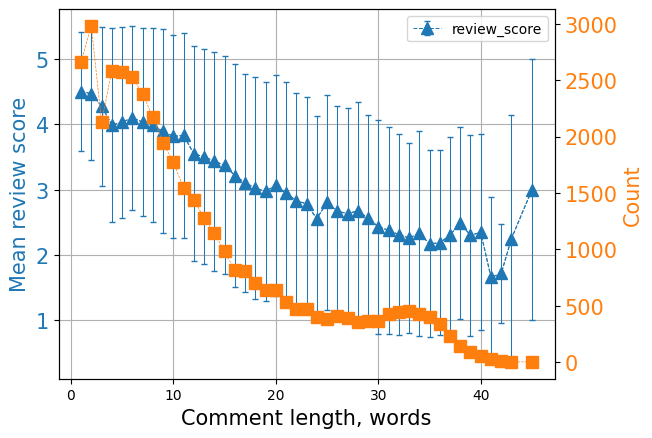

In [541]:
#'#1f77b4', '#ff7f0e', '#2ca02c'
errb=order_reviews_comments.groupby('comment_length_wrds')['review_score'].describe()['std']

fig, ax = plt.subplots()

plt.plot(order_reviews_comments.groupby('comment_length_wrds')['review_score'].mean(), '^--', linewidth=0.75)

plt.xlabel('Comment length, words', fontsize=15)
plt.ylabel('Mean review score', color = '#1f77b4', fontsize=15)
plt.errorbar(x,y,yerr=errb, fmt='^--', color='#1f77b4', capsize=2, linewidth=0.75, markersize=9, label = 'review_score')
plt.tick_params(axis ='y', labelcolor = '#1f77b4', labelsize=15)
plt.grid()
ax.legend()
#plt.ylim(0,10)

ax.twinx()
plt.plot(order_reviews_comments.groupby('comment_length_wrds')['review_score'].count(), '--s', color = '#ff7f0e', linewidth=0.5, markersize=9)
plt.tick_params(axis ='y', labelcolor = '#ff7f0e', labelsize=15)
plt.ylabel('Count', color = '#ff7f0e', fontsize=15)
#plt.ylim((0,5000))

[Text(0.5, 0, '')]

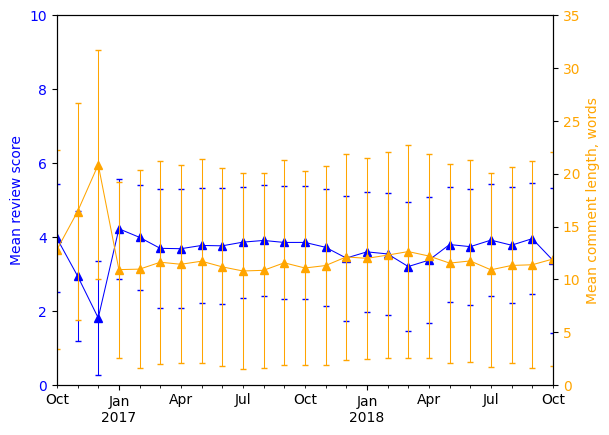

In [542]:
rev_err=order_reviews_comments.groupby(pd.to_datetime(order_reviews_comments['review_answer_timestamp']).dt.to_period('M'))['review_score'].describe()['std']
wrd_err=order_reviews_comments.groupby(pd.to_datetime(order_reviews_comments['review_answer_timestamp']).dt.to_period('M'))['comment_length_wrds'].describe()['std']

fig, ax = plt.subplots()

ax = order_reviews_comments.groupby(pd.to_datetime(order_reviews_comments['review_answer_timestamp']).dt.to_period('M'))['review_score'].mean().\
plot(yerr=rev_err, fmt='b-^', linewidth=0.75, capsize=2)
#plt.legend()
ax.set_ylabel('Mean review score', color = 'blue')
ax.tick_params(axis ='y', labelcolor = 'blue')
ax.set_ylim((0,10))

ax2 = ax.twinx()
order_reviews_comments.groupby(pd.to_datetime(order_reviews_comments['review_answer_timestamp']).dt.to_period('M'))['comment_length_wrds'].mean().\
plot(yerr=wrd_err, fmt='-^', linewidth=0.75, capsize=2, color='orange')
ax2.tick_params(axis ='y', labelcolor = 'orange')
ax2.set_ylabel('Mean comment length, words', color = 'orange')
ax2.set_ylim((0,35))

ax.set(xlabel=None)

[Text(0.5, 0, '')]

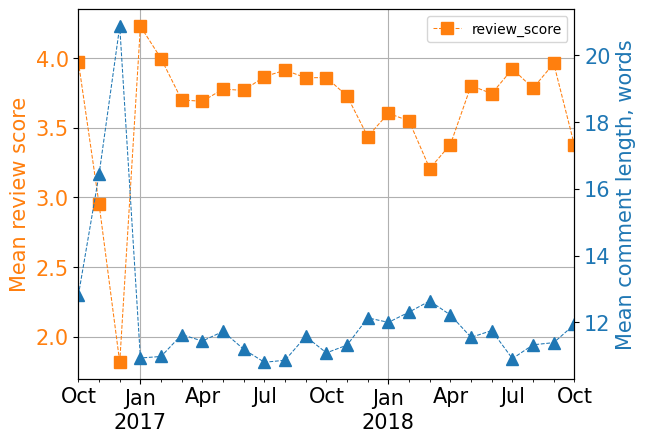

In [543]:
#'#1f77b4', '#ff7f0e', '#2ca02c'
fig, ax = plt.subplots()

ax = order_reviews_comments.groupby(pd.to_datetime(order_reviews_comments['review_answer_timestamp']).dt.to_period('M'))['review_score'].mean().\
plot(style = '--s', color='#ff7f0e', linewidth=0.75, fontsize=15, markersize=9)
#plt.legend()
ax.set_ylabel('Mean review score', color = '#ff7f0e', fontsize=15)
ax.tick_params(axis ='y', labelcolor = '#ff7f0e')
#ax.set_ylim((0,10))
ax.grid()
ax.legend()

ax2 = ax.twinx()
order_reviews_comments.groupby(pd.to_datetime(order_reviews_comments['review_answer_timestamp']).dt.to_period('M'))['comment_length_wrds'].mean().\
plot(style = '--^', linewidth=0.75, color='#1f77b4', fontsize=15, markersize=9)
ax2.tick_params(axis ='y', labelcolor = '#1f77b4')
ax2.set_ylabel('Mean comment length, words', color = '#1f77b4', fontsize=15)
#ax2.set_ylim((0,35))
#ax2.legend(loc='center right')

ax.set(xlabel=None)

In [544]:
#tabulate the frequency of all words used by reviewers?
#order_reviews_comments['review_comment_message'].apply(lambda x: x.lower().split()).value_counts().head()

In [545]:
#from collections import Counter

#Counter(" ".join(df_merged['review_comment_message']).split()).most_common(100)

In [546]:
print(product_category_name_translation.shape)
print(product_category_name_translation.columns)
print(product_category_name_translation.dtypes)
product_category_name_translation.head()

(71, 2)
Index(['product_category_name', 'product_category_name_english'], dtype='object')
product_category_name            object
product_category_name_english    object
dtype: object


product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

Only 71 product categories compared to 73 in products_dataset

In [547]:
print(maketing_qualified_leads_dataset.shape)
print(maketing_qualified_leads_dataset.columns)
print(maketing_qualified_leads_dataset.dtypes)
maketing_qualified_leads_dataset.head()

(8000, 4)
Index(['mql_id', 'first_contact_date', 'landing_page_id', 'origin'], dtype='object')
mql_id                object
first_contact_date    object
landing_page_id       object
origin                object
dtype: object


mql_id first_contact_date  \
0  dac32acd4db4c29c230538b72f8dd87d         2018-02-01   
1  8c18d1de7f67e60dbd64e3c07d7e9d5d         2017-10-20   
2  b4bc852d233dfefc5131f593b538befa         2018-03-22   
3  6be030b81c75970747525b843c1ef4f8         2018-01-22   
4  5420aad7fec3549a85876ba1c529bd84         2018-02-21   

                    landing_page_id          origin  
0  88740e65d5d6b056e0cda098e1ea6313          social  
1  007f9098284a86ee80ddeb25d53e0af8     paid_search  
2  a7982125ff7aa3b2054c6e44f9d28522  organic_search  
3  d45d558f0daeecf3cccdffe3c59684aa           email  
4  b48ec5f3b04e9068441002a19df93c6c  organic_search

In [548]:
print(geolocation_dataset.shape)
print(geolocation_dataset.columns)
print(geolocation_dataset.dtypes)
geolocation_dataset.head()

(1000163, 5)
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [549]:
geolocation_dataset[['geolocation_lat','geolocation_lng','geolocation_zip_code_prefix']].nunique()

geolocation_lat                717363
geolocation_lng                717615
geolocation_zip_code_prefix     19015
dtype: int64

In [550]:
#Averaging coordinates for each unique 'geolocation_zip_code_prefix' (e.g., 19015)  and creating new dataframe
geom = geolocation_dataset.groupby('geolocation_zip_code_prefix')[['geolocation_lat','geolocation_lng']].mean().reset_index()
geom.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.550190       -46.634024
1                         1002       -23.548146       -46.634979
2                         1003       -23.548994       -46.635731
3                         1004       -23.549799       -46.634757
4                         1005       -23.549456       -46.636733

In [551]:
#geom.dtypes

In [552]:
print(closed_deals_dataset.shape)
print(closed_deals_dataset.columns)
print(closed_deals_dataset.dtypes)
closed_deals_dataset.head()

(842, 14)
Index(['mql_id', 'seller_id', 'sdr_id', 'sr_id', 'won_date',
       'business_segment', 'lead_type', 'lead_behaviour_profile',
       'has_company', 'has_gtin', 'average_stock', 'business_type',
       'declared_product_catalog_size', 'declared_monthly_revenue'],
      dtype='object')
mql_id                            object
seller_id                         object
sdr_id                            object
sr_id                             object
won_date                          object
business_segment                  object
lead_type                         object
lead_behaviour_profile            object
has_company                       object
has_gtin                          object
average_stock                     object
business_type                     object
declared_product_catalog_size     object
declared_monthly_revenue         float64
dtype: object


mql_id                         seller_id  \
0  5420aad7fec3549a85876ba1c529bd84  2c43fb513632d29b3b58df74816f1b06   
1  a555fb36b9368110ede0f043dfc3b9a0  bbb7d7893a450660432ea6652310ebb7   
2  327174d3648a2d047e8940d7d15204ca  612170e34b97004b3ba37eae81836b4c   
3  f5fee8f7da74f4887f5bcae2bafb6dd6  21e1781e36faf92725dde4730a88ca0f   
4  ffe640179b554e295c167a2f6be528e0  ed8cb7b190ceb6067227478e48cf8dde   

                             sdr_id                             sr_id  \
0  a8387c01a09e99ce014107505b92388c  4ef15afb4b2723d8f3d81e51ec7afefe   
1  09285259593c61296eef10c734121d5b  d3d1e91a157ea7f90548eef82f1955e3   
2  b90f87164b5f8c2cfa5c8572834dbe3f  6565aa9ce3178a5caf6171827af3a9ba   
3  56bf83c4bb35763a51c2baab501b4c67  d3d1e91a157ea7f90548eef82f1955e3   
4  4b339f9567d060bcea4f5136b9f5949e  d3d1e91a157ea7f90548eef82f1955e3   

              won_date business_segment      lead_type lead_behaviour_profile  \
0  2018-02-26 19:58:54              pet  online_medium                    cat   
1  2018-05-08 20:17:59  car_accessories       industry                  eagle   
2  2018-06-05 17:27:23  home_appliances     online_big                    cat   
3  2018-01-17 13:51:03       food_drink   online_small                   None   
4  2018-07-03 20:17:45  home_appliances       industry                   wolf   

  has_company has_gtin average_stock business_type  \
0        None     None          None      reseller   
1        None     None          None      reseller   
2        None     None          None      reseller   
3        None     None          None      reseller   
4        None     None          None  manufacturer   

  declared_product_catalog_size  declared_monthly_revenue  
0                          None                       0.0  
1                          None                       0.0  
2                          None                       0.0  
3                          None                       0.0  
4                          None                       0.0

In [553]:
#33 business segments counted
closed_deals_dataset['business_segment'].value_counts().reset_index()

business_segment  count
0                        home_decor    105
1                     health_beauty     93
2                   car_accessories     77
3               household_utilities     71
4   construction_tools_house_garden     69
5           audio_video_electronics     64
6                         computers     34
7                               pet     30
8                   food_supplement     28
9                        food_drink     26
10                   sports_leisure     25
11                   bed_bath_table     22
12                   bags_backpacks     22
13                             toys     20
14              fashion_accessories     19
15            home_office_furniture     14
16                       stationery     13
17                     phone_mobile     13
18                 small_appliances     12
19                      handcrafted     12
20                             baby     10
21                music_instruments      9
22                            books      9
23                          jewerly      8
24                          watches      8
25                  home_appliances      7
26                            party      5
27                            gifts      5
28                            other      3
29                 air_conditioning      3
30                          perfume      2
31                   games_consoles      2
32                        religious      1

###Analysis of merged dataset

In [554]:
#merged.columns.to_list()

In [555]:
#what product categores are distributed per business segment
merged.groupby('business_segment')['product_category_name_english'].value_counts().head()

business_segment         product_category_name_english  
air_conditioning         home_appliances_2                   3
                         home_appliances                     1
                         construction_tools_construction     1
audio_video_electronics  health_beauty                      62
                         electronics                        40
Name: count, dtype: int64

Group by 'business_segment' and 'product_category_name_english' on 'product_weight_g' to assign products to a more representative category in terms of physical weight. *Note*: 'business_segment' on merging 'closed_deals_dataset' on 'seller_id'. However,
seller may have products in different segments therefore products may be
categorized incorrectly in this analysis. The goal is to see tighter distributions in the physical weight per business segment.

In [556]:
def boxplot_sorted(df, by, column, rot='vertical'):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes")

In [557]:
dfb=merged.groupby(['business_segment','product_category_name_english'])['product_weight_g'].mean().reset_index()

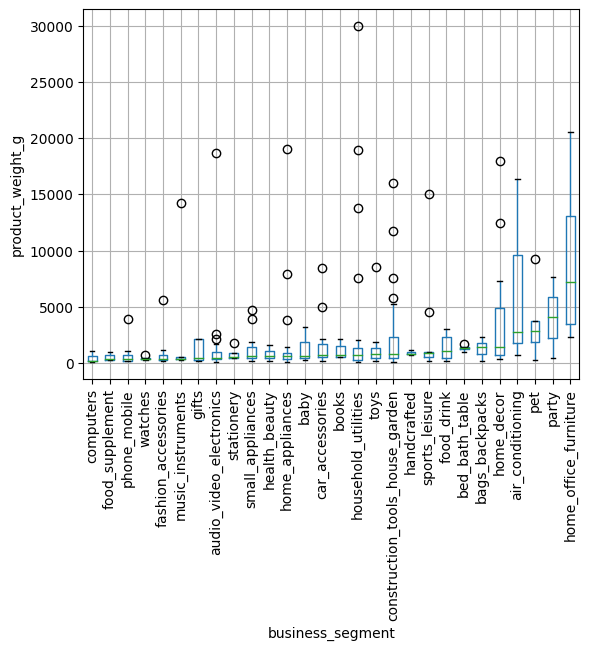

In [558]:
axes = boxplot_sorted(dfb, by = 'business_segment', column = 'product_weight_g')
plt.xlabel('business_segment')
plt.ylabel('product_weight_g')
plt.title('')
#plt.suptitle('')
plt.show()

In [559]:
#dfb = dfb.sort_values(by=['product_weight_g'],ascending=False)
#dfb.groupby('business_segment')['product_weight_g'].median().sort_values()

In [560]:
errd=merged.groupby(['business_segment','product_category_name_english'])['product_weight_g'].mean().reset_index()

In [561]:
#errd

<Axes: ylabel='business_segment'>

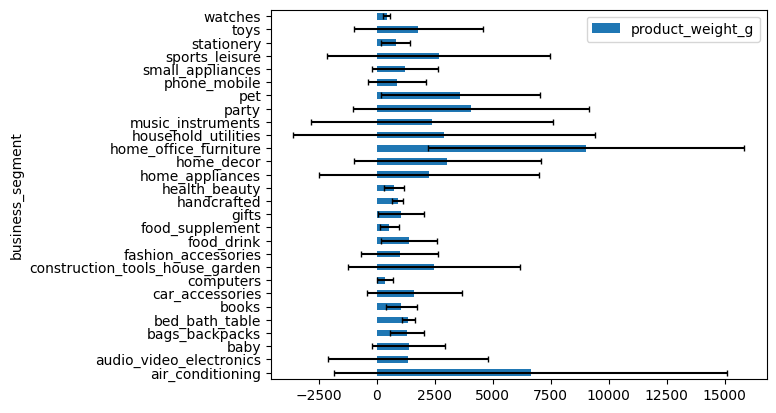

In [562]:
merged.groupby(['business_segment','product_category_name_english'])['product_weight_g'].mean().groupby('business_segment').mean()\
.plot(kind = 'barh',\
      xerr=[errd.groupby('business_segment')['product_weight_g'].std()], capsize=2, legend=True, rot='horizontal')

<Axes: ylabel='business_segment'>

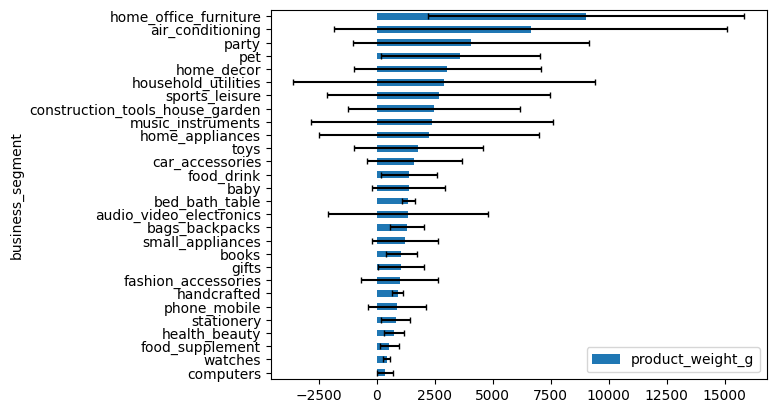

In [563]:
#sorted
merged.groupby(['business_segment','product_category_name_english'])['product_weight_g'].mean().groupby('business_segment').mean().sort_values()\
.plot(kind = 'barh',\
      xerr=[errd.groupby('business_segment')['product_weight_g'].describe().sort_values(by='mean')['std']], capsize=2, legend=True, rot='horizontal')

The categorization above by business segment is misleading as sellers may sell differet products but the closed_deals_dataset was merged on a specific deal for a specific segment therefore grouping by business segment in this way did not categorize products accordingly and there is a wide distribution of physical weights per business segment; grouping by product category results in narrower weight distributions

Does the product type matter? There are products with an average score < 4, because of shipping issues?

In [564]:
#visualization of mean review per category
#merged.groupby('product_category_name_english')['review_score'].mean().sort_values().plot(kind = 'barh', legend=True, rot='horizontal', figsize = (7,15))

In [565]:
prod_cat_view = merged.groupby('product_category_name_english')['review_score'].mean().sort_values().reset_index()
prod_cat_view[prod_cat_view['review_score']<4]

product_category_name_english  review_score
0                     security_and_services      2.500000
1                       diapers_and_hygiene      3.256410
2                          office_furniture      3.526791
3                     fashion_male_clothing      3.548611
4                            home_comfort_2      3.642857
5                           fixed_telephony      3.672862
6                    fashio_female_clothing      3.780000
7         furniture_mattress_and_upholstery      3.804878
8                                     audio      3.840849
9                         furniture_bedroom      3.841270
10                           party_supplies      3.847826
11                construction_tools_safety      3.848485
12                           bed_bath_table      3.890605
13                             home_confort      3.907563
14                          furniture_decor      3.912158
15                    furniture_living_room      3.913793
16                                      art      3.935484
17                    computers_accessories      3.936089
18                                telephony      3.948849
19                        home_construction      3.953968
20  kitchen_dining_laundry_garden_furniture      3.962963
21                         air_conditioning      3.969697
22                  fashion_underwear_beach      3.993007

In [566]:
#find unique sellers per order
merged.groupby('order_id')['seller_id'].nunique().value_counts()

seller_id
1    97387
2     1219
3       54
4        3
5        2
Name: count, dtype: int64

Of the 98665 orders, 97387 have just one seller, 1278 have more than 1

In [567]:
#eventhough an order may have more than one seller, the entire order is delivered as one
merged.groupby('order_id')['order_delivered_customer_date'].nunique().value_counts()

order_delivered_customer_date
1    96475
0     2190
Name: count, dtype: int64

2190 orders do not have a delivery date

In [568]:
merged.groupby('order_id')['order_delivered_customer_date'].nunique().sort_values()

order_id
81ad0542f902d06936247fe96fb102f8    0
c79bdf061e22288609201ec60deb42fb    0
67f98e9ec7d20b6e39c806909565213c    0
1a9eb3bcc740324dc4c07ee364ef837d    0
8abd0f2c3a61336c2ee97b2785175332    0
                                   ..
56474ed1d027aa1916357d337c62ec41    1
56472b840118d1bfb244c6cb42581ae6    1
5645645107dea4fb252b5fb68ed75db9    1
564ccac4c7cea879f88b17f29a6be374    1
fffe41c64501cc87c801fd61db3f6244    1
Name: order_delivered_customer_date, Length: 98665, dtype: int64

In [569]:
merged[merged['order_id']=='81ad0542f902d06936247fe96fb102f8']

order_id                       customer_id  \
10275  81ad0542f902d06936247fe96fb102f8  7da197a421555f9d5858c2a35ec19f2f   

      order_status order_purchase_timestamp    order_approved_at  \
10275     invoiced      2017-11-08 10:52:52  2017-11-08 11:06:41   

      order_delivered_carrier_date order_delivered_customer_date  \
10275                          NaN                           NaN   

      order_estimated_delivery_date  order_item_id  \
10275           2017-12-01 00:00:00            1.0   

                             product_id                         seller_id  \
10275  8ce450d8a20c20e17ba1536a19f60d39  54965bbe3e4f07ae045b90b0b8541f52   

       shipping_limit_date  price  freight_value  \
10275  2017-11-14 11:06:41  160.0          25.96   

                     customer_unique_id  customer_zip_code_prefix  \
10275  96bb8d8b8f62b4e39e8a95be66117941                     88868   

                     customer_city customer_state  seller_zip_code_prefix  \
10275  nossa senhora de caravaggio             SC                   85851   

         seller_city seller_state product_category_name  product_name_lenght  \
10275  foz do iguacu           PR       cama_mesa_banho                 45.0   

       product_description_lenght  product_photos_qty  product_weight_g  \
10275                       729.0                 1.0            3400.0   

       product_length_cm  product_height_cm  product_width_cm  \
10275               20.0               30.0              30.0   

      product_category_name_english  payment_sequential payment_type  \
10275                bed_bath_table                 1.0  credit_card   

       payment_installments  payment_value                         review_id  \
10275                   1.0         185.96  8a73efc0757a7f1965223f133308f45d   

       review_score review_comment_title review_comment_message  \
10275           1.0                  NaN                    NaN   

      review_creation_date review_answer_timestamp mql_id sdr_id sr_id  \
10275  2017-12-03 00:00:00     2017-12-04 10:48:06    NaN    NaN   NaN   

      won_date business_segment lead_type lead_behaviour_profile has_company  \
10275      NaN              NaN       NaN                    NaN         NaN   

      has_gtin average_stock business_type  declared_product_catalog_size  \
10275      NaN           NaN           NaN                            NaN   

       declared_monthly_revenue  seller_closed first_contact_date  \
10275                       NaN          False                NaN   

      landing_page_id origin  geolocation_zip_code_prefix_x  \
10275             NaN    NaN                          85851   

       geolocation_lat_x  geolocation_lng_x  geolocation_zip_code_prefix_y  \
10275         -25.541845          -54.58482                        88868.0   

       geolocation_lat_y  geolocation_lng_y  
10275         -25.779146         -48.260064

### Drop all orders that appear more than once for simplicity -- 'd1' dataframe

In [570]:
d1=merged.drop_duplicates(subset='order_id', keep=False).copy()
pd.set_option('display.max_columns', None)
d1.head()

order_id                       customer_id  \
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
5  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
6  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
7  a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   

  order_status order_purchase_timestamp    order_approved_at  \
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
5    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
6    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
7    delivered      2017-07-09 21:57:05  2017-07-09 22:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   
5          2017-11-22 13:39:59           2017-12-02 00:28:42   
6          2018-02-14 19:46:34           2018-02-16 18:17:02   
7          2017-07-11 14:58:04           2017-07-26 10:57:55   

  order_estimated_delivery_date  order_item_id  \
3           2018-08-13 00:00:00            1.0   
4           2018-09-04 00:00:00            1.0   
5           2017-12-15 00:00:00            1.0   
6           2018-02-26 00:00:00            1.0   
7           2017-08-01 00:00:00            1.0   

                         product_id                         seller_id  \
3  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
5  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
6  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   
7  060cb19345d90064d1015407193c233d  8581055ce74af1daba164fdbd55a40de   

   shipping_limit_date  price  freight_value  \
3  2018-07-30 03:24:27  118.7          22.76   
4  2018-08-13 08:55:23  159.9          19.22   
5  2017-11-23 19:45:59   45.0          27.20   
6  2018-02-19 20:31:37   19.9           8.72   
7  2017-07-13 22:10:13  147.9          27.36   

                 customer_unique_id  customer_zip_code_prefix  \
3  af07308b275d755c9edb36a90c618231                     47813   
4  3a653a41f6f9fc3d2a113cf8398680e8                     75265   
5  7c142cf63193a1473d2e66489a9ae977                     59296   
6  72632f0f9dd73dfee390c9b22eb56dd6                      9195   
7  80bb27c7c16e8f973207a5086ab329e2                     86320   

             customer_city customer_state  seller_zip_code_prefix  \
3                barreiras             BA                   31570   
4               vianopolis             GO                   14840   
5  sao goncalo do amarante             RN                   31842   
6              santo andre             SP                    8752   
7             congonhinhas             PR                    7112   

       seller_city seller_state product_category_name  product_name_lenght  \
3   belo horizonte           SP            perfumaria                 29.0   
4          guariba           SP            automotivo                 46.0   
5   belo horizonte           MG              pet_shop                 59.0   
6  mogi das cruzes           SP             papelaria                 38.0   
7        guarulhos           SP            automotivo                 49.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
3                       178.0                 1.0             400.0   
4                       232.0                 1.0             420.0   
5                       468.0                 3.0             450.0   
6                       316.0                 4.0             250.0   
7                       608.0                 1.0            7150.0   

   product_length_cm  product_height_cm  product_width_cm  \
3               19.0      

In [571]:
merged['order_id'].nunique()

98665

In [572]:
d1['order_id'].nunique()

85747

of the 98665 unique orders, 85747 have just one product and one payment, single-order events: dropped 12918 orders 13% of orders

###Beginning to look at date differences in units of days for 'd1' dataframe

In [573]:
%%capture
# 'order_processing_time' = 'order_purchase_timestamp' - 'order_approved_at' -- should always be positive

d1['order_processing_time'] = \
  (pd.to_datetime(d1['order_approved_at']) - \
   pd.to_datetime(d1['order_purchase_timestamp'])).dt.days

# 'order_delivery_time' = 'order_delivered_customer_date' - 'order_estimated_delivery_date' -- > 0 means delay
d1['order_delivery_time'] = \
  (pd.to_datetime(d1['order_delivered_customer_date']) - \
   pd.to_datetime(d1['order_estimated_delivery_date'])).dt.days

# 'order_carrier_delivery' = 'order_delivered_carrier_date' - 'shipping_limit_date' -- > 0 means delay
d1['order_carrier_delivery'] = \
  (pd.to_datetime(d1['order_delivered_carrier_date']) - \
   pd.to_datetime(d1['shipping_limit_date'])).dt.days

# 'order_waiting_time' = 'order_delivered_customer_date' - 'order_purchase_timestamp'
d1['order_waiting_time'] = \
  (pd.to_datetime(d1['order_delivered_customer_date']) - \
   pd.to_datetime(d1['order_purchase_timestamp'])).dt.days

# flag late orders with 1, not late or early with 0 -- binning
d1['late_orders'] = (d1['order_delivery_time'] > 0).astype(int)
d1['late_shipping'] = (d1['order_carrier_delivery'] > 0).astype(int)

In [574]:
view = d1.groupby('order_id', as_index = False)[['review_score','late_orders','late_shipping','order_delivery_time','order_processing_time','order_waiting_time','order_carrier_delivery']].mean()
view

order_id  review_score  late_orders  \
0      00010242fe8c5a6d1ba2dd792cb16214           5.0          0.0   
1      00018f77f2f0320c557190d7a144bdd3           4.0          0.0   
2      000229ec398224ef6ca0657da4fc703e           5.0          0.0   
3      00024acbcdf0a6daa1e931b038114c75           4.0          0.0   
4      00042b26cf59d7ce69dfabb4e55b4fd9           5.0          0.0   
...                                 ...           ...          ...   
85742  fffc94f6ce00a00581880bf54a75a037           5.0          0.0   
85743  fffcd46ef2263f404302a634eb57f7eb           5.0          0.0   
85744  fffce4705a9662cd70adb13d4a31832d           5.0          0.0   
85745  fffe18544ffabc95dfada21779c9644f           5.0          0.0   
85746  fffe41c64501cc87c801fd61db3f6244           5.0          0.0   

       late_shipping  order_delivery_time  order_processing_time  \
0                0.0                 -9.0                    0.0   
1                1.0                 -3.0                    0.0   
2                0.0                -14.0                    0.0   
3                0.0                 -6.0                    0.0   
4                1.0                -16.0                    0.0   
...              ...                  ...                    ...   
85742            0.0                 -8.0                    1.0   
85743            0.0                 -9.0                    2.0   
85744            0.0                -13.0                    1.0   
85745            0.0                 -9.0                    0.0   
85746            0.0                -14.0                    0.0   

       order_waiting_time  order_carrier_delivery  
0                     7.0                     0.0  
1                    16.0                     1.0  
2                     7.0                    -3.0  
3                     6.0                    -5.0  
4                    25.0                     2.0  
...                   ...                     ...  
85742                17.0                    -7.0  
85743                 9.0                    -3.0  
85744                 4.0                    -5.0  
85745                 1.0                    -6.0  
85746                 5.0                    -2.0  

[85747 rows x 8 columns]

<Axes: xlabel='order_delivery_time', ylabel='Density'>

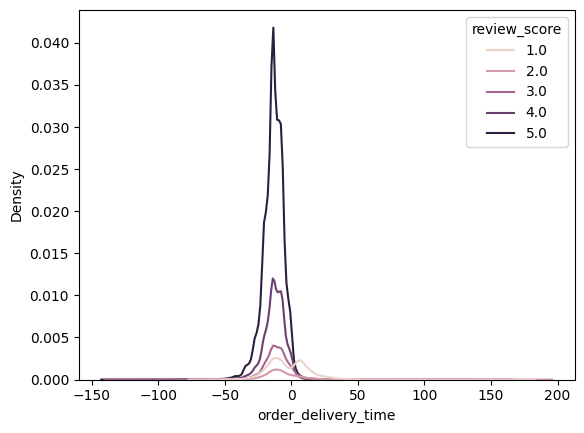

In [575]:
sns.kdeplot(data = view, x = 'order_delivery_time', hue = 'review_score')

<Axes: xlabel='order_waiting_time', ylabel='Density'>

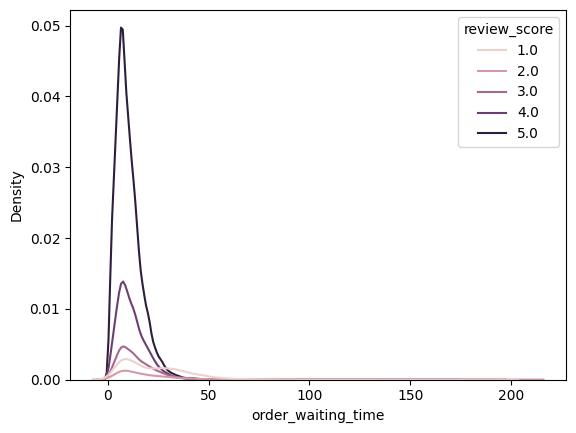

In [576]:
sns.kdeplot(data = view, x = 'order_waiting_time', hue = 'review_score')

<Axes: xlabel='late_orders', ylabel='Density'>

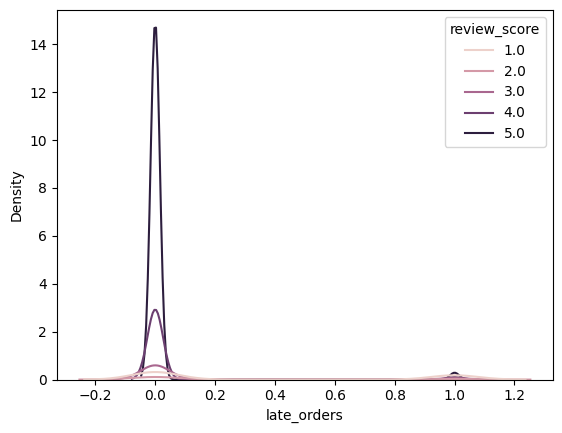

In [577]:
sns.kdeplot(data = view, x = 'late_orders', hue = 'review_score')

csat (customer satisfaction score)--only responses of 4 'satisfied' and 5 'very satisfied' are included

In [578]:
#flag reviews >= 4 with 1 and less with 0
view['satisfied'] = (view['review_score'] >= 4).astype('int')

<Axes: xlabel='late_orders', ylabel='Density'>

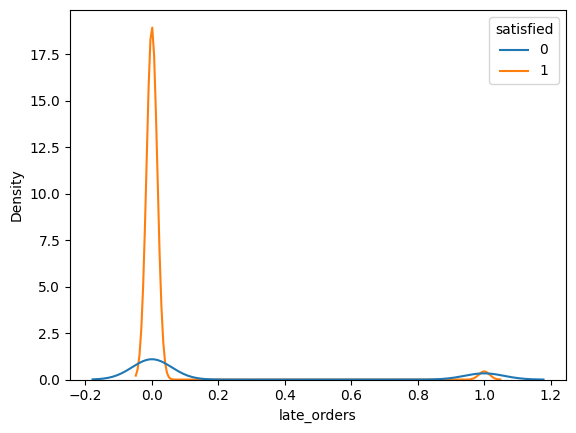

In [579]:
sns.kdeplot(data = view, x = 'late_orders', hue = 'satisfied')

In [580]:
view.groupby('satisfied')['order_delivery_time'].describe()

count       mean        std    min   25%   50%  75%    max
satisfied                                                              
0          16611.0  -6.304076  14.374825 -135.0 -15.0  -9.0  1.0  188.0
1          67190.0 -13.076410   8.322996 -140.0 -17.0 -13.0 -8.0  161.0

<Axes: xlabel='order_delivery_time', ylabel='Density'>

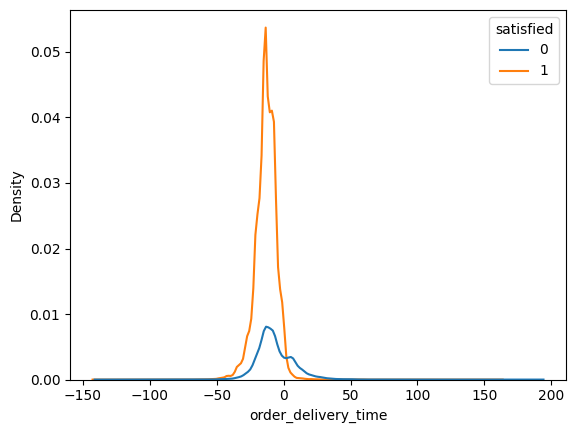

In [581]:
sns.kdeplot(data = view, x = 'order_delivery_time', hue = 'satisfied')

Although unsatisfied customers on average received their orders closer to the estimated delivery than satisfied customers, they still received them on time, suggesting something else is causing their frustration

<Axes: xlabel='order_waiting_time', ylabel='Density'>

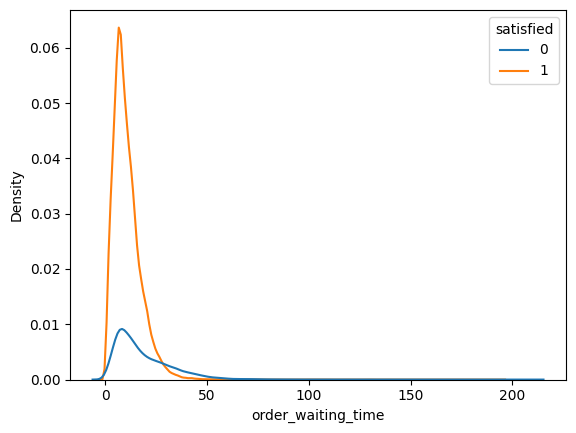

In [582]:
sns.kdeplot(data = view, x = 'order_waiting_time', hue='satisfied')

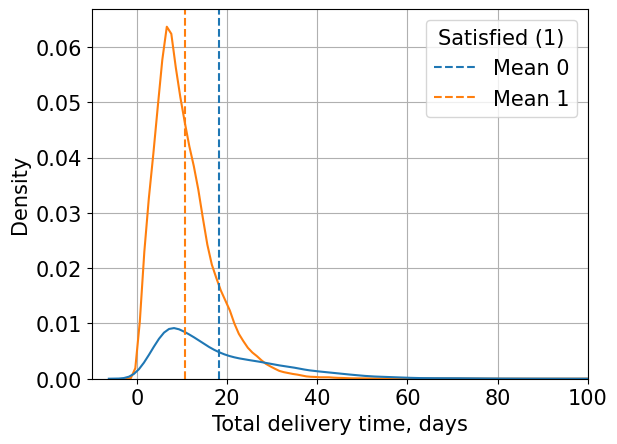

In [583]:
ax = sns.kdeplot(data = view, x = 'order_waiting_time', hue='satisfied')
ax.set_xlim(-10,100)
ax.set_xlabel(xlabel = 'Total delivery time, days', fontsize = 15)
ax.set_ylabel(ylabel = 'Density', fontsize = 15)
plt.axvline(view.groupby('satisfied')['order_waiting_time'].mean()[0], color = '#1f77b4', linestyle='--', label = 'Mean 0')
plt.axvline(view.groupby('satisfied')['order_waiting_time'].mean()[1], color='#ff7f0e', linestyle='--', label = 'Mean 1')
#plt.legend(loc='center right')
plt.tick_params(labelsize=15)
plt.grid()
ax.legend(fontsize = 15, title='Satisfied (1)', title_fontsize = 15)
#ax.legend()

In [584]:
view.groupby('satisfied')['order_waiting_time'].describe()

count       mean        std  min  25%   50%   75%    max
satisfied                                                            
0          16611.0  18.238095  14.482607  0.0  8.0  14.0  25.0  209.0
1          67190.0  10.655604   7.222052  0.0  6.0   9.0  14.0  194.0

Unsatisfied customers wait **twice** as long to receive their orders compared to happy customers.

<Axes: xlabel='late_shipping', ylabel='Density'>

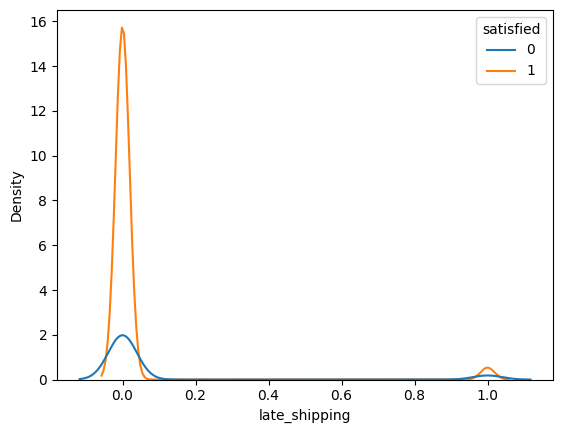

In [585]:
sns.kdeplot(data = view, x = 'late_shipping', hue = 'satisfied')

In [586]:
view.groupby('satisfied')['order_delivery_time'].agg(['min','mean','median','max'])

min       mean  median    max
satisfied                                 
0         -135.0  -6.304076    -9.0  188.0
1         -140.0 -13.076410   -13.0  161.0

In [587]:
view.groupby('satisfied')['order_waiting_time'].agg(['min','mean','median','max'])

min       mean  median    max
satisfied                               
0          0.0  18.238095    14.0  209.0
1          0.0  10.655604     9.0  194.0

In [588]:
view.groupby('satisfied')['order_carrier_delivery'].agg(['min','mean','median','max'])

min      mean  median    max
satisfied                                 
0         -1055.0 -3.150129    -3.0   95.0
1          -176.0 -4.029766    -4.0  116.0

There is an average day delay in seller dropping off order at carrier for unhappy customers

In [589]:
#view.groupby('satisfied')['order_processing_time'].value_counts()

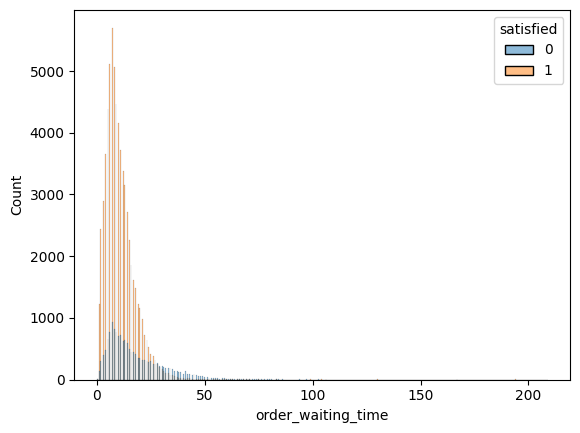

In [590]:
viewp = sns.histplot(data = view, x = 'order_waiting_time', hue = 'satisfied')
#viewp.set_xlim(0,50)

Does receiving order earlier than anticipated have an effect on the review score?

In [591]:
%%capture
# let's first transform the corresponding columns to a datetime object
# because they're strings at the moment

d1['order_delivered_customer_date'] = pd.to_datetime(d1['order_delivered_customer_date'])
d1['order_estimated_delivery_date'] = pd.to_datetime(d1['order_estimated_delivery_date'])

In [592]:
def order_id_stats2(x: pd.Series):
    """
    This function computes the total delivery time per order.
    We compute the time in days and in seconds for higher resolution
    """
    estimate_to_delivery_days = (x['order_delivered_customer_date'] - x['order_estimated_delivery_date']).dt.days.mean()
    estimate_to_delivery_seconds = (x['order_delivered_customer_date'] - x['order_estimated_delivery_date']).dt.total_seconds().mean()
    review_score = x['review_score'].mean()

    return pd.DataFrame({
            'estimate_to_delivery_seconds': [estimate_to_delivery_seconds],
            'estimate_to_delivery_days': [estimate_to_delivery_days],
            'review_score': [review_score]})

# group by order and compute the delivery statistics
order_stats2 = d1.groupby('order_id').apply(order_id_stats2)
order_stats2.index = order_stats2.index.droplevel(1)

In [593]:
review_stats2 = order_stats2.groupby('review_score')['estimate_to_delivery_days']\
                      .agg(['mean', 'median', 'min', 'max','count'])\
                      .reset_index()

In [594]:
review_stats2

review_score       mean  median    min    max  count
0           1.0  -1.993484    -5.0  -69.0  175.0   7060
1           2.0  -7.524804    -9.0  -52.0  188.0   2298
2           3.0 -10.456786   -11.0 -135.0  162.0   6734
3           4.0 -12.293360   -12.0  -75.0  161.0  16778
4           5.0 -13.337023   -13.0 -140.0  134.0  50412

Text(0.5, 0, 'Median days early delivery')

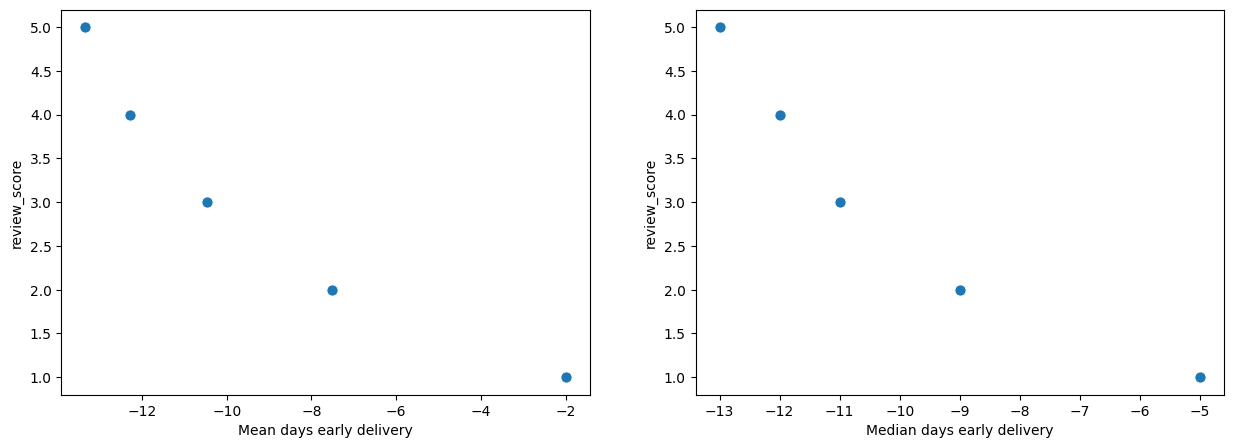

In [595]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


sns.scatterplot(data=review_stats2, x='mean', y='review_score',
                ax=axes[0], s=65)
axes[0].set_xlabel("Mean days early delivery")

sns.scatterplot(data=review_stats2, x='median', y='review_score',
                ax=axes[1], s=65)
axes[1].set_xlabel("Median days early delivery")

It appears the earlier you receive your package the better the review

###Distance between seller and customer using [Haversine](https://medium.com/@manishsingh7163/calculating-distance-between-successive-latitude-longitude-coordinates-using-pandas-287c15bc5029) formula

In [602]:
def haversine(lat1, lon1, lat2, lon2):
  """
  Calculate the great circle distance between two points on the earth (specified in decimal degrees)
  """
  # Convert latitude and longitude from degrees to radians
  lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

  # Haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a))
  r = 6371 # Radius of earth in kilometers. Use 3956 for miles
  return c * r

In [603]:
d1['Distance'] = haversine(d1['geolocation_lat_x'], d1['geolocation_lng_x'], d1['geolocation_lat_y'], d1['geolocation_lng_y'])

In [604]:
#d1['Distance'] = haversine(d1['geolocation_lat_x'].shift(), d1['geolocation_lng_x'].shift(), d1['geolocation_lat_y'].shift(), d1['geolocation_lng_y'].shift())

In [605]:
d1['Distance'].min()

0.0

In [606]:
d1

order_id                       customer_id  \
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
5       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
6       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
7       a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   
...                                  ...                               ...   
118300  880675dff2150932f1601e1c07eadeeb  47cd45a6ac7b9fb16537df2ccffeb5ac   
118301  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
118302  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
118303  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
118306  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp    order_approved_at  \
3         delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4         delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
5         delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
6         delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
7         delivered      2017-07-09 21:57:05  2017-07-09 22:10:13   
...             ...                      ...                  ...   
118300    delivered      2017-02-23 09:05:12  2017-02-23 09:15:11   
118301    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
118302    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
118303    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
118306    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
3               2018-07-26 14:31:00           2018-08-07 15:27:45   
4               2018-08-08 13:50:00           2018-08-17 18:06:29   
5               2017-11-22 13:39:59           2017-12-02 00:28:42   
6               2018-02-14 19:46:34           2018-02-16 18:17:02   
7               2017-07-11 14:58:04           2017-07-26 10:57:55   
...                             ...                           ...   
118300          2017-03-01 10:22:52           2017-03-06 11:08:08   
118301          2017-03-10 11:18:03           2017-03-17 15:08:01   
118302          2018-02-07 23:22:42           2018-02-28 17:37:56   
118303          2017-08-28 20:52:26           2017-09-21 11:24:17   
118306          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date  order_item_id  \
3                         2018-08-13            1.0   
4                         2018-09-04            1.0   
5                         2017-12-15            1.0   
6                         2018-02-26            1.0   
7                         2017-08-01            1.0   
...                              ...            ...   
118300                    2017-03-22            1.0   
118301                    2017-03-28            1.0   
118302                    2018-03-02            1.0   
118303                    2017-09-27            1.0   
118306                    2018-04-03            1.0   

                              product_id                         seller_id  \
3       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
5       d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
6       65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   
7       060cb19345d90064d1015407193c233d  8581055ce74af1daba164fdbd55a40de   
...                                  ...                               ...   
118300  ea73128566d1b082e5101ce46f8107c7  391fc6631aebcf3004804e51b40bcf1e   
118301  ac35486adb7b02598c182c2ff2e05254  e24fc9fcd865784fb25705606fe3dfe7   
118302  f1d4ce8c6dd66c47bbaa8c6781c2a923  1f9ab4708f3056ede07124aad39a2554

In [607]:
#how many orders without 'Distance'
#d1[d1['Distance'].isna()]

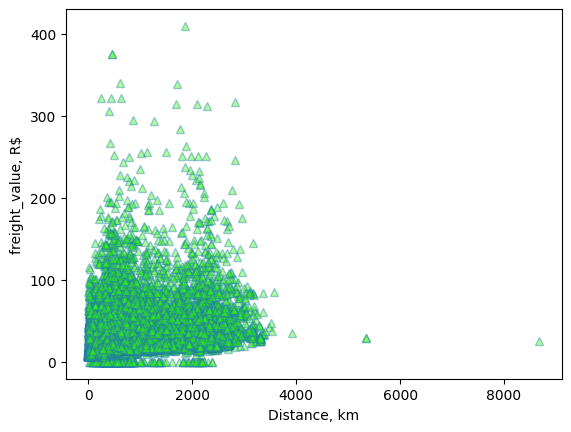

In [608]:
plt.plot(d1['Distance'], d1['freight_value'], '^', markerfacecolor=(0.2, 1, 0, 0.4))
plt.xlabel('Distance, km')
plt.ylabel('freight_value, R$')
plt.show()

In [609]:
review_dist = d1.groupby('review_score')['Distance']\
                      .agg(['mean', 'median', 'min', 'max','count'])\
                      .reset_index()

In [610]:
review_dist

review_score        mean      median       min          max  count
0           1.0  683.108468  478.519197  0.000000  5338.619521   8321
1           2.0  660.553081  464.103789  1.366758  3310.423280   2416
2           3.0  636.865341  465.240441  0.000000  3470.992801   6840
3           4.0  628.109376  460.114082  0.121756  3381.363478  16808
4           5.0  576.486447  412.881054  0.000000  8677.911622  50320

Text(0.5, 0, 'Median distance, km')

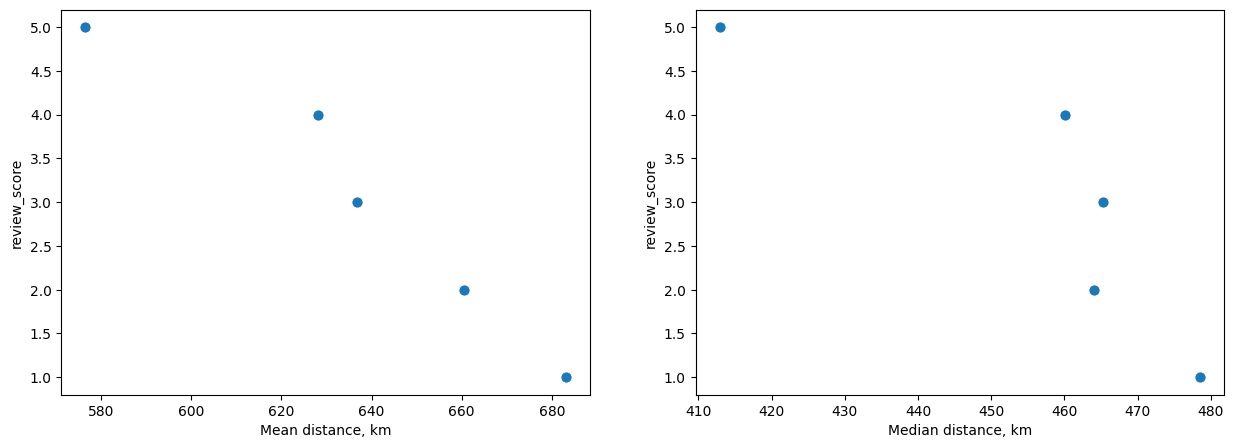

In [611]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


sns.scatterplot(data=review_dist, x='mean', y='review_score',
                ax=axes[0], s=65)
axes[0].set_xlabel("Mean distance, km")

sns.scatterplot(data=review_dist, x='median', y='review_score',
                ax=axes[1], s=65)
axes[1].set_xlabel("Median distance, km")

<Axes: xlabel='Distance', ylabel='Density'>

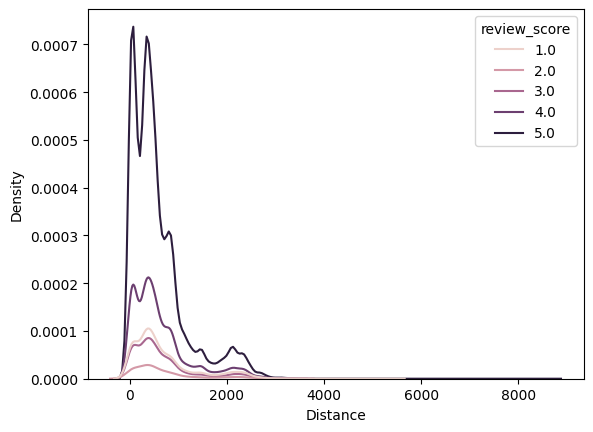

In [612]:
sns.kdeplot(data = d1, x = 'Distance', hue = 'review_score')

In [613]:
d1['satisfied'] = (d1['review_score'] >= 4).astype('int')

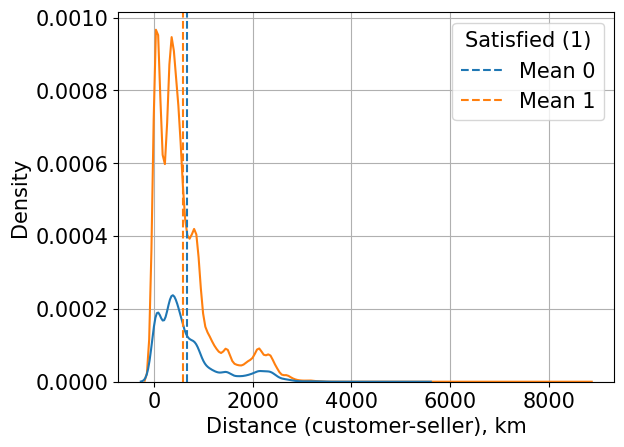

In [614]:
ax = sns.kdeplot(data = d1, x = 'Distance', hue = 'satisfied')
#ax.set_xlim(-10,100)
ax.set_xlabel(xlabel = 'Distance (customer-seller), km', fontsize = 15)
ax.set_ylabel(ylabel = 'Density', fontsize = 15)
plt.axvline(d1.groupby('satisfied')['Distance'].mean()[0], color = '#1f77b4', linestyle='--', label = 'Mean 0')
plt.axvline(d1.groupby('satisfied')['Distance'].mean()[1], color='#ff7f0e', linestyle='--', label = 'Mean 1')
plt.tick_params(labelsize=15)
plt.grid()
ax.legend(fontsize = 15, title='Satisfied (1)', title_fontsize = 15)

In [615]:
d1.groupby('satisfied')['Distance'].describe()

count        mean         std  min         25%        50%  \
satisfied                                                                
0          18189.0  661.504747  637.779716  0.0  255.089459  471.22557   
1          67128.0  589.412174  587.841888  0.0  168.160842  424.24088   

                  75%          max  
satisfied                           
0          846.654426  5338.619521  
1          787.390644  8677.911622

Unhappy customers on average 100 km further away from seller

In [616]:
d1['review_comment_message'].isna().value_counts()

review_comment_message
True     51678
False    34069
Name: count, dtype: int64

In [617]:
d1['comment_length_wrds'] = d1['review_comment_message'].apply(lambda x: len(x.split()) if pd.notna(x) else np.nan)

<Axes: xlabel='comment_length_wrds'>

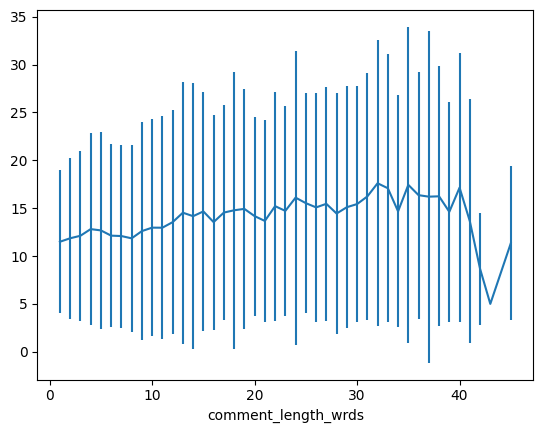

In [618]:
d1.groupby('comment_length_wrds')['order_waiting_time'].mean().plot(yerr=d1.groupby('comment_length_wrds')['order_waiting_time'].std(), style='-^')

Between 'product_name_lenght',	'product_description_lenght',	'product_photos_qty', the mean description length is slightly longer for satisfied customers, the rest don't have nominal effect

In [619]:
d1.groupby('satisfied')[['product_name_lenght', 'product_description_lenght', 'product_photos_qty']].describe()

product_name_lenght                                              \
                        count       mean       std  min   25%   50%   75%   
satisfied                                                                   
0                     17976.0  49.085559  9.930116  5.0  43.0  52.0  57.0   
1                     66534.0  48.832326  9.987633  5.0  42.0  52.0  57.0   

                product_description_lenght                                \
            max                      count        mean         std   min   
satisfied                                                                  
0          72.0                    17976.0  788.266466  649.587873  30.0   
1          76.0                    66534.0  806.410542  659.929372   4.0   

                                        product_photos_qty            \
             25%    50%     75%     max              count      mean   
satisfied                                                              
0          348.0  605.0   999.0  3992.0            17976.0  2.256397   
1          360.0  617.0  1008.0  3992.0            66534.0  2.290513   

                                               
                std  min  25%  50%  75%   max  
satisfied                                      
0          1.766120  1.0  1.0  2.0  3.0  19.0  
1          1.764107  1.0  1.0  2.0  3.0  20.0

<Axes: xlabel='product_description_lenght', ylabel='Density'>

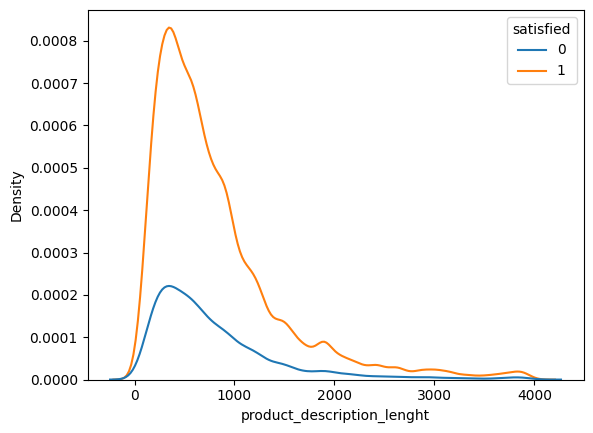

In [620]:
sns.kdeplot(data = d1, x = 'product_description_lenght', hue = 'satisfied')

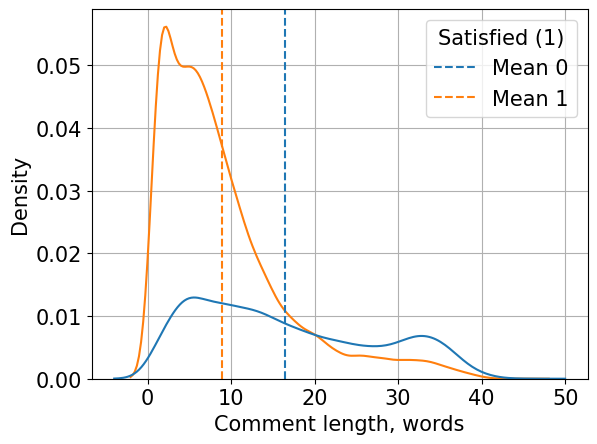

In [621]:
ax = sns.kdeplot(data = d1, x = 'comment_length_wrds', hue = 'satisfied')
ax.set_xlabel(xlabel = 'Comment length, words', fontsize = 15)
ax.set_ylabel(ylabel = 'Density', fontsize = 15)
mean0 = d1.groupby('satisfied')['comment_length_wrds'].mean().iloc[0]
mean1 = d1.groupby('satisfied')['comment_length_wrds'].mean().iloc[1]
plt.axvline(mean0, color = '#1f77b4', linestyle='--', label = 'Mean 0')
plt.axvline(mean1, color='#ff7f0e', linestyle='--', label = 'Mean 1')
plt.tick_params(labelsize=15)
plt.grid()
ax.legend(fontsize = 15, title='Satisfied (1)', title_fontsize = 15)

In [622]:
d1.groupby('satisfied')['comment_length_wrds'].mean()

satisfied
0    16.422025
1     8.862679
Name: comment_length_wrds, dtype: float64

In [623]:
d1['comment_length_wrds'].isna().value_counts()

comment_length_wrds
True     51678
False    34069
Name: count, dtype: int64

In [624]:
err_dist=d1.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['Distance']

[Text(0.5, 0, '')]

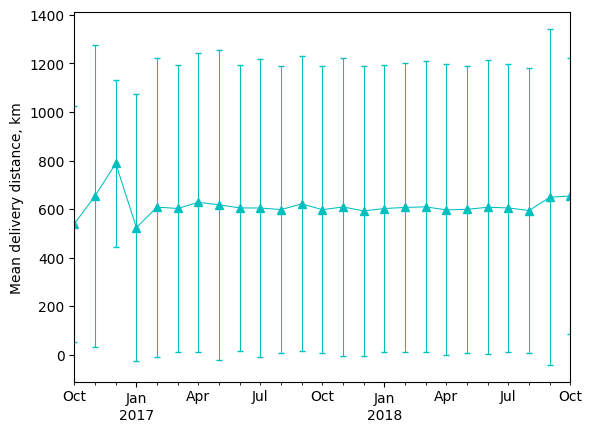

In [625]:
#on average how far were the orders per month
ax = d1.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['Distance'].mean().plot(yerr=err_dist.std(), fmt='c-^', capsize=2, linewidth=0.75, ylabel='Mean delivery distance, km')
#yerr=[err_dist.mean()-err_dist.min(),err_dist.max()-err_dist.mean()]
ax.set(xlabel=None)

In [626]:
d1['freight_price_ratio'] = d1['freight_value']/d1['price']

[Text(0.5, 0, '')]

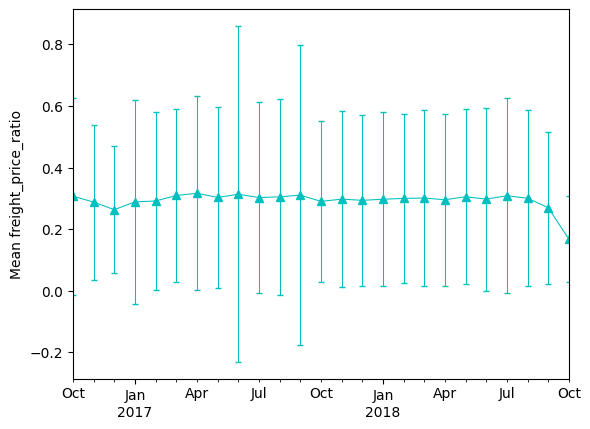

In [627]:
#on average what is the freight_value/price ratio per month
err_rt=d1.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['freight_price_ratio']

ax = d1.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['freight_price_ratio'].mean().plot(yerr=err_rt.std(), fmt='c-^', capsize=2, linewidth=0.75, ylabel='Mean freight_price_ratio')
#yerr=[err_wt.mean()-err_wt.min(),err_wt.max()-err_wt.mean()]
ax.set(xlabel=None)

###Beginning to look at shipping costs

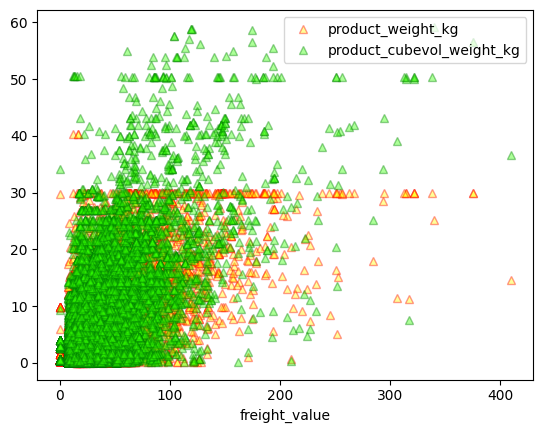

In [628]:
#calculate weight in kg's
d1['product_weight_kg'] = d1['product_weight_g'] / 1000
#calculate cubic to volumetric weight in kg's = length x width x height / 5000; this is a shipping standard, higher of physical weight or this used to culaculate
#shipping cost; olist customers pay shipping for orders < R$79; olist covers upto 50% of shipping, seller rest, for orders > R$79; % depends on seller index
d1['product_cubevol_weight_kg'] = (d1['product_height_cm'] * d1['product_length_cm'] * d1['product_width_cm']) / 5000
#take higher of physical or volumetric weight, call shipping weight [kg]
d1['shipping_weight_kg'] = np.where(d1['product_weight_kg'] < d1['product_cubevol_weight_kg'], d1['product_cubevol_weight_kg'], d1['product_weight_kg'])
plt.plot(d1['freight_value'], d1['product_weight_kg'], 'r^', markerfacecolor=(1, 1, 0, 0.4), label = 'product_weight_kg')
plt.plot(d1['freight_value'], d1['product_cubevol_weight_kg'], 'g^', markerfacecolor=(0.2, 1, 0, 0.4), label = 'product_cubevol_weight_kg')
plt.legend()
plt.xlabel('freight_value')
plt.show()

[Text(0.5, 0, '')]

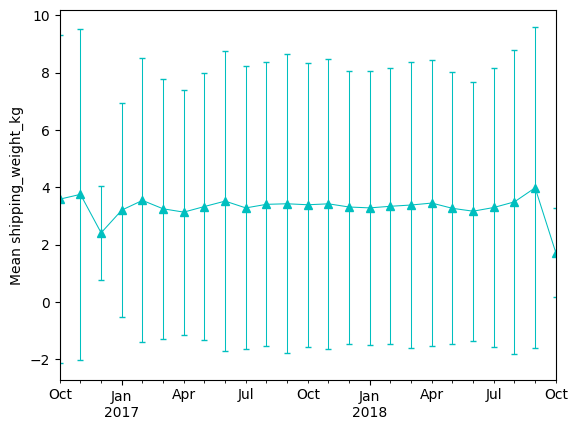

In [629]:
#on average how heavy were the orders per month
err_wt=d1.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['shipping_weight_kg']

ax = d1.groupby(pd.to_datetime(orders_dataset['order_delivered_customer_date']).dt.to_period('M'))\
 ['shipping_weight_kg'].mean().plot(yerr=err_wt.std(), fmt='c-^', capsize=2, linewidth=0.75, ylabel='Mean shipping_weight_kg')
#yerr=[err_wt.mean()-err_wt.min(),err_wt.max()-err_wt.mean()]
ax.set(xlabel=None)

In [630]:
#check if any of the weight fields are null
p1 = d1['product_weight_kg'].isnull()
#d1[p1]

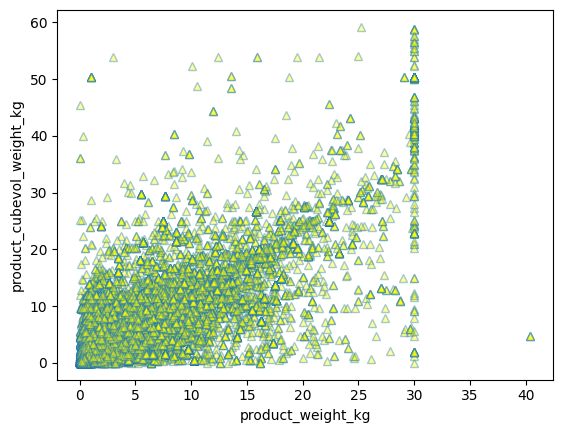

In [631]:
plt.plot(d1['product_weight_kg'], d1['product_cubevol_weight_kg'], '^', markerfacecolor=(1, 1, 0, 0.4))
plt.xlabel('product_weight_kg')
plt.ylabel('product_cubevol_weight_kg')
plt.show()

In [632]:
d1[['product_weight_kg','product_cubevol_weight_kg','shipping_weight_kg']].describe()

product_weight_kg  product_cubevol_weight_kg  shipping_weight_kg
count       85734.000000               85734.000000        85734.000000
mean            2.111026                   3.038358            3.352846
std             3.775764                   4.677155            4.911595
min             0.000000                   0.033600            0.070400
25%             0.300000                   0.563200            0.604800
50%             0.680000                   1.260000            1.482000
75%             1.825000                   3.672000            4.021950
max            40.425000                  59.241600           59.241600

(-5.0, 50.0)

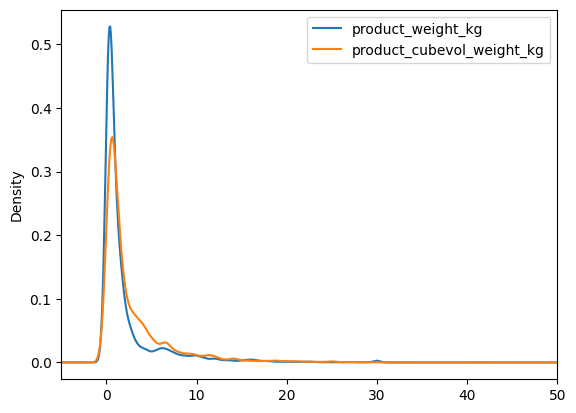

In [633]:
d1['product_weight_kg'].plot(kind='kde')
ax=d1['product_cubevol_weight_kg'].plot(kind='kde')
ax.legend()
ax.set_xlim(-5,50)

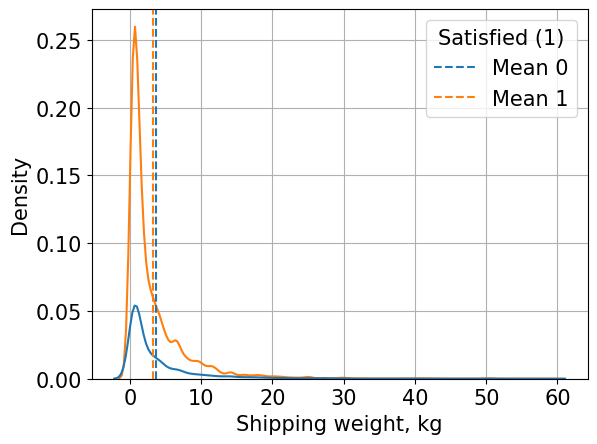

In [634]:
ax = sns.kdeplot(data = d1, x = 'shipping_weight_kg', hue = 'satisfied')
ax.set_xlabel(xlabel = 'Shipping weight, kg', fontsize = 15)
ax.set_ylabel(ylabel = 'Density', fontsize = 15)
mean0 = d1.groupby('satisfied')['shipping_weight_kg'].mean().iloc[0]
mean1 = d1.groupby('satisfied')['shipping_weight_kg'].mean().iloc[1]
plt.axvline(mean0, color = '#1f77b4', linestyle='--', label = 'Mean 0')
plt.axvline(mean1, color='#ff7f0e', linestyle='--', label = 'Mean 1')
plt.tick_params(labelsize=15)
plt.grid()
ax.legend(fontsize = 15, title='Satisfied (1)', title_fontsize = 15)

In [635]:
d1.groupby('satisfied')['shipping_weight_kg'].describe()

count      mean       std     min     25%     50%   75%      max
satisfied                                                                    
0          18277.0  3.631611  5.409176  0.0704  0.6000  1.5652  4.24  58.8000
1          67457.0  3.277317  4.765083  0.0704  0.6048  1.4400  4.00  59.2416

In [636]:
d1.groupby('satisfied')['shipping_weight_kg'].mean()[0]-d1.groupby('satisfied')['shipping_weight_kg'].mean()[1]

0.3542936277452733

The mean shipping weight of satisfied customers is lighter than not satisfied

In [637]:
d1[['price','freight_value']].describe()

price  freight_value
count  85747.000000   85747.000000
mean     130.378241      20.355605
std      196.688832      16.025676
min        0.850000       0.000000
25%       44.790000      13.420000
50%       79.990000      16.450000
75%      144.990000      21.330000
max     6735.000000     409.680000

<Axes: xlabel='price', ylabel='Density'>

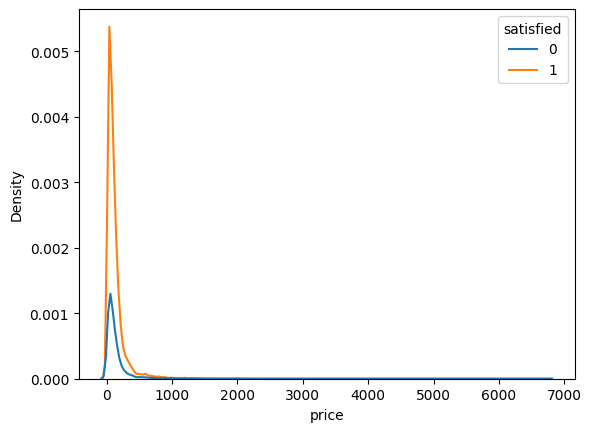

In [638]:
sns.kdeplot(data = d1, x = 'price', hue = 'satisfied')
#sns.kdeplot(data = d1, x = 'freight_value', hue = 'satisfied')

In [639]:
#plt.plot(d1['freight_value'].value_counts(),'^', markerfacecolor=(1, 1, 0, 0.4))

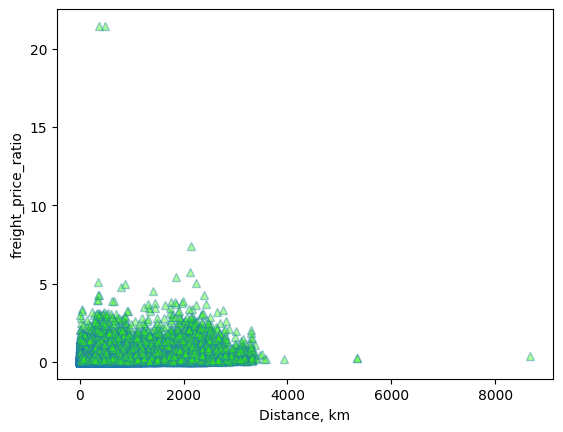

In [640]:
plt.plot(d1['Distance'], d1['freight_price_ratio'], '^', markerfacecolor=(0.2, 1, 0, 0.4))
plt.xlabel('Distance, km')
plt.ylabel('freight_price_ratio')
plt.show()

<Axes: xlabel='freight_price_ratio', ylabel='Density'>

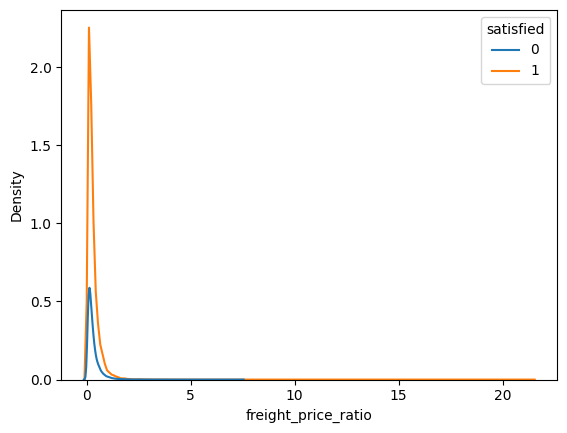

In [641]:
sns.kdeplot(data = d1, x = 'freight_price_ratio', hue = 'satisfied')

In [642]:
d1.groupby('satisfied')[['freight_price_ratio','freight_value','price']].mean()

freight_price_ratio  freight_value       price
satisfied                                                
0                     0.309424      21.353360  135.640462
1                     0.298975      20.085266  128.952456

There is no clear connection between the ratio and satisfied or not possibly price but relatively similar

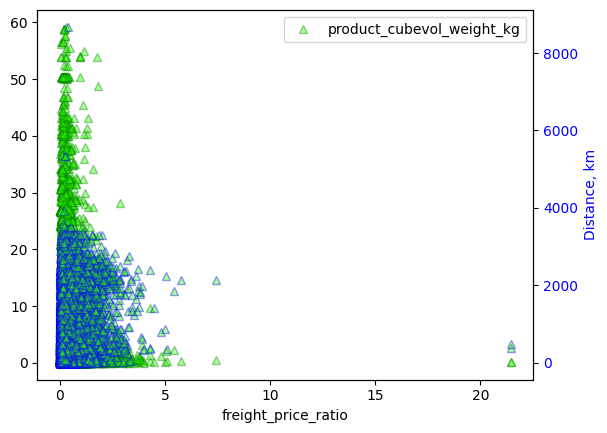

In [643]:
fig, ax1 = plt.subplots()

#plt.plot(d1['freight_price_ratio'], d1['product_weight_kg'], 'r^', markerfacecolor=(0.2, 1, 0, 0.4), label = f'{d1.columns.to_list()[68]}')
plt.plot(d1['freight_price_ratio'], d1['product_cubevol_weight_kg'], 'g^', markerfacecolor=(0.2, 1, 0, 0.4), label = 'product_cubevol_weight_kg')
plt.xlabel('freight_price_ratio')
plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Distance, km', color = 'blue')
ax2.plot(d1['freight_price_ratio'], d1['Distance'], 'b^', markerfacecolor=(0.2, 1, 0, 0.4))
ax2.tick_params(axis ='y', labelcolor = 'blue')

plt.show()

Appears that the smaller/lighter/closer the item the more people pay for shipping; there is an incentive for buying bigger/heavier/further away items?

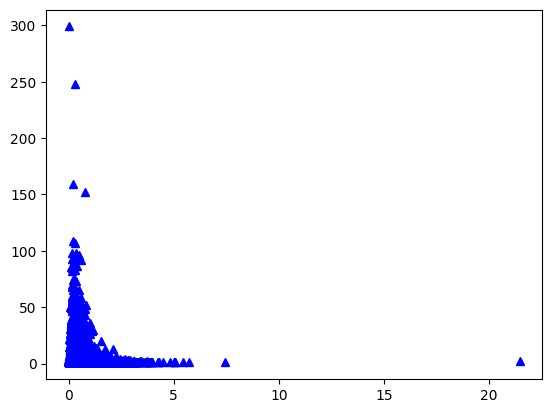

In [644]:
plt.plot(d1['freight_price_ratio'].value_counts(), 'b^')

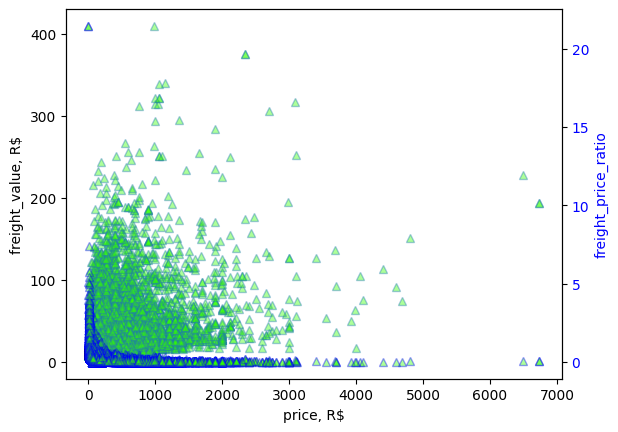

In [645]:
fig, ax1 = plt.subplots()

plt.plot(d1['price'], d1['freight_value'], '^', markerfacecolor=(0.2, 1, 0, 0.4))
plt.xlabel('price, R$')
plt.ylabel('freight_value, R$')

ax2 = ax1.twinx()
ax2.set_ylabel('freight_price_ratio', color = 'blue')
ax2.plot(d1['price'], d1['freight_price_ratio'], 'b^', markerfacecolor=(0.2, 1, 0, 0.4))
ax2.tick_params(axis ='y', labelcolor = 'blue')

plt.show()

Expensive items have 0 or low shipping, cheaper items have low or higher shipping.

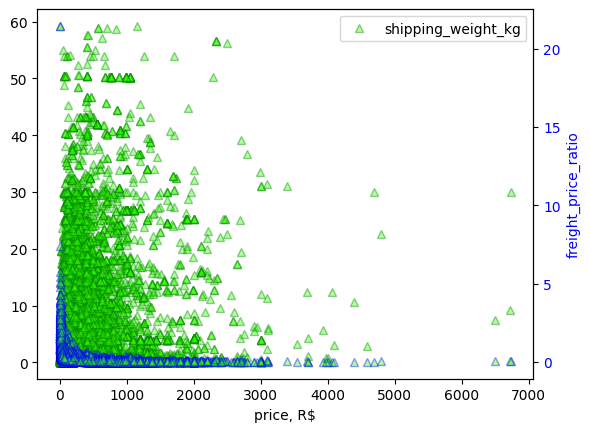

In [646]:
fig, ax1 = plt.subplots()

plt.plot(d1['price'], d1['shipping_weight_kg'], 'g^', markerfacecolor=(0.2, 1, 0, 0.4), label = 'shipping_weight_kg')
plt.xlabel('price, R$')
plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('freight_price_ratio', color = 'blue')
ax2.plot(d1['price'], d1['freight_price_ratio'], 'b^', markerfacecolor=(0.2, 1, 0, 0.4))
ax2.tick_params(axis ='y', labelcolor = 'blue')

plt.show()

In [647]:
d1[d1['freight_price_ratio']==d1['freight_price_ratio'].max()]

order_id                       customer_id  \
84395  3ee6513ae7ea23bdfab5b9ab60bffcb5  161b6d415e8b3413c6609c70cf405b5a   
98926  6e864b3f0ec71031117ad4cf46b7f2a1  9f9d249355f63c5c1216a82b802452c1   

      order_status order_purchase_timestamp    order_approved_at  \
84395    delivered      2018-04-24 11:01:06  2018-04-26 03:55:26   
98926    delivered      2018-04-24 20:15:21  2018-04-24 20:33:18   

      order_delivered_carrier_date order_delivered_customer_date  \
84395          2018-04-26 13:28:00           2018-05-07 23:21:11   
98926          2018-04-25 13:36:00           2018-05-04 19:32:53   

      order_estimated_delivery_date  order_item_id  \
84395                    2018-05-17            1.0   
98926                    2018-05-18            1.0   

                             product_id                         seller_id  \
84395  8a3254bee785a526d548a81a9bc3c9be  96804ea39d96eb908e7c3afdb671bb9e   
98926  8a3254bee785a526d548a81a9bc3c9be  96804ea39d96eb908e7c3afdb671bb9e   

       shipping_limit_date  price  freight_value  \
84395  2018-05-04 03:55:26   0.85          18.23   
98926  2018-05-02 20:30:34   0.85          18.23   

                     customer_unique_id  customer_zip_code_prefix  \
84395  d80730c15c647bc8f2ad77c908ba5ca9                     13189   
98926  b38211bd797f4fdd81a98b9d1754b606                     25215   

         customer_city customer_state  seller_zip_code_prefix seller_city  \
84395      hortolandia             SP                   38950        ibia   
98926  duque de caxias             RJ                   38950        ibia   

      seller_state              product_category_name  product_name_lenght  \
84395           MG  construcao_ferramentas_construcao                 25.0   
98926           MG  construcao_ferramentas_construcao                 25.0   

       product_description_lenght  product_photos_qty  product_weight_g  \
84395                      1041.0                 5.0             200.0   
98926                      1041.0                 5.0             200.0   

       product_length_cm  product_height_cm  product_width_cm  \
84395               16.0                4.0              11.0   
98926               16.0                4.0              11.0   

         product_category_name_english  payment_sequential payment_type  \
84395  construction_tools_construction                 1.0       boleto   
98926  construction_tools_construction                 1.0  credit_card   

       payment_installments  payment_value                         review_id  \
84395                   1.0          19.08  d33f69e22fbb6631558dc1d70c401451   
98926                   1.0          19.08  fe1d0cbf9fb760608f35cd67a8d482ff   

       review_score review_comment_title review_comment_message  \
84395           4.0                  NaN                    NaN   
98926           5.0                  NaN                    NaN   

      review_creation_date review_answer_timestamp mql_id sdr_id sr_id  \
84395  2018-05-08 00:00:00     2018-05-14 13:29:58    NaN    NaN   NaN   
98926  2018-05-05 00:00:00     2018-05-06 02:15:39    NaN    NaN   NaN   

      won_date business_segment lead_type lead_behaviour_profile has_company  \
84395      NaN              NaN       NaN                    NaN         NaN   
98926      NaN              NaN       NaN                    NaN         NaN   

      has_gtin average_stock business_type  declared_product_catalog_size  \
84395      NaN           NaN           NaN                            NaN   
98926      NaN           NaN           NaN                            NaN   

       declared_monthly_revenue  seller_closed first_contact_date  \
84395                       NaN          False                NaN   
98926                       NaN          False                NaN   

      landing_page_id origin  geolocation_zip_code_prefix_x  \
84395             NaN    NaN                          38950   
98926             NaN    NaN             

###Multiple regression

In [648]:
%%capture
# let's first transform the corresponding columns to a datetime object
# because they're strings at the moment

d1['order_delivered_customer_date'] = pd.to_datetime(d1['order_delivered_customer_date'])
d1['order_purchase_timestamp'] = pd.to_datetime(d1['order_purchase_timestamp'])

In [649]:
def order_id_stats_extended(x: pd.Series):
    """
    This function computes the total waiting time per order.
    We compute the time in days only
    """

    order_waiting_time_days = (x['order_delivered_customer_date'] - x['order_purchase_timestamp']).dt.days.mean()

    freight_price_ratio = x['freight_price_ratio'].mean()
    shipping_weight_kg = x['shipping_weight_kg'].mean()
    product_description_length = x['product_description_lenght'].mean()
    comment_length_wrds = x['comment_length_wrds'].mean()
    distance = x['Distance'].mean()

    review_score = x['review_score'].mean()

    return pd.DataFrame({
            'order_waiting_time_days': [order_waiting_time_days],
            'freight_price_ratio': [freight_price_ratio],
            'shipping_weight_kg': [shipping_weight_kg],
            'product_description_length': [product_description_length],
            'comment_length_wrds': [comment_length_wrds],
            'distance': [distance],
            'review_score': [review_score]})

# group by order and compute the delivery statistics
order_stats_extended = d1.groupby('order_id').apply(order_id_stats_extended)
order_stats_extended.index = order_stats_extended.index.droplevel(1)

In [173]:
order_stats_extended

order_waiting_time_days  \
order_id                                                    
00010242fe8c5a6d1ba2dd792cb16214                      7.0   
00018f77f2f0320c557190d7a144bdd3                     16.0   
000229ec398224ef6ca0657da4fc703e                      7.0   
00024acbcdf0a6daa1e931b038114c75                      6.0   
00042b26cf59d7ce69dfabb4e55b4fd9                     25.0   
...                                                   ...   
fffc94f6ce00a00581880bf54a75a037                     17.0   
fffcd46ef2263f404302a634eb57f7eb                      9.0   
fffce4705a9662cd70adb13d4a31832d                      4.0   
fffe18544ffabc95dfada21779c9644f                      1.0   
fffe41c64501cc87c801fd61db3f6244                      5.0   

                                  freight_price_ratio  shipping_weight_kg  \
order_id                                                                    
00010242fe8c5a6d1ba2dd792cb16214             0.225637              0.7056   
00018f77f2f0320c557190d7a144bdd3             0.083076             30.0000   
000229ec398224ef6ca0657da4fc703e             0.089799              3.0500   
00024acbcdf0a6daa1e931b038114c75             0.984604              0.4800   
00042b26cf59d7ce69dfabb4e55b4fd9             0.090745              8.4000   
...                                               ...                 ...   
fffc94f6ce00a00581880bf54a75a037             0.144705             10.6800   
fffcd46ef2263f404302a634eb57f7eb             0.104371              8.9500   
fffce4705a9662cd70adb13d4a31832d             0.169670              1.9152   
fffe18544ffabc95dfada21779c9644f             0.155742              1.6000   
fffe41c64501cc87c801fd61db3f6244             0.297442              0.6000   

                                  product_description_length  \
order_id                                                       
00010242fe8c5a6d1ba2dd792cb16214                       598.0   
00018f77f2f0320c557190d7a144bdd3                       239.0   
000229ec398224ef6ca0657da4fc703e                       695.0   
00024acbcdf0a6daa1e931b038114c75                       480.0   
00042b26cf59d7ce69dfabb4e55b4fd9                       409.0   
...                                                      ...   
fffc94f6ce00a00581880bf54a75a037                      1002.0   
fffcd46ef2263f404302a634eb57f7eb                       232.0   
fffce4705a9662cd70adb13d4a31832d                       869.0   
fffe18544ffabc95dfada21779c9644f                      1306.0   
fffe41c64501cc87c801fd61db3f6244                       511.0   

                                  comment_length_wrds     distance  \
order_id                                                             
00010242fe8c5a6d1ba2dd792cb16214                  6.0   301.504681   
00018f77f2f0320c557190d7a144bdd3                  NaN   585.563937   
000229ec398224ef6ca0657da4fc703e                 13.0   312.343511   
00024acbcdf0a6daa1e931b038114c75                  NaN   293.168420   
00042b26cf59d7ce69dfabb4e55b4fd9                  7.0   646.163463   
...                                               ...          ...   
fffc94f6ce00a00581880bf54a75a037                  NaN  2754.537709   
fffcd46ef2263f404302a634eb57f7eb                  NaN   351.729420   
fffce4705a9662cd70adb13d4a31832d                  NaN   339.056961   
fffe18544ffabc95dfada21779c9644f                  8.0    72.335998   
fffe41c64501cc87c801fd61db3f6244                  NaN   134.980397   

                                  review_score  
order_id                                        
00010242fe8c5a6d1ba2dd792cb16214           5.0  
00018f77f2f0320c557190d7a144bdd3           4.0  
000229ec398224ef6ca0657da4fc703e           5.0  
00024acbcdf0a6daa1e931b038114c75           4.0  
00042b26cf59d7ce69dfabb4e55b4fd9           5.0  
...                                        ...  
fffc94f6ce00a00581880bf54a75a037           5.0  
fffcd46ef2263f404302a634eb57f7eb           5.0  
fffc

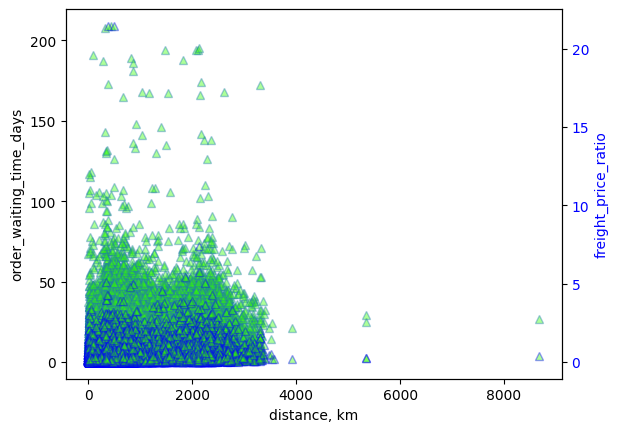

In [174]:
fig, ax1 = plt.subplots()

plt.plot(order_stats_extended['distance'], order_stats_extended['order_waiting_time_days'], '^', markerfacecolor=(0.2, 1, 0, 0.4))
plt.xlabel('distance, km')
plt.ylabel('order_waiting_time_days')

ax2 = ax1.twinx()
ax2.set_ylabel('freight_price_ratio', color = 'blue')
ax2.plot(order_stats_extended['distance'], order_stats_extended['freight_price_ratio'], 'b^', markerfacecolor=(0.2, 1, 0, 0.4))
ax2.tick_params(axis ='y', labelcolor = 'blue')

plt.show()

In [175]:
from scipy import stats

independent_variables = ['order_waiting_time_days',
                         'freight_price_ratio',
                         'shipping_weight_kg',
                         'product_description_length',
                         'comment_length_wrds',
                         'distance']

review_stats_extended = order_stats_extended.groupby('review_score')[independent_variables]\
                      .agg(mean_order_waiting_time_days=('order_waiting_time_days', 'mean'),
                           mean_freight_price_ratio=('freight_price_ratio', 'mean'),
                           mean_shipping_weight_kg=('shipping_weight_kg', 'mean'),
                           mean_comment_length_wrds=('comment_length_wrds', 'mean'),
                           mean_product_description_length=('product_description_length', 'mean'),
                           mean_distance=('distance', 'mean'))\
                      .reset_index()


In [176]:
review_stats_extended

review_score  mean_order_waiting_time_days  mean_freight_price_ratio  \
0           1.0                     22.634419                  0.303432   
1           2.0                     17.000000                  0.314552   
2           3.0                     14.015147                  0.317370   
3           4.0                     11.900405                  0.307003   
4           5.0                     10.241312                  0.296294   

   mean_shipping_weight_kg  mean_comment_length_wrds  \
0                 3.788864                 17.226234   
1                 3.658012                 17.053797   
2                 3.401307                 14.324757   
3                 3.344577                 10.445681   
4                 3.254860                  8.408124   

   mean_product_description_length  mean_distance  
0                       804.017115     683.108468  
1                       754.510255     660.553081  
2                       779.838994     636.865341  
3                       801.945790     628.109376  
4                       807.899449     576.486447

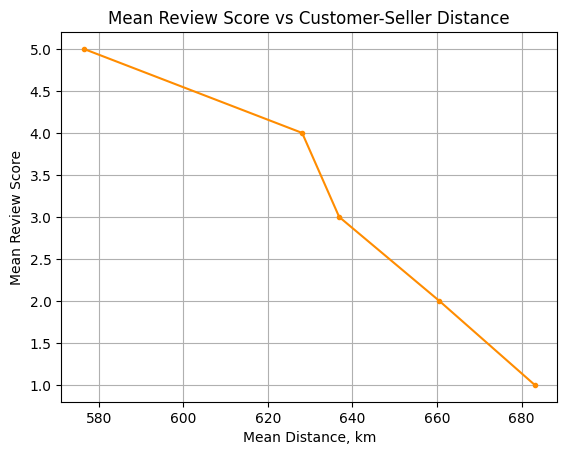

In [390]:
plt.plot(review_stats_extended['mean_distance'], review_stats_extended['review_score'], '.-', color='darkorange')
plt.grid()
plt.xlabel('Mean Distance, km')
plt.ylabel('Mean Review Score')
plt.title('Mean Review Score vs Customer-Seller Distance')
plt.show()

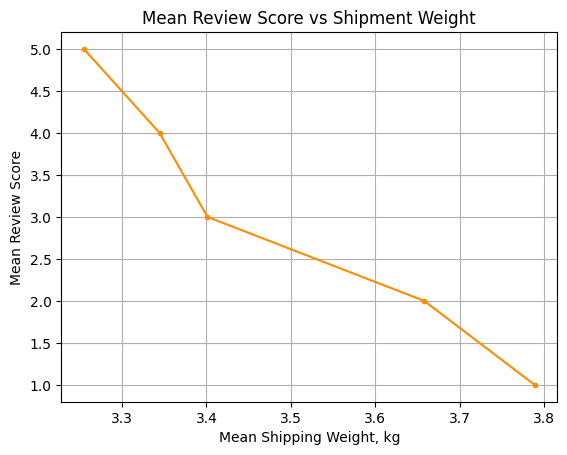

In [389]:
plt.plot(review_stats_extended['mean_shipping_weight_kg'], review_stats_extended['review_score'], '.-', color='darkorange')
plt.grid()
plt.xlabel('Mean Shipping Weight, kg')
plt.ylabel('Mean Review Score')
plt.title('Mean Review Score vs Shipment Weight')
plt.show()

Text(0.5, 0, 'Mean product description length')

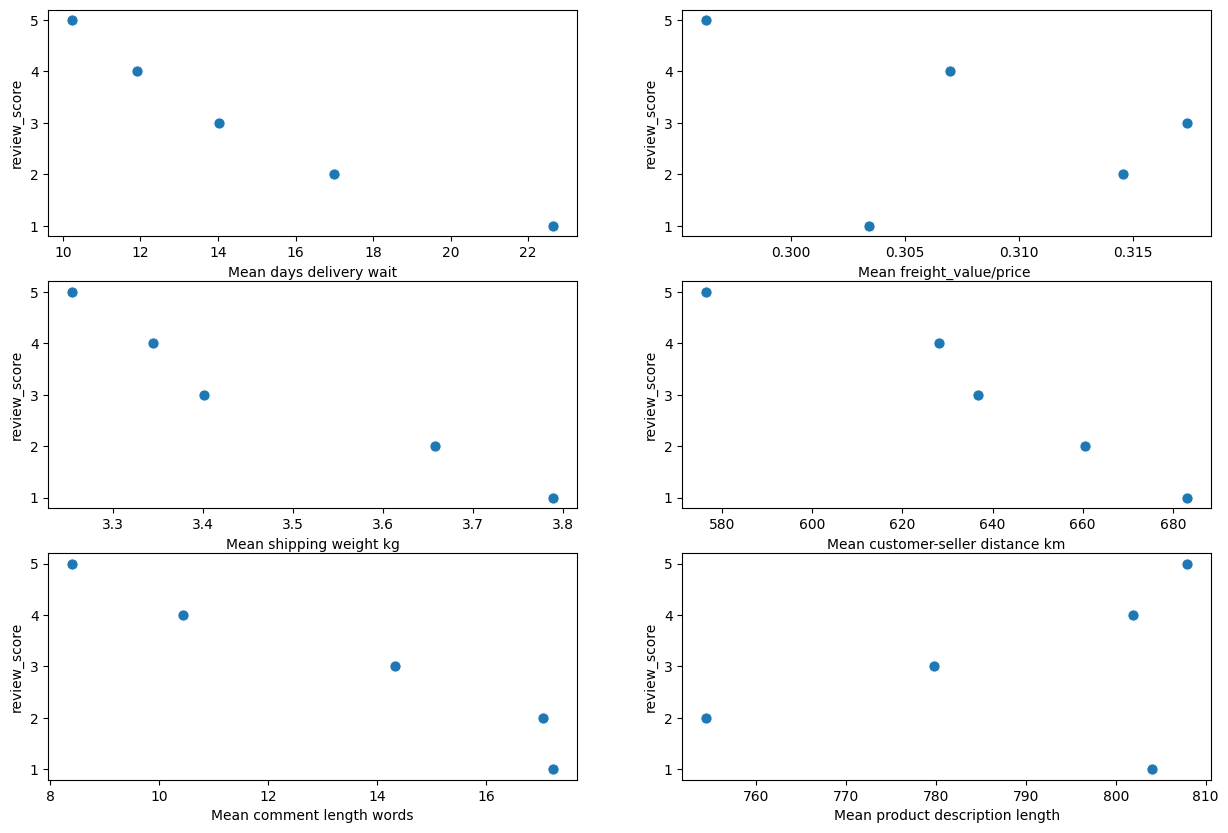

In [177]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))


sns.scatterplot(data=review_stats_extended,
                x='mean_order_waiting_time_days',
                y='review_score',
                ax=axes[0][0], s=65)

axes[0][0].set_xlabel("Mean days delivery wait")

sns.scatterplot(data=review_stats_extended,
                x='mean_freight_price_ratio',
                y='review_score',
                ax=axes[0][1], s=65)

axes[0][1].set_xlabel("Mean freight_value/price ")


sns.scatterplot(data=review_stats_extended,
                x='mean_shipping_weight_kg',
                y='review_score',
                ax=axes[1][0], s=65)

axes[1][0].set_xlabel("Mean shipping weight kg")


sns.scatterplot(data=review_stats_extended,
                x='mean_distance',
                y='review_score',
                ax=axes[1][1], s=65)

axes[1][1].set_xlabel("Mean customer-seller distance km")

sns.scatterplot(data=review_stats_extended,
                x='mean_comment_length_wrds',
                y='review_score',
                ax=axes[2][0], s=65)

axes[2][0].set_xlabel("Mean comment length words")


sns.scatterplot(data=review_stats_extended,
                x='mean_product_description_length',
                y='review_score',
                ax=axes[2][1], s=65)

axes[2][1].set_xlabel("Mean product description length")


In [178]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [179]:
reg_sm = smf.ols(formula=("review_score ~ mean_order_waiting_time_days + "
                          "               mean_freight_price_ratio + "
                          "               mean_shipping_weight_kg + "
                          "               mean_comment_length_wrds + "
                          "               mean_product_description_length + "
                          "               mean_distance"),
                 data=review_stats_extended).fit()

In [180]:
print(reg_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 09 Jul 2024   Prob (F-statistic):                nan
Time:                        14:35:43   Log-Likelihood:                 147.12
No. Observations:                   5   AIC:                            -284.2
Df Residuals:                       0   BIC:                            -286.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


Too few points, 5 only!

In [186]:
from ydata_profiling import ProfileReport

In [187]:
report = ProfileReport(review_stats_extended)

In [130]:
#report.to_notebook_iframe()

### Waiting time vs delivery

In [276]:
X = order_stats_extended[[
    'order_waiting_time_days',
    #'freight_price_ratio',
    # 'shipping_weight_kg',
    # 'product_description_length',
    # 'comment_length_wrds',
    'distance'
    # 'review_score'
    ]]

In [277]:
X

order_waiting_time_days     distance
order_id                                                              
00010242fe8c5a6d1ba2dd792cb16214                      7.0   301.504681
00018f77f2f0320c557190d7a144bdd3                     16.0   585.563937
000229ec398224ef6ca0657da4fc703e                      7.0   312.343511
00024acbcdf0a6daa1e931b038114c75                      6.0   293.168420
00042b26cf59d7ce69dfabb4e55b4fd9                     25.0   646.163463
...                                                   ...          ...
fffc94f6ce00a00581880bf54a75a037                     17.0  2754.537709
fffcd46ef2263f404302a634eb57f7eb                      9.0   351.729420
fffce4705a9662cd70adb13d4a31832d                      4.0   339.056961
fffe18544ffabc95dfada21779c9644f                      1.0    72.335998
fffe41c64501cc87c801fd61db3f6244                      5.0   134.980397

[81689 rows x 2 columns]

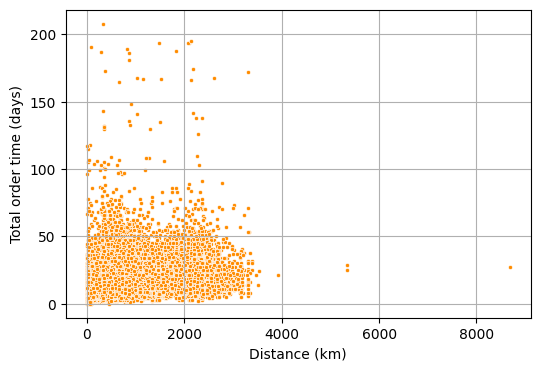

In [279]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=X, x='distance', y='order_waiting_time_days', marker='.', color='darkorange')

#plt.title('Review Score vs Delivery Time (trimed)')
plt.xlabel('Distance (km)')
plt.ylabel('Total order time (days)')
#plt.ylim(0, 5.3)
plt.grid(True)
plt.show()

###Clustering

In [681]:
order_stats_extended = order_stats_extended[~order_stats_extended['order_waiting_time_days'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['review_score'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['distance'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['shipping_weight_kg'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['product_description_length'].isna()]
#order_stats_extended = order_stats_extended[~order_stats_extended['comment_length_wrds'].isna()]

####K-means

order_waiting_time_days	freight_price_ratio	shipping_weight_kg	product_description_length	comment_length_wrds	distance	review_score

In [682]:
X = order_stats_extended[[
    'order_waiting_time_days',
    #'freight_price_ratio',
    # 'shipping_weight_kg',
    # 'product_description_length',
    # 'comment_length_wrds',
    'distance'
    # 'review_score'
    ]]

In [684]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [685]:
X_scaler = scaler.fit_transform(X)

In [686]:
X_scaler_with_column_names = pd.DataFrame(data=X_scaler, columns=X.columns)

In [687]:
X_scaler_with_column_names

order_waiting_time_days  distance
0                    -0.535709 -0.506281
1                     0.408737 -0.031269
2                    -0.535709 -0.488156
3                    -0.640647 -0.520221
4                     1.353182  0.070067
...                        ...       ...
81684                 0.513675  3.595745
81685                -0.325832 -0.422294
81686                -0.850524 -0.443485
81687                -1.165339 -0.889503
81688                -0.745586 -0.784747

[81689 rows x 2 columns]

In [688]:
from sklearn.cluster import KMeans

In [689]:
k_vector = list(range(1, 10))
error = []

for k in k_vector:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_scaler_with_column_names)
    error.append(k_means.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<Axes: >

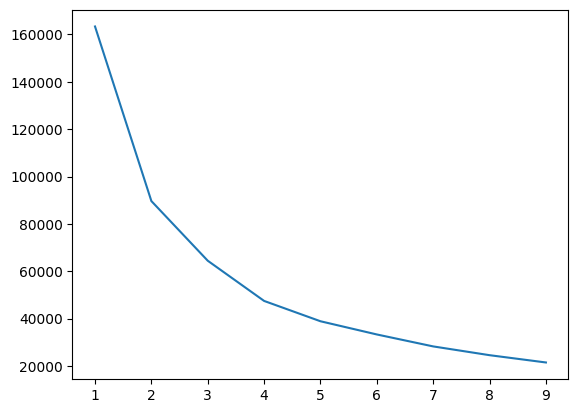

In [690]:
sns.lineplot(x=k_vector, y=error)

In [691]:
k_means_best = KMeans(n_clusters=3, random_state=42)

predicted_clusters = k_means_best.fit_predict(X_scaler_with_column_names)
predicted_clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

<Axes: >

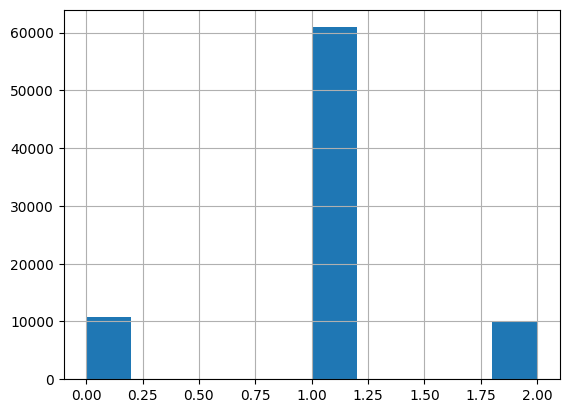

In [692]:
pd.Series(predicted_clusters).hist()

In [693]:
X_scaler_with_column_names["cluster"] = predicted_clusters

<Axes: xlabel='order_waiting_time_days', ylabel='Density'>

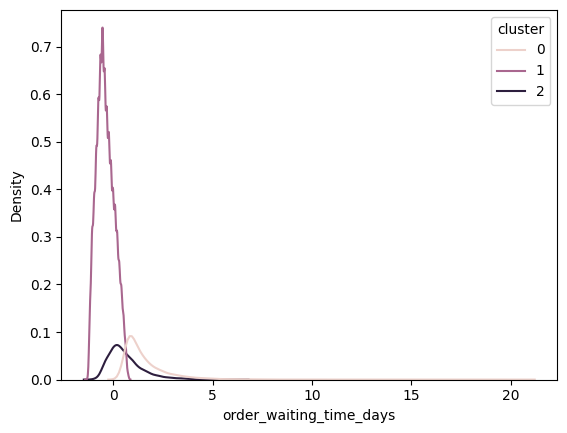

In [694]:
sns.kdeplot(data=X_scaler_with_column_names, x="order_waiting_time_days", hue="cluster")

<Axes: xlabel='distance', ylabel='Density'>

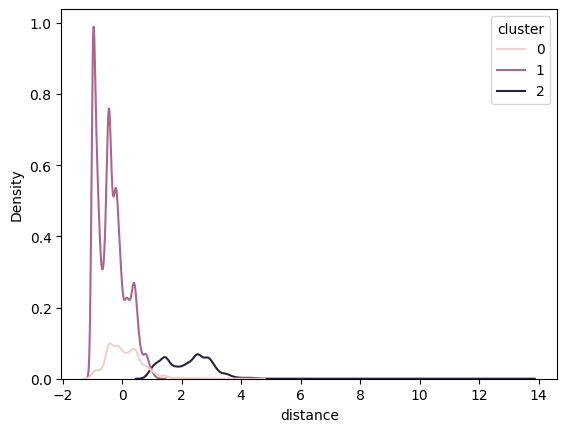

In [695]:
sns.kdeplot(data=X_scaler_with_column_names, x="distance", hue="cluster")

In [696]:
X_scaler_with_column_names.groupby('cluster')[['order_waiting_time_days', 'distance']].mean()

order_waiting_time_days  distance
cluster                                   
0                       1.623602  0.094271
1                      -0.388217 -0.378530
2                       0.610603  2.210385

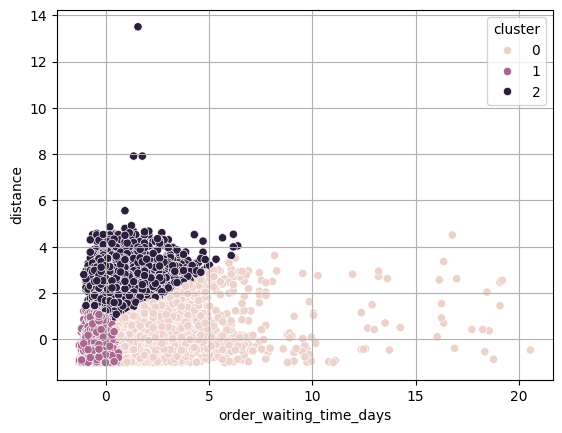

In [697]:
sns.scatterplot(data=X_scaler_with_column_names, x="order_waiting_time_days", y="distance", hue="cluster")
plt.grid()

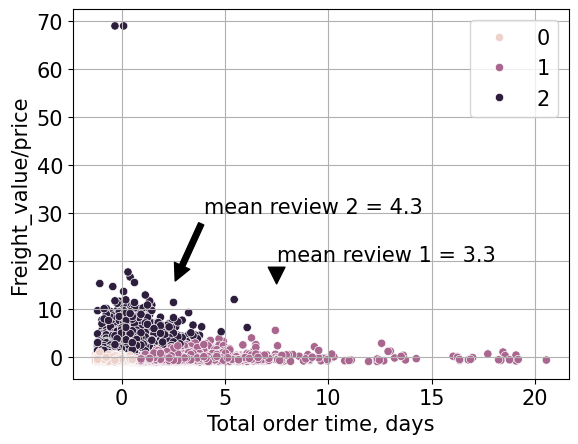

In [210]:
ax = sns.scatterplot(data=X_scaler_with_column_names, x="order_waiting_time_days", y="freight_price_ratio", hue="cluster")
ax.set_xlabel(xlabel = 'Total order time, days', fontsize = 15)
ax.set_ylabel(ylabel = 'Freight_value/price', fontsize = 15)
ax.annotate('mean review 2 = 4.3', fontsize=15, xy=(2.5, 15), xytext=(4, 30),
            arrowprops=dict(facecolor='black', shrink=0.06),
            )
ax.annotate('mean review 1 = 3.3', fontsize=15, xy=(7.5, 15), xytext=(7.5, 20),
            arrowprops=dict(facecolor='black', shrink=0.06),
            )
ax.annotate('mean review = 4.4', fontsize=15, xy=(-2.5, -5), xytext=(-2.5, -10),
            arrowprops=dict(facecolor='black', shrink=0.06),
            )
plt.tick_params(labelsize=15)
plt.grid()
ax.legend(fontsize = 15)

In [698]:
order_stats_extended['cluster'] = predicted_clusters

In [699]:
order_stats_extended.groupby('cluster')['review_score'].mean().sort_values(ascending=False)

cluster
1    4.389190
2    4.154680
0    3.300536
Name: review_score, dtype: float64

#### Cluster freight_price_ratio + distance

In [467]:
X = order_stats_extended[[
    #'order_waiting_time_days',
    'freight_price_ratio',
    # 'shipping_weight_kg',
    # 'product_description_length',
    # 'comment_length_wrds',
    'distance'
    # 'review_score'
    ]]

In [468]:
X

freight_price_ratio     distance
order_id                                                          
00010242fe8c5a6d1ba2dd792cb16214             0.225637   301.504681
00018f77f2f0320c557190d7a144bdd3             0.083076   585.563937
000229ec398224ef6ca0657da4fc703e             0.089799   312.343511
00024acbcdf0a6daa1e931b038114c75             0.984604   293.168420
00042b26cf59d7ce69dfabb4e55b4fd9             0.090745   646.163463
...                                               ...          ...
fffc94f6ce00a00581880bf54a75a037             0.144705  2754.537709
fffcd46ef2263f404302a634eb57f7eb             0.104371   351.729420
fffce4705a9662cd70adb13d4a31832d             0.169670   339.056961
fffe18544ffabc95dfada21779c9644f             0.155742    72.335998
fffe41c64501cc87c801fd61db3f6244             0.297442   134.980397

[85747 rows x 2 columns]

In [469]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [470]:
X_scaler = scaler.fit_transform(X)

In [471]:
X_scaler_with_column_names = pd.DataFrame(data=X_scaler, columns=X.columns)

In [472]:
X_scaler_with_column_names

freight_price_ratio  distance
0                -0.245195 -0.505835
1                -0.707775 -0.032053
2                -0.685961 -0.487757
3                 2.217499 -0.519739
4                -0.682890  0.069020
...                    ...       ...
85742            -0.507803  3.585569
85743            -0.638676 -0.422065
85744            -0.426797 -0.443201
85745            -0.471989 -0.888064
85746            -0.012202 -0.783580

[85747 rows x 2 columns]

In [473]:
from sklearn.cluster import KMeans

In [474]:
k_vector = list(range(1, 10))
error = []

for k in k_vector:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_scaler_with_column_names)
    error.append(k_means.inertia_)

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: >

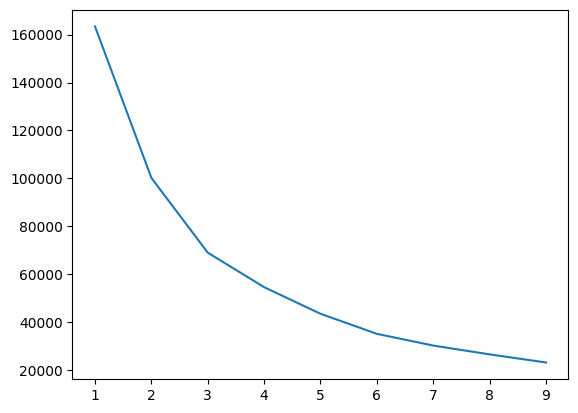

In [244]:
sns.lineplot(x=k_vector, y=error)

In [245]:
k_means_best = KMeans(n_clusters=3, random_state=42)

predicted_clusters = k_means_best.fit_predict(X_scaler_with_column_names)
predicted_clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

<Axes: >

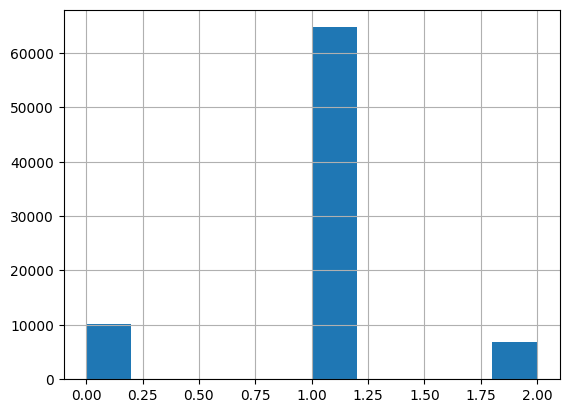

In [246]:
pd.Series(predicted_clusters).hist()

In [247]:
X_scaler_with_column_names["cluster"] = predicted_clusters

<Axes: xlabel='distance', ylabel='Density'>

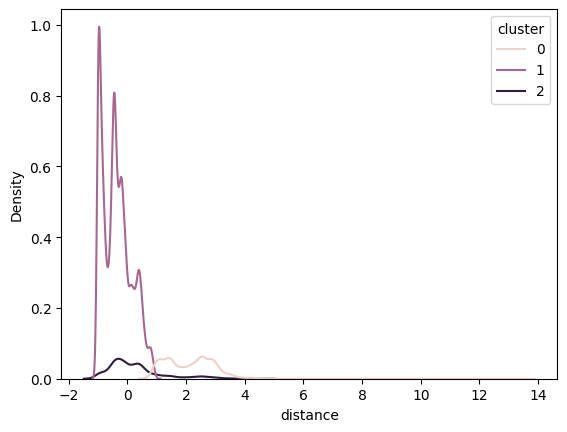

In [249]:
sns.kdeplot(data=X_scaler_with_column_names, x="distance", hue="cluster")

<Axes: xlabel='freight_price_ratio', ylabel='Density'>

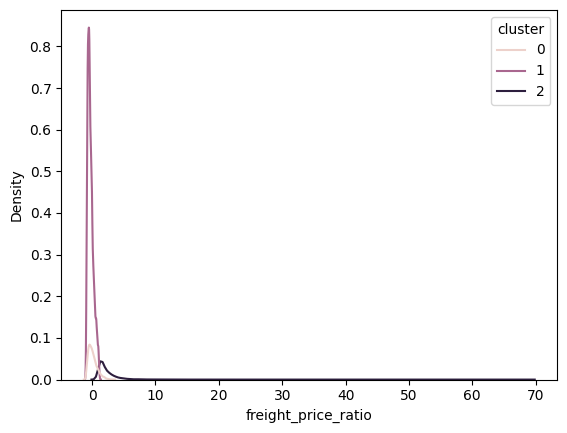

In [250]:
sns.kdeplot(data=X_scaler_with_column_names, x="freight_price_ratio", hue="cluster")

In [251]:
X_scaler_with_column_names.groupby('cluster')[['distance', 'freight_price_ratio']].mean()

distance  freight_price_ratio
cluster                               
0        2.121216             0.078821
1       -0.357740            -0.255417
2        0.255019             2.284305

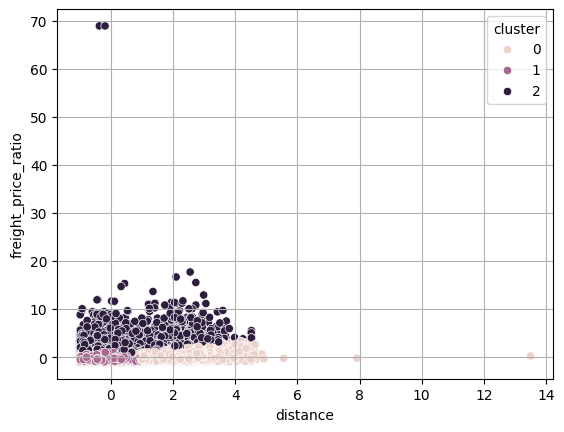

In [252]:
 sns.scatterplot(data=X_scaler_with_column_names, x="distance", y="freight_price_ratio", hue="cluster")
 plt.grid()

In [253]:
order_stats_extended['cluster'] = predicted_clusters

In [254]:
order_stats_extended.groupby('cluster')['review_score'].mean()

cluster
0    4.074360
1    4.242370
2    4.181039
Name: review_score, dtype: float64

#### Cluster 2: Total order time and distance

In [211]:
X = order_stats_extended[[
    'order_waiting_time_days',
    'freight_price_ratio',
    # 'shipping_weight_kg',
    # 'product_description_length',
    # 'comment_length_wrds',
    'distance',
    # 'review_score'
    ]]

In [212]:
X

order_waiting_time_days  \
order_id                                                    
00010242fe8c5a6d1ba2dd792cb16214                      7.0   
00018f77f2f0320c557190d7a144bdd3                     16.0   
000229ec398224ef6ca0657da4fc703e                      7.0   
00024acbcdf0a6daa1e931b038114c75                      6.0   
00042b26cf59d7ce69dfabb4e55b4fd9                     25.0   
...                                                   ...   
fffc94f6ce00a00581880bf54a75a037                     17.0   
fffcd46ef2263f404302a634eb57f7eb                      9.0   
fffce4705a9662cd70adb13d4a31832d                      4.0   
fffe18544ffabc95dfada21779c9644f                      1.0   
fffe41c64501cc87c801fd61db3f6244                      5.0   

                                  freight_price_ratio     distance  
order_id                                                            
00010242fe8c5a6d1ba2dd792cb16214             0.225637   301.504681  
00018f77f2f0320c557190d7a144bdd3             0.083076   585.563937  
000229ec398224ef6ca0657da4fc703e             0.089799   312.343511  
00024acbcdf0a6daa1e931b038114c75             0.984604   293.168420  
00042b26cf59d7ce69dfabb4e55b4fd9             0.090745   646.163463  
...                                               ...          ...  
fffc94f6ce00a00581880bf54a75a037             0.144705  2754.537709  
fffcd46ef2263f404302a634eb57f7eb             0.104371   351.729420  
fffce4705a9662cd70adb13d4a31832d             0.169670   339.056961  
fffe18544ffabc95dfada21779c9644f             0.155742    72.335998  
fffe41c64501cc87c801fd61db3f6244             0.297442   134.980397  

[81689 rows x 3 columns]

In [213]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [214]:
X_scaler = scaler.fit_transform(X)

In [215]:
X_scaler_with_column_names = pd.DataFrame(data=X_scaler, columns=X.columns)

In [216]:
X_scaler_with_column_names

order_waiting_time_days  freight_price_ratio  distance
0                    -0.535709            -0.247613 -0.506281
1                     0.408737            -0.712179 -0.031269
2                    -0.535709            -0.690272 -0.488156
3                    -0.640647             2.225654 -0.520221
4                     1.353182            -0.687188  0.070067
...                        ...                  ...       ...
81684                 0.513675            -0.511348  3.595745
81685                -0.325832            -0.642784 -0.422294
81686                -0.850524            -0.429995 -0.443485
81687                -1.165339            -0.475381 -0.889503
81688                -0.745586            -0.013620 -0.784747

[81689 rows x 3 columns]

In [217]:
from sklearn.cluster import KMeans

In [218]:
k_vector = list(range(1, 10))
error = []

for k in k_vector:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_scaler_with_column_names)
    error.append(k_means.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<Axes: >

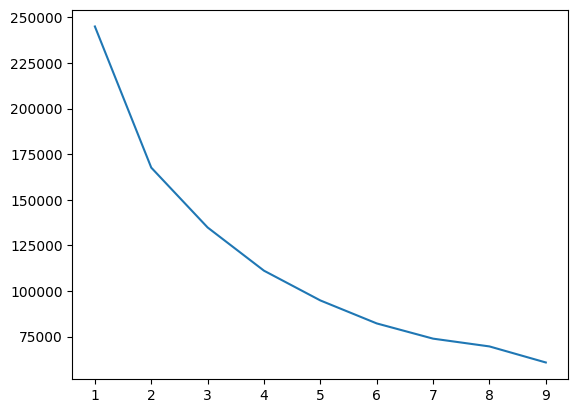

In [219]:
sns.lineplot(x=k_vector, y=error)

In [220]:
k_means_best = KMeans(n_clusters=3, random_state=42)

predicted_clusters = k_means_best.fit_predict(X_scaler_with_column_names)
predicted_clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

<Axes: >

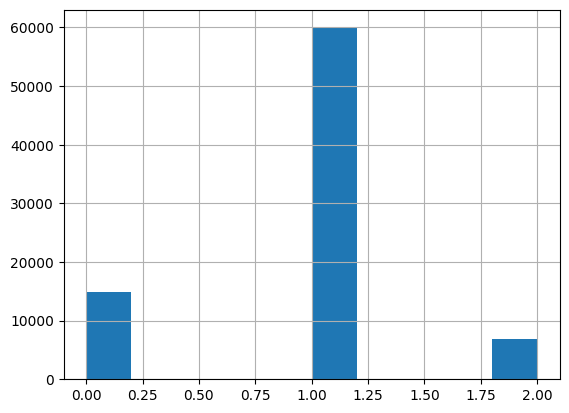

In [221]:
pd.Series(predicted_clusters).hist()

In [222]:
X_scaler_with_column_names["cluster"] = predicted_clusters

<Axes: xlabel='order_waiting_time_days', ylabel='Density'>

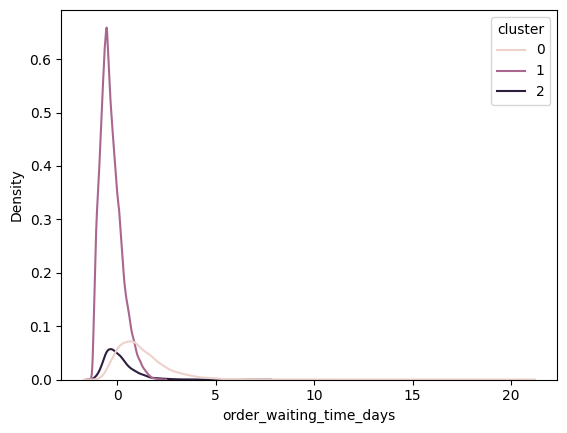

In [235]:
sns.kdeplot(data=X_scaler_with_column_names, x="order_waiting_time_days", hue="cluster")

<Axes: xlabel='freight_price_ratio', ylabel='Density'>

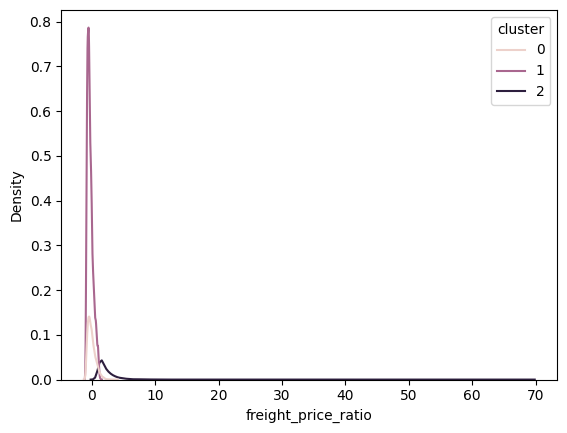

In [224]:
sns.kdeplot(data=X_scaler_with_column_names, x="freight_price_ratio", hue="cluster")

<Axes: xlabel='distance', ylabel='Density'>

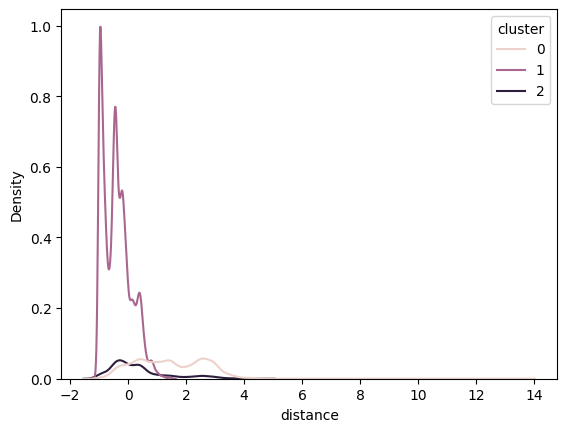

In [225]:
sns.kdeplot(data=X_scaler_with_column_names, x="distance", hue="cluster")

In [226]:
X_scaler_with_column_names.groupby('cluster')[['order_waiting_time_days', 'freight_price_ratio', 'distance']].mean()

order_waiting_time_days  freight_price_ratio  distance
cluster                                                        
0                       1.247658            -0.027810  1.432611
1                      -0.317380            -0.254757 -0.394615
2                       0.073249             2.314224  0.351100

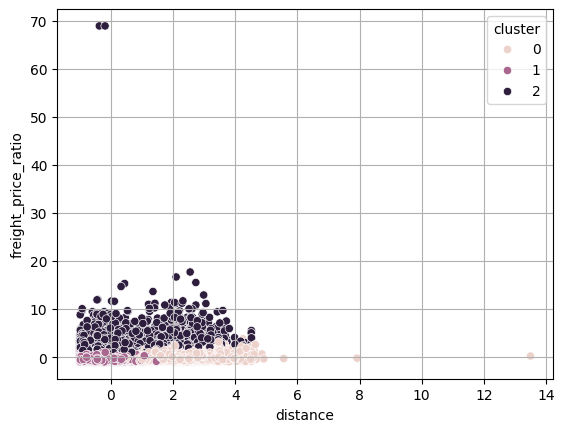

In [230]:
ax = sns.scatterplot(data=X_scaler_with_column_names, x="distance", y="freight_price_ratio", hue="cluster")
#ax.set_xlabel(xlabel = 'Total order time, days', fontsize = 15)
#ax.set_ylabel(ylabel = 'Freight_value/price', fontsize = 15)
#ax.annotate('mean review 2 = 4.3', fontsize=15, xy=(2.5, 15), xytext=(4, 30),
#            arrowprops=dict(facecolor='black', shrink=0.06),
#            )
#ax.annotate('mean review 1 = 3.3', fontsize=15, xy=(7.5, 15), xytext=(7.5, 20),
#            arrowprops=dict(facecolor='black', shrink=0.06),
#            )
#ax.annotate('mean review = 4.4', fontsize=15, xy=(-2.5, -5), xytext=(-2.5, -10),
#            arrowprops=dict(facecolor='black', shrink=0.06),
#            )
#plt.tick_params(labelsize=15)
plt.grid()
#ax.legend(fontsize = 15)

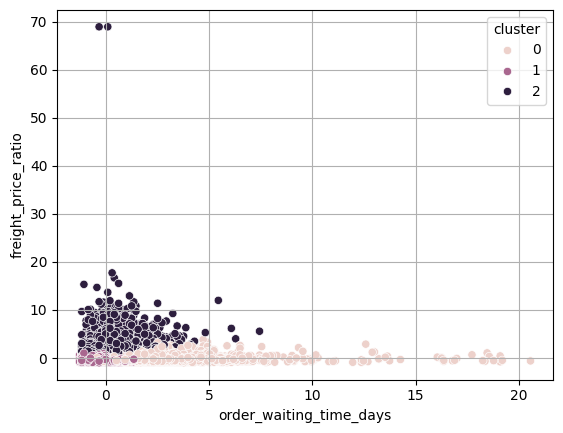

In [232]:
ax = sns.scatterplot(data=X_scaler_with_column_names, x="order_waiting_time_days", y="freight_price_ratio", hue="cluster")
plt.grid()

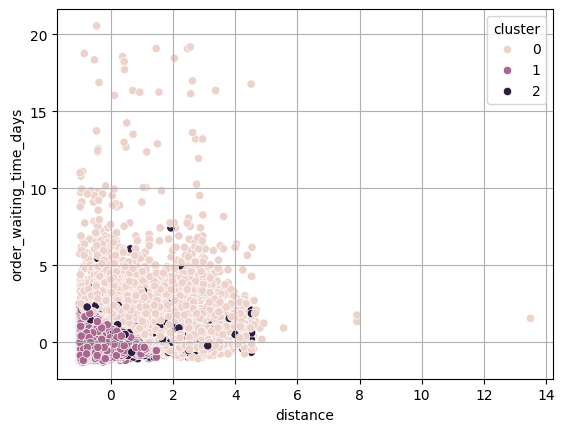

In [234]:
ax = sns.scatterplot(data=X_scaler_with_column_names, x="distance", y="order_waiting_time_days", hue="cluster")
plt.grid()

In [228]:
order_stats_extended['cluster'] = predicted_clusters

In [229]:
order_stats_extended.groupby('cluster')['review_score'].mean()

cluster
0    3.674422
1    4.349975
2    4.223221
Name: review_score, dtype: float64

### Random Forest Regressor

####Data preprocessing

In [ ]:
def order_id_stats_extended(x: pd.Series):
    """
    This function computes the total waiting time per order.
    We compute the time in days only
    """

    order_waiting_time_days = (x['order_delivered_customer_date'] - x['order_purchase_timestamp']).dt.days.mean()

    freight_price_ratio = x['freight_price_ratio'].mean()
    shipping_weight_kg = x['shipping_weight_kg'].mean()
    product_description_length = x['product_description_lenght'].mean()
    comment_length_wrds = x['comment_length_wrds'].mean()
    distance = x['Distance'].mean()

    review_score = x['review_score'].mean()

    return pd.DataFrame({
            'order_waiting_time_days': [order_waiting_time_days],
            'freight_price_ratio': [freight_price_ratio],
            'shipping_weight_kg': [shipping_weight_kg],
            'product_description_length': [product_description_length],
            'comment_length_wrds': [comment_length_wrds],
            'distance': [distance],
            'review_score': [review_score]})

# group by order and compute the delivery statistics
order_stats_extended = d1.groupby('order_id').apply(order_id_stats_extended)
order_stats_extended.index = order_stats_extended.index.droplevel(1)

In [435]:
order_stats_extended = order_stats_extended[~order_stats_extended['order_waiting_time_days'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['review_score'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['distance'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['shipping_weight_kg'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['product_description_length'].isna()]
order_stats_extended = order_stats_extended[~order_stats_extended['comment_length_wrds'].isna()]

In [436]:
order_stats_extended

order_waiting_time_days  \
order_id                                                    
00010242fe8c5a6d1ba2dd792cb16214                      7.0   
000229ec398224ef6ca0657da4fc703e                      7.0   
00042b26cf59d7ce69dfabb4e55b4fd9                     25.0   
0005a1a1728c9d785b8e2b08b904576c                      9.0   
00061f2a7bc09da83e415a52dc8a4af1                      4.0   
...                                                   ...   
ffea79d8c5fecc22cbff0c54eda9b65c                     16.0   
ffec1a6d35149778ec575d5048d44db8                      8.0   
ffeeb911d070bea3dd20bd5fd01da5e8                     18.0   
fffb0b1a50e65c449020434fa835e078                     34.0   
fffe18544ffabc95dfada21779c9644f                      1.0   

                                  freight_price_ratio  shipping_weight_kg  \
order_id                                                                    
00010242fe8c5a6d1ba2dd792cb16214             0.225637              0.7056   
000229ec398224ef6ca0657da4fc703e             0.089799              3.0500   
00042b26cf59d7ce69dfabb4e55b4fd9             0.090745              8.4000   
0005a1a1728c9d785b8e2b08b904576c             0.079822              2.0000   
00061f2a7bc09da83e415a52dc8a4af1             0.148025              3.5000   
...                                               ...                 ...   
ffea79d8c5fecc22cbff0c54eda9b65c             0.391800              7.8750   
ffec1a6d35149778ec575d5048d44db8             0.155089              1.1100   
ffeeb911d070bea3dd20bd5fd01da5e8             0.203648              2.8500   
fffb0b1a50e65c449020434fa835e078             2.236735              2.1120   
fffe18544ffabc95dfada21779c9644f             0.155742              1.6000   

                                  product_description_length  \
order_id                                                       
00010242fe8c5a6d1ba2dd792cb16214                       598.0   
000229ec398224ef6ca0657da4fc703e                       695.0   
00042b26cf59d7ce69dfabb4e55b4fd9                       409.0   
0005a1a1728c9d785b8e2b08b904576c                       493.0   
00061f2a7bc09da83e415a52dc8a4af1                       614.0   
...                                                      ...   
ffea79d8c5fecc22cbff0c54eda9b65c                       809.0   
ffec1a6d35149778ec575d5048d44db8                       409.0   
ffeeb911d070bea3dd20bd5fd01da5e8                       422.0   
fffb0b1a50e65c449020434fa835e078                       103.0   
fffe18544ffabc95dfada21779c9644f                      1306.0   

                                  comment_length_wrds     distance  \
order_id                                                             
00010242fe8c5a6d1ba2dd792cb16214                  6.0   301.504681   
000229ec398224ef6ca0657da4fc703e                 13.0   312.343511   
00042b26cf59d7ce69dfabb4e55b4fd9                  7.0   646.163463   
0005a1a1728c9d785b8e2b08b904576c                 30.0    53.236507   
00061f2a7bc09da83e415a52dc8a4af1                 14.0   154.134540   
...                                               ...          ...   
ffea79d8c5fecc22cbff0c54eda9b65c                  9.0  1556.173415   
ffec1a6d35149778ec575d5048d44db8                 19.0    79.219118   
ffeeb911d070bea3dd20bd5fd01da5e8                  6.0   136.065286   
fffb0b1a50e65c449020434fa835e078                 25.0   145.446090   
fffe18544ffabc95dfada21779c9644f                  8.0    72.335998   

                                  review_score  
order_id                                        
00010242fe8c5a6d1ba2dd792cb16214           5.0  
000229ec398224ef6ca0657da4fc703e           5.0  
00042b26cf59d7ce69dfabb4e55b4fd9           5.0  
0005a1a1728c9d785b8e2b08b904576c           1.0  
00061f2a7bc09da83e415a52dc8a4af1           5.0  
...                                        ...  
ffea79d8c5fecc22cbff0c54eda9b65c           4.0  
ffec1a6d35149778ec575d5048d44db8           4.0  
ffee

In [437]:
from sklearn.ensemble import RandomForestRegressor

In [438]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, oob_score=True)

In [439]:
X = order_stats_extended.drop(columns=['review_score'])
y = order_stats_extended['review_score']

In [440]:
rfr.fit(X,y)

RandomForestRegressor(max_depth=10, n_jobs=-1, oob_score=True, random_state=42)

In [441]:
rfr.oob_score_

0.29765382738160273

In [442]:
rfr.oob_prediction_

array([4.46688401, 4.17608859, 3.3927423 , ..., 4.16014218, 1.94620487,
       4.64421568])

In [443]:
rfr.score(X, y)

0.4269399779094094

In [444]:
rfr.feature_importances_

array([0.42987497, 0.05963828, 0.05690584, 0.05575756, 0.29793866,
       0.09988469])

In [449]:
def plot_feature_importances(rf, include_std: bool = True):
    importances = rf.feature_importances_
    if include_std:
        std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=X.columns).sort_values()

    fig, ax = plt.subplots()
    forest_importances.plot.barh(xerr=np.sort(std), ax=ax, color='steelblue')
    ax.set_title("Random Forest Feature Importance")
    ax.set_xlabel("Feature Importance")
    #fig.tight_layout()

    return forest_importances, std


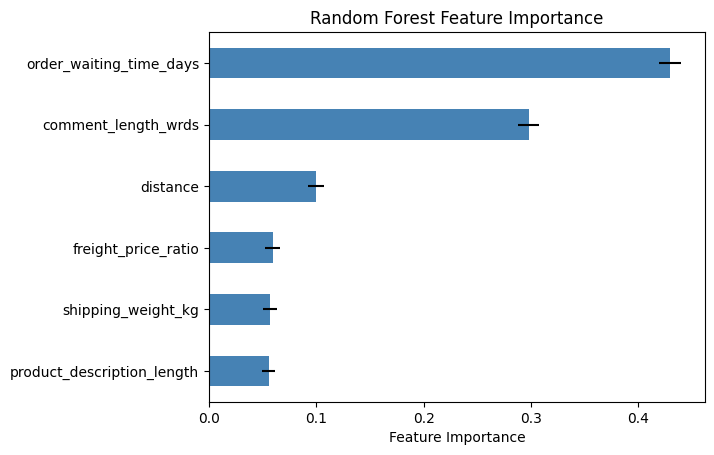

In [450]:
forest_importances, std = plot_feature_importances(rfr)

In [409]:
forest_importances

cluster                       0.001274
product_description_length    0.055446
shipping_weight_kg            0.056872
freight_price_ratio           0.058974
distance                      0.099979
comment_length_wrds           0.297884
order_waiting_time_days       0.429571
dtype: float64

In [410]:
std

array([0.00972565, 0.00662535, 0.00602998, 0.00700836, 0.00988826,
       0.00748777, 0.00096165])

####Random Forest Classifier

In [411]:
order_stats_extended['satisfied'] = np.where(order_stats_extended['review_score'] >= 4, 1, 0)

In [412]:
from sklearn.ensemble import RandomForestClassifier

In [413]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, oob_score=True)

In [414]:
X = order_stats_extended.drop(columns=['review_score', 'satisfied'])
y = order_stats_extended['satisfied']

In [415]:
rfc.fit(X, y)

RandomForestClassifier(max_depth=10, n_jobs=-1, oob_score=True, random_state=42)

In [416]:
rfc.oob_score_

0.7875938683050953

In [417]:
rfc.score(X, y)

0.821200273071433

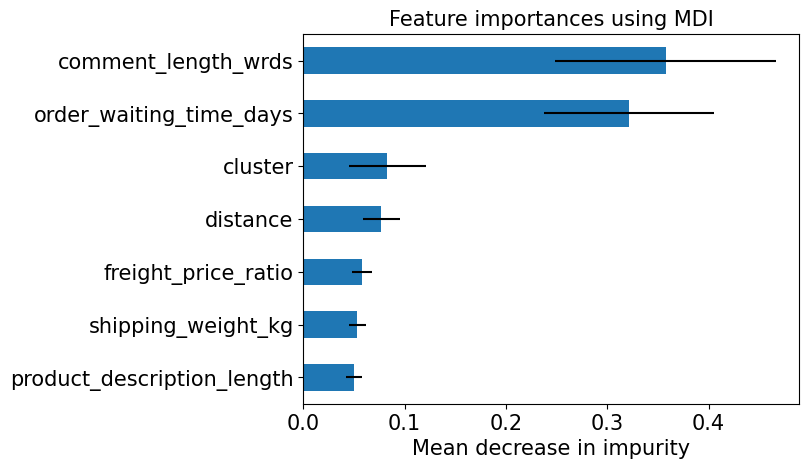

In [418]:
forest_importances, std = plot_feature_importances(rfc)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
predictions = rfc.predict(X)

In [ ]:
cm = confusion_matrix(y, predictions, labels=rfc.classes_)
cm_norm = confusion_matrix(y, predictions, labels=rfc.classes_, normalize='true')

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=rfc.classes_)

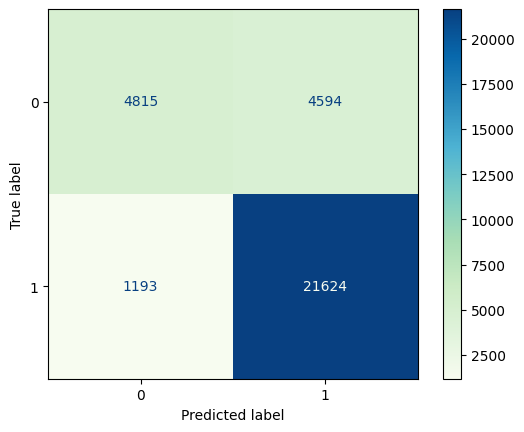

In [ ]:
disp.plot(cmap=plt.cm.GnBu)

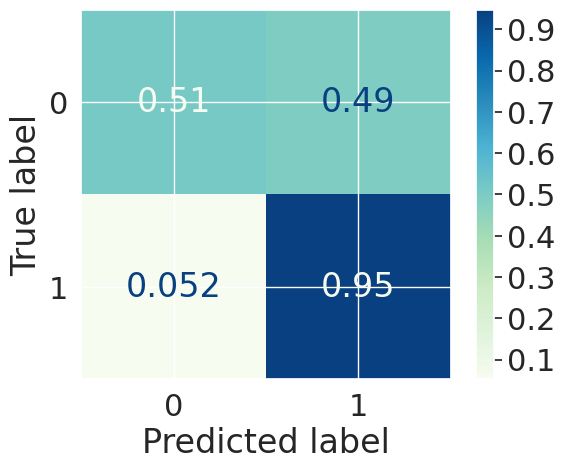

In [ ]:
disp_norm.plot(cmap=plt.cm.GnBu)
sns.set(font_scale=1.0)

####Catboost regressor

In [ ]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostregressor
from catboost import CatBoostRegressor

In [ ]:
cbr = CatBoostRegressor(iterations=100,depth=10, random_seed=42, loss_function='RMSE')

In [ ]:
X = order_stats_extended.drop(columns=['review_score','satisfied'])
y = order_stats_extended['review_score']

In [ ]:
cbr.fit(X, y)

Learning rate set to 0.460761
0:	learn: 1.3478780	total: 78.9ms	remaining: 7.81s
1:	learn: 1.2881420	total: 105ms	remaining: 5.13s
2:	learn: 1.2626622	total: 127ms	remaining: 4.12s
3:	learn: 1.2490161	total: 156ms	remaining: 3.74s
4:	learn: 1.2421493	total: 177ms	remaining: 3.37s
5:	learn: 1.2381482	total: 203ms	remaining: 3.17s
6:	learn: 1.2346603	total: 225ms	remaining: 2.99s
7:	learn: 1.2290730	total: 248ms	remaining: 2.86s
8:	learn: 1.2250650	total: 271ms	remaining: 2.74s
9:	learn: 1.2220320	total: 318ms	remaining: 2.86s
10:	learn: 1.2188544	total: 340ms	remaining: 2.75s
11:	learn: 1.2151699	total: 365ms	remaining: 2.68s
12:	learn: 1.2128965	total: 389ms	remaining: 2.6s
13:	learn: 1.2111996	total: 415ms	remaining: 2.55s
14:	learn: 1.2094197	total: 437ms	remaining: 2.48s
15:	learn: 1.2071582	total: 460ms	remaining: 2.41s
16:	learn: 1.2044992	total: 491ms	remaining: 2.4s
17:	learn: 1.2015641	total: 518ms	remaining: 2.36s
18:	learn: 1.1999148	total: 541ms	remaining: 2.31s
19:	learn: 1

In [ ]:
cbr_importances = pd.DataFrame({"name": cbr.feature_names_, "importance": cbr.feature_importances_})
cbr_importances.sort_values(by='importance', ascending=False)

name  importance
0     order_waiting_time_days   21.312382
4         comment_length_wrds   20.107432
5                    distance   15.298603
2          shipping_weight_kg   15.222189
1         freight_price_ratio   14.092665
3  product_description_length   13.966730

####Catboost classifier

In [ ]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
from catboost import CatBoostClassifier

In [ ]:
cbc = CatBoostClassifier(iterations=200,depth=10, random_seed=42, verbose=False)

In [ ]:
X = order_stats_extended.drop(columns=['review_score', 'satisfied'])
y = order_stats_extended['satisfied']

In [ ]:
cbc.fit(X, y)

In [ ]:
cbc_importances = pd.DataFrame({"name": cbc.feature_names_, "importance": cbc.feature_importances_})
cbc_importances.sort_values(by='importance', ascending=False)

name  importance
0     order_waiting_time_days   18.326280
4         comment_length_wrds   17.035258
5                    distance   16.519559
2          shipping_weight_kg   16.295220
1         freight_price_ratio   15.976183
3  product_description_length   15.847500

In [ ]:
predictions = cbc.predict(X)

In [ ]:
cm = confusion_matrix(y, predictions, labels=cbc.classes_)
cm_norm = confusion_matrix(y, predictions, labels=cbc.classes_, normalize='true')

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=rfc.classes_)

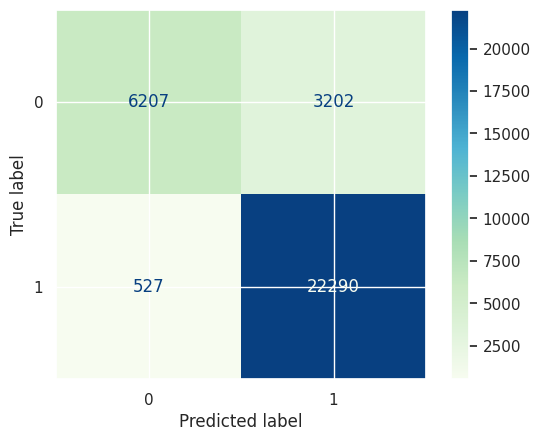

In [ ]:
disp.plot(cmap=plt.cm.GnBu)

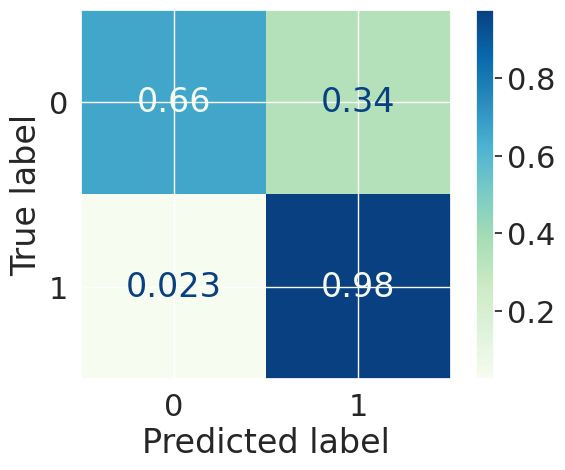

In [ ]:
disp_norm.plot(cmap=plt.cm.GnBu)
sns.set(font_scale=1.0)

###Understanding orders with more than one event (e.g., payment, item, etc.)

In [ ]:
merged.groupby(['order_id','order_item_id'])['price'].mean()

order_id                          order_item_id
00010242fe8c5a6d1ba2dd792cb16214  1.0               58.90
00018f77f2f0320c557190d7a144bdd3  1.0              239.90
000229ec398224ef6ca0657da4fc703e  1.0              199.00
00024acbcdf0a6daa1e931b038114c75  1.0               12.99
00042b26cf59d7ce69dfabb4e55b4fd9  1.0              199.90
                                                    ...  
fffc94f6ce00a00581880bf54a75a037  1.0              299.99
fffcd46ef2263f404302a634eb57f7eb  1.0              350.00
fffce4705a9662cd70adb13d4a31832d  1.0               99.90
fffe18544ffabc95dfada21779c9644f  1.0               55.99
fffe41c64501cc87c801fd61db3f6244  1.0               43.00
Name: price, Length: 112647, dtype: float64

In [ ]:
merged[merged['order_id']=='ffecd5a79a0084f6a592288c67e3c298']

order_id                       customer_id  \
8186  ffecd5a79a0084f6a592288c67e3c298  8afa5a415d65a08e3a68b1d7f9ddd8a5   
8187  ffecd5a79a0084f6a592288c67e3c298  8afa5a415d65a08e3a68b1d7f9ddd8a5   
8188  ffecd5a79a0084f6a592288c67e3c298  8afa5a415d65a08e3a68b1d7f9ddd8a5   

     order_status order_purchase_timestamp    order_approved_at  \
8186    delivered      2018-02-27 20:00:25  2018-02-27 20:15:27   
8187    delivered      2018-02-27 20:00:25  2018-02-27 20:15:27   
8188    delivered      2018-02-27 20:00:25  2018-02-27 20:15:27   

     order_delivered_carrier_date order_delivered_customer_date  \
8186          2018-02-28 20:54:52           2018-03-29 14:37:05   
8187          2018-02-28 20:54:52           2018-03-29 14:37:05   
8188          2018-02-28 20:54:52           2018-03-29 14:37:05   

     order_estimated_delivery_date  order_item_id  \
8186           2018-03-22 00:00:00            1.0   
8187           2018-03-22 00:00:00            2.0   
8188           2018-03-22 00:00:00            3.0   

                            product_id                         seller_id  \
8186  50fd2b788dc166edd20512370dac54df  8b321bb669392f5163d04c59e235e066   
8187  50fd2b788dc166edd20512370dac54df  8b321bb669392f5163d04c59e235e066   
8188  50fd2b788dc166edd20512370dac54df  8b321bb669392f5163d04c59e235e066   

      shipping_limit_date  price  freight_value  \
8186  2018-03-05 20:15:27   21.9          15.79   
8187  2018-03-05 20:15:27   21.9          15.79   
8188  2018-03-05 20:15:27   21.9          15.79   

                    customer_unique_id  customer_zip_code_prefix  \
8186  a969e99358a58bed2f4073fd04165a2b                     41810   
8187  a969e99358a58bed2f4073fd04165a2b                     41810   
8188  a969e99358a58bed2f4073fd04165a2b                     41810   

     customer_city customer_state  seller_zip_code_prefix seller_city  \
8186      salvador             BA                    1212   sao paulo   
8187      salvador             BA                    1212   sao paulo   
8188      salvador             BA                    1212   sao paulo   

     seller_state product_category_name  product_name_lenght  \
8186           SP           eletronicos                 46.0   
8187           SP           eletronicos                 46.0   
8188           SP           eletronicos                 46.0   

      product_description_lenght  product_photos_qty  product_weight_g  \
8186                      2285.0                 1.0             150.0   
8187                      2285.0                 1.0             150.0   
8188                      2285.0                 1.0             150.0   

      product_length_cm  product_height_cm  product_width_cm  \
8186               30.0               10.0              20.0   
8187               30.0               10.0              20.0   
8188               30.0               10.0              20.0   

     product_category_name_english  payment_sequential payment_type  \
8186                   electronics                 1.0  credit_card   
8187                   electronics                 1.0  credit_card   
8188                   electronics                 1.0  credit_card   

      payment_installments  payment_value                         review_id  \
8186                   1.0         113.07  63f01eff060a94c562615719b3cc7e8c   
8187                   1.0         113.07  63f01eff060a94c562615719b3cc7e8c   
8188                   1.0         113.07  63f01eff060a94c562615719b3cc7e8c   

      review_score review_comment_title review_comment_message  \
8186           2.0                  NaN                    NaN   
8187           2.0                  NaN                    NaN   
8188           2.0                  NaN                    NaN   

     review_creation_date review_answer_timestamp mql_id sdr_id sr_id  \
8186  2018-03-24 00:00:00     2018-03-24 15:21:09    NaN    NaN   NaN   
8187  2018-03-24 00:00:00     2018-03-24 15:21:09    NaN    NaN   NaN   
8

In [ ]:
merged.groupby(['order_id','order_item_id'])['freight_value'].mean()

order_id                          order_item_id
00010242fe8c5a6d1ba2dd792cb16214  1.0              13.29
00018f77f2f0320c557190d7a144bdd3  1.0              19.93
000229ec398224ef6ca0657da4fc703e  1.0              17.87
00024acbcdf0a6daa1e931b038114c75  1.0              12.79
00042b26cf59d7ce69dfabb4e55b4fd9  1.0              18.14
                                                   ...  
fffc94f6ce00a00581880bf54a75a037  1.0              43.41
fffcd46ef2263f404302a634eb57f7eb  1.0              36.53
fffce4705a9662cd70adb13d4a31832d  1.0              16.95
fffe18544ffabc95dfada21779c9644f  1.0               8.72
fffe41c64501cc87c801fd61db3f6244  1.0              12.79
Name: freight_value, Length: 112647, dtype: float64

In [ ]:
merged['Distance'] = haversine(merged['geolocation_lat_x'].shift(), merged['geolocation_lng_x'].shift(), merged['geolocation_lat_y'].shift(), merged['geolocation_lng_y'].shift())

###Working with full dataframe

In [ ]:
# 'order_processing_time' = 'order_purchase_timestamp' - 'order_approved_at' -- should always be positive

merged['order_processing_time'] = \
  (pd.to_datetime(merged['order_approved_at']) - \
   pd.to_datetime(merged['order_purchase_timestamp'])).dt.days

# 'order_delivery_time' = 'order_delivered_customer_date' - 'order_estimated_delivery_date' -- > 0 means delay
merged['order_delivery_time'] = \
  (pd.to_datetime(merged['order_delivered_customer_date']) - \
   pd.to_datetime(merged['order_estimated_delivery_date'])).dt.days

# flag late orders with 1, not late or early with 0 -- binning
merged['late_orders'] = (merged['order_delivery_time'] > 0).astype(int)

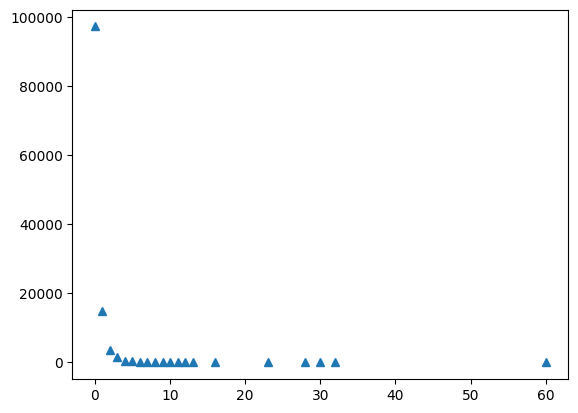

In [ ]:
plt.plot(merged['order_processing_time'].value_counts(),'^')
#merged['order_processing_time'].value_counts()

Most orders are processed the same day

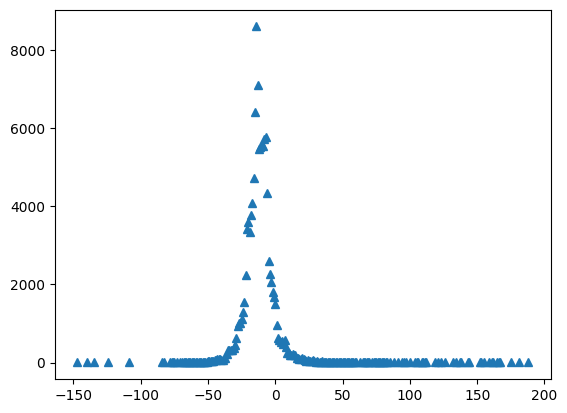

In [ ]:
plt.plot(merged['order_delivery_time'].value_counts(),'^')
#merged['order_delivery_time'].value_counts()

Most orders arrive earlier than promised

In [ ]:
# let's first transform the corresponding columns to a datetime object
# because they're strings at the moment

merged['order_delivered_customer_date'] = pd.to_datetime(merged['order_delivered_customer_date'])
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
merged['order_estimated_delivery_date'] = pd.to_datetime(merged['order_estimated_delivery_date'])

In [ ]:
merged['total_delivery_time_days'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days
merged['delivery_delay_days'] = (merged['order_estimated_delivery_date'] - merged['order_delivered_customer_date']).dt.days

In [ ]:
interesting_features_temporal = ["total_delivery_time_days", "delivery_delay_days"]

interesting_features_numeric = [
        "price", "freight_value",
        "product_weight_g",
        'Distance']

#interesting_features_categorical = ["customer_city", "customer_zip_code_prefix", "seller_state",
#                                    "product_category_name_english", "payment_type"]


target = ["review_score"]

#merged[["order_id", "customer_id", "order_item_id", "product_id"] + interesting_features_numeric + interesting_features_categorical + interesting_features_temporal]
merged[["order_id", "customer_id", "order_item_id", "product_id"] + interesting_features_numeric + interesting_features_temporal]

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
118302  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
118303  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
118304  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
118305  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
118306  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

        order_item_id                        product_id   price  \
0                 1.0  87285b34884572647811a353c7ac498a   29.99   
1                 1.0  87285b34884572647811a353c7ac498a   29.99   
2                 1.0  87285b34884572647811a353c7ac498a   29.99   
3                 1.0  595fac2a385ac33a80bd5114aec74eb8  118.70   
4                 1.0  aa4383b373c6aca5d8797843e5594415  159.90   
...               ...                               ...     ...   
118302            1.0  f1d4ce8c6dd66c47bbaa8c6781c2a923  174.90   
118303            1.0  b80910977a37536adeddd63663f916ad  205.99   
118304            1.0  d1c427060a0f73f6b889a5c7c61f2ac4  179.99   
118305            2.0  d1c427060a0f73f6b889a5c7c61f2ac4  179.99   
118306            1.0  006619bbed68b000c8ba3f8725d5409e   68.50   

        freight_value  product_weight_g    Distance  total_delivery_time_days  \
0                8.72             500.0         NaN                       8.0   
1                8.72             500.0   18.576110                       8.0   
2                8.72             500.0   18.576110                       8.0   
3               22.76             400.0   18.576110                      13.0   
4               19.22             420.0  851.495069                       9.0   
...               ...               ...         ...                       ...   
118302          20.10            4950.0   69.755064                      22.0   
118303          65.02           13300.0  474.120037                      24.0   
118304          40.59            6550.0  967.847297                      17.0   
118305          40.59            6550.0  370.404482                      17.0   
118306          18.36             150.0  370.404482                       7.0   

        delivery_delay_days  
0                       7.0  
1                       7.0  
2                       7.0  
3                       5.0  
4                      17.0  
...                     ...  
118302                  1.0  
118303                  5.0  
118304                 20.0  
118305                 20.0  
118306                 17.0  

[118307 rows x 10 columns]

In [ ]:
def order_id_stats(x: pd.Series):
    """
    This function compute the total delivery time per order.
    We compute the time in days and in seconds for higher resolution
    """
    multiple_items = False
    if x['order_item_id'].nunique() > 1:
        # order has multiple items
        multiple_items = True

    multiple_payments = False
    if x['payment_sequential'].nunique() > 1:
        multiple_payments = True

    res = {}

    for feat in interesting_features_temporal:
        aggregated_value = x[feat].mean()
        res[f"{feat}"] = [aggregated_value]

    for feat in interesting_features_numeric:
        aggregated_value = x[feat].sum() if multiple_items is True else x[feat].mean()
        res[f"total_{feat}"] = [aggregated_value]

    res['review_score'] = [x['review_score'].mean()]

    return pd.DataFrame(res)


In [ ]:
order_stats = merged.groupby(['order_id']).apply(order_id_stats)

In [ ]:
order_stats.index = order_stats.index.droplevel(1)
order_stats = order_stats.reset_index()

In [ ]:
order_stats.to_csv("/content/gdrive/MyDrive/olist_order_stats.csv", sep=';', index=False)

In [ ]:
order_stats = pd.read_csv("/content/gdrive/MyDrive/olist_order_stats.csv", sep=';')

In [ ]:
order_stats

order_id  total_delivery_time_days  \
0      00010242fe8c5a6d1ba2dd792cb16214                       7.0   
1      00018f77f2f0320c557190d7a144bdd3                      16.0   
2      000229ec398224ef6ca0657da4fc703e                       7.0   
3      00024acbcdf0a6daa1e931b038114c75                       6.0   
4      00042b26cf59d7ce69dfabb4e55b4fd9                      25.0   
...                                 ...                       ...   
98660  fffc94f6ce00a00581880bf54a75a037                      17.0   
98661  fffcd46ef2263f404302a634eb57f7eb                       9.0   
98662  fffce4705a9662cd70adb13d4a31832d                       4.0   
98663  fffe18544ffabc95dfada21779c9644f                       1.0   
98664  fffe41c64501cc87c801fd61db3f6244                       5.0   

       delivery_delay_days  total_price  total_freight_value  \
0                      8.0        58.90                13.29   
1                      2.0       239.90                19.93   
2                     13.0       199.00                17.87   
3                      5.0        12.99                12.79   
4                     15.0       199.90                18.14   
...                    ...          ...                  ...   
98660                  7.0       299.99                43.41   
98661                  8.0       350.00                36.53   
98662                 12.0        99.90                16.95   
98663                  8.0        55.99                 8.72   
98664                 13.0        43.00                12.79   

       total_product_weight_g  total_Distance  review_score  
0                       650.0      349.661848           5.0  
1                     30000.0      136.612292           4.0  
2                      3050.0     2361.282285           5.0  
3                       200.0      121.393586           4.0  
4                      3750.0     2076.852005           5.0  
...                       ...             ...           ...  
98660                 10150.0      315.156373           5.0  
98661                  8950.0       25.704385           5.0  
98662                   967.0     1033.330128           5.0  
98663                   100.0     1843.745262           5.0  
98664                   600.0        6.985815           5.0  

[98665 rows x 8 columns]

In [ ]:
review_stats = order_stats.groupby('review_score')['delivery_delay_days']\
                      .agg(['mean', 'median', 'min', 'max','count'])\
                      .reset_index()

In [ ]:
review_stats

review_score       mean  median    min    max  count
0       1.000000   3.030488     6.0 -176.0   68.0   9315
1       1.500000   5.000000     8.5  -26.0   16.0      8
2       2.000000   7.635460     9.0 -189.0   55.0   2916
3       2.500000   6.566667    10.0  -42.0   33.0     30
4       3.000000   9.779687    10.0 -163.0  134.0   7916
5       3.333333  13.000000    13.0   13.0   13.0      1
6       3.500000  12.956522    12.0   -6.0   42.0     23
7       4.000000  11.379584    11.0 -162.0   74.0  18868
8       4.333333  10.000000    10.0   10.0   10.0      1
9       4.500000  12.037736    12.0   -1.0   33.0     53
10      5.000000  12.383435    12.0 -156.0  146.0  56698

Text(0.5, 0, 'Median days early delivery')

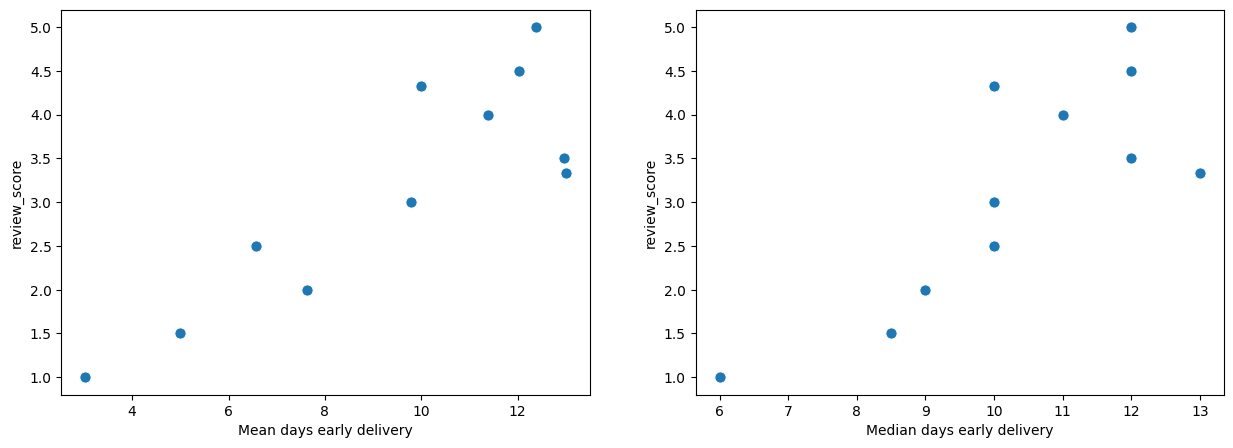

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


sns.scatterplot(data=review_stats, x='mean', y='review_score',
                ax=axes[0], s=65)
axes[0].set_xlabel("Mean days early delivery")

sns.scatterplot(data=review_stats, x='median', y='review_score',
                ax=axes[1], s=65)
axes[1].set_xlabel("Median days early delivery")

In [ ]:
def order_id_stats2(x: pd.Series):
    """
    This function compute the total delivery time per order.
    We compute the time in days and in seconds for higher resolution
    """
    estimate_to_delivery_days = (x['order_delivered_customer_date'] - x['order_estimated_delivery_date']).dt.days.mean()
    estimate_to_delivery_seconds = (x['order_delivered_customer_date'] - x['order_estimated_delivery_date']).dt.total_seconds().mean()
    review_score = x['review_score'].mean()

    return pd.DataFrame({
            'estimate_to_delivery_seconds': [estimate_to_delivery_seconds],
            'estimate_to_delivery_days': [estimate_to_delivery_days],
            'review_score': [review_score]})

# group by order and compute the delivery statistics
order_stats2 = merged.groupby('order_id').apply(order_id_stats2)
order_stats2.index = order_stats2.index.droplevel(1)

In [ ]:
#order_stats2.value_counts()

In [ ]:
review_stats2 = order_stats2.groupby('review_score')['estimate_to_delivery_days']\
                      .agg(['mean', 'median', 'min', 'max','count'])\
                      .reset_index()

In [ ]:
review_stats2

review_score       mean  median    min    max  count
0       1.000000  -4.030488    -7.0  -69.0  175.0   9315
1       1.500000  -6.000000    -9.5  -17.0   25.0      8
2       2.000000  -8.635460   -10.0  -56.0  188.0   2916
3       2.500000  -7.566667   -11.0  -34.0   41.0     30
4       3.000000 -10.779687   -11.0 -135.0  162.0   7916
5       3.333333 -14.000000   -14.0  -14.0  -14.0      1
6       3.500000 -13.956522   -13.0  -43.0    5.0     23
7       4.000000 -12.379584   -12.0  -75.0  161.0  18868
8       4.333333 -11.000000   -11.0  -11.0  -11.0      1
9       4.500000 -13.037736   -13.0  -34.0    0.0     53
10      5.000000 -13.383435   -13.0 -147.0  155.0  56698

Text(0.5, 0, 'Median days early delivery')

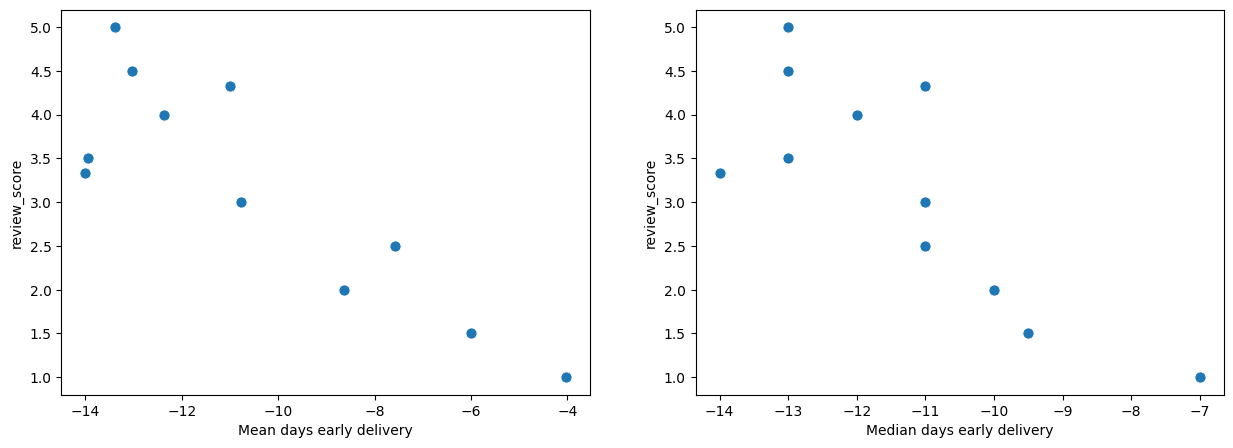

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


sns.scatterplot(data=review_stats2, x='mean', y='review_score',
                ax=axes[0], s=65)
axes[0].set_xlabel("Mean days early delivery")

sns.scatterplot(data=review_stats2, x='median', y='review_score',
                ax=axes[1], s=65)
axes[1].set_xlabel("Median days early delivery")

Beginning to look at shipping costs

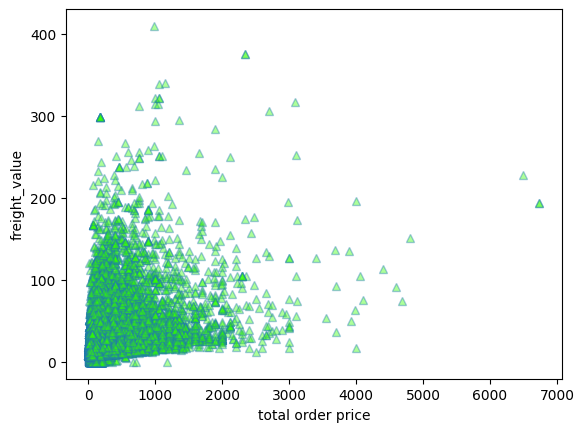

In [ ]:
#plot of the order cost (e.g., sum of item costs) vs. shipping cost(e.g., average of each item assuming same)
#notes: the most expensive order has a cheap shipping cost compared to less-valuable orders
plt.plot(merged.groupby(['order_id','order_item_id'])['price'].mean(), merged.groupby(['order_id','order_item_id'])['freight_value'].mean(), '^', markerfacecolor=(0.2, 1, 0, 0.4))
plt.xlabel(f'total order {merged.columns.to_list()[12]}')
plt.ylabel(f'{merged.columns.to_list()[13]}')
plt.show()

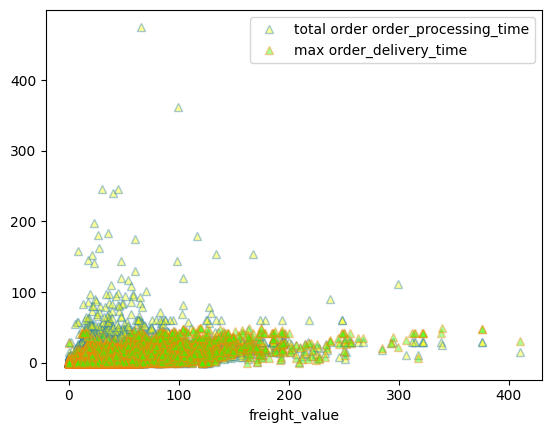

In [ ]:
#calculate weight in kg's
merged['product_weight_kg'] = merged['product_weight_g'] / 1000
#calculate cubic to volumetric weight in kg's = length x width x height / 6000; this is a shipping standard, higher of physical weight or this used to culaculate
#shipping cost; olist customers pay shipping for orders < R$79; olist covers upto 50% of shipping, seller rest, for orders > R$79; % depends on seller index
merged['product_cubevol_weight_kg'] = (merged['product_height_cm'] * merged['product_length_cm'] * merged['product_width_cm']) / 6000
plt.plot(merged.groupby('order_id')['freight_value'].mean(), merged.groupby('order_id')['product_weight_kg'].sum(), '^', markerfacecolor=(1, 1, 0, 0.4), label = f'total order {merged.columns.to_list()[63]}')
plt.plot(merged.groupby('order_id')['freight_value'].mean(), merged.groupby('order_id')['product_cubevol_weight_kg'].max(), '^', markerfacecolor=(0.2, 1, 0, 0.4), label = f'max {merged.columns.to_list()[64]}')
plt.legend()
plt.xlabel(f'{merged.columns.to_list()[13]}')
plt.show()

In [ ]:
merged['product_length_cm'].isnull().value_counts()

product_length_cm
False    118287
True         20
Name: count, dtype: int64

In [ ]:
#check if any of the weight fields are null
#p1 = merged['product_weight_kg'].isnull()
#merged[p1]

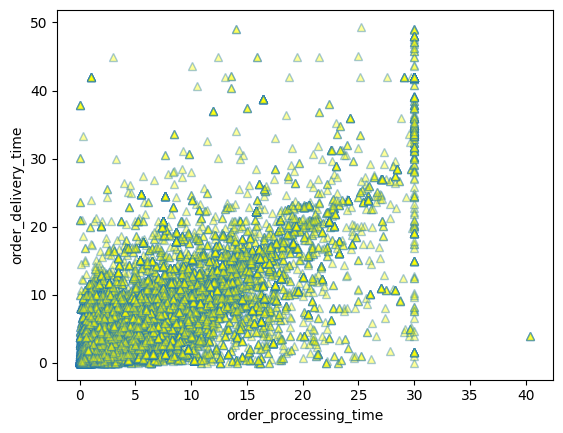

In [ ]:
plt.plot(merged['product_weight_kg'], merged['product_cubevol_weight_kg'], '^', markerfacecolor=(1, 1, 0, 0.4))
plt.xlabel(f'{merged.columns.to_list()[63]}')
plt.ylabel(f'{merged.columns.to_list()[64]}')
plt.show()

In [ ]:
merged[merged['product_weight_kg']>30]

order_id                       customer_id  \
34731   4a45f9f66971302cf881ecfa142f42ba  ccd6a4af78390b7ae560c1cc1cb1a2ff   
95990   6ecf1a4051b4c5ed613624b460970a26  958279c23050d6207d196c3057648f6f   
107343  9223919b300f6989e1715333fca0d6ce  51934b734e94e61d8efa4523e175c6c3   

       order_status order_purchase_timestamp    order_approved_at  \
34731     delivered      2017-12-23 19:03:24  2017-12-23 19:13:20   
95990     delivered      2017-11-17 08:40:57  2017-11-17 08:55:48   
107343    delivered      2018-03-01 23:05:31  2018-03-01 23:15:32   

       order_delivered_carrier_date order_delivered_customer_date  \
34731           2017-12-28 15:13:58           2018-01-25 22:17:15   
95990           2017-11-17 20:36:56           2017-12-01 12:08:23   
107343          2018-03-02 22:33:58           2018-03-27 20:47:27   

       order_estimated_delivery_date  order_item_id  \
34731            2018-01-29 00:00:00            1.0   
95990            2017-12-06 00:00:00            1.0   
107343           2018-03-26 00:00:00            1.0   

                              product_id                         seller_id  \
34731   26644690fde745fc4654719c3904e1db  1835b56ce799e6a4dc4eddc053f04066   
95990   26644690fde745fc4654719c3904e1db  1835b56ce799e6a4dc4eddc053f04066   
107343  26644690fde745fc4654719c3904e1db  1835b56ce799e6a4dc4eddc053f04066   

        shipping_limit_date  price  freight_value  \
34731   2017-12-29 19:13:20   80.0          16.32   
95990   2017-11-23 08:55:48   80.0          12.06   
107343  2018-03-07 23:15:32   80.0          16.32   

                      customer_unique_id customer_zip_code_prefix  \
34731   32d0420a22921ea161d8bff0e0297b71                    88820   
95990   de00290d2a997f24e1706fdc2d366a0e                    11730   
107343  4fbb5c68b6851f6e35c543f963b43e4c                    86455   

         customer_city customer_state  seller_zip_code_prefix seller_city  \
34731            icara             SC                   14940    ibitinga   
95990         mongagua             SP                   14940    ibitinga   
107343  joaquim tavora             PR                   14940    ibitinga   

       seller_state product_category_name  product_name_lenght  \
34731            SP       cama_mesa_banho                 59.0   
95990            SP       cama_mesa_banho                 59.0   
107343           SP       cama_mesa_banho                 59.0   

        product_description_lenght  product_photos_qty  product_weight_g  \
34731                        534.0                 1.0           40425.0   
95990                        534.0                 1.0           40425.0   
107343                       534.0                 1.0           40425.0   

        product_length_cm  product_height_cm  product_width_cm  \
34731                13.0               65.0              28.0   
95990                13.0               65.0              28.0   
107343               13.0               65.0              28.0   

       product_category_name_english  payment_sequential payment_type  \
34731                 bed_bath_table                 1.0  credit_card   
95990                 bed_bath_table                 1.0  credit_card   
107343                bed_bath_table                 1.0  credit_card   

        payment_installments  payment_value                         review_id  \
34731                    1.0          96.32  62a35e9e362cf9b27b9ee8e047afbedf   
95990                    2.0          92.06  13fe815dc5c4076ab42f34545df82ca1   
107343                   1.0          96.32  1474903cd02494e327de0317af95d846   

        review_score review_comment_title review_comment_message  \
34731            1.0                 None                   None   
95990            5.0                 None                   None   
107343           5.0                 None                   None   

       review_creation_date review_answer_timestamp mql_id sdr_id sr_id  \
34731   2018-01-26 00:00:00    

In [ ]:
#any orders with free shipping?
#merged[merged['freight_value'] == 0]

In [ ]:
#looking at a particular seller
#merged[merged['seller_id'] == '8e6d7754bc7e0f22c96d255ebda59eba'].head(50)

In [ ]:
#an order with 20 units (order_item_id = [1,...,20]) of the same product
#merged[merged['order_id'] == '1b15974a0141d54e36626dca3fdc731a']

In [ ]:
#an order with three items with 21 payments per item --> 63 transactions
#merged[merged['order_id'] == '895ab968e7bb0d5659d16cd74cd1650c'].head(50)

In [ ]:
#merged[merged['order_id'] == '895ab968e7bb0d5659d16cd74cd1650c']['order_item_id'].max()

In [ ]:
#merged[merged['order_id'] == '895ab968e7bb0d5659d16cd74cd1650c'].groupby('payment_sequential')['payment_value'].sum()

In [ ]:
#understanding how many order_id's appear more than once, but why? more than 1 item, more than 1 payment
merged['order_id'].value_counts()

order_id
895ab968e7bb0d5659d16cd74cd1650c    63
fedcd9f7ccdc8cba3a18defedd1a5547    38
fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
68986e4324f6a21481df4e6e89abcf01    24
                                    ..
45f515769238adec68b3ed763acbc3b2     1
7cb8c91adbd919548af46374c1c03c0e     1
4cddfa3db1f20697139ba4a46c4fd399     1
a2b3e75e2e444a9ce134788d66d5dec1     1
66dea50a8b16d9b4dee7af250b4be1a5     1
Name: count, Length: 98665, dtype: int64

In [ ]:
#an order with 21 items, 20 units of the same and 1 more; the order with most items
#merged[merged['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

In [ ]:
#the orders with the heaviest product, 3 different orders, same product
#merged[merged['product_weight_kg'] == merged['product_weight_kg'].max()]

In [ ]:
view = merged.groupby('order_id', as_index = False)[['review_score','late_orders','order_delivery_time','order_processing_time']].mean()
view

order_id  review_score  late_orders  \
0      00010242fe8c5a6d1ba2dd792cb16214           5.0          0.0   
1      00018f77f2f0320c557190d7a144bdd3           4.0          0.0   
2      000229ec398224ef6ca0657da4fc703e           5.0          0.0   
3      00024acbcdf0a6daa1e931b038114c75           4.0          0.0   
4      00042b26cf59d7ce69dfabb4e55b4fd9           5.0          0.0   
...                                 ...           ...          ...   
98660  fffc94f6ce00a00581880bf54a75a037           5.0          0.0   
98661  fffcd46ef2263f404302a634eb57f7eb           5.0          0.0   
98662  fffce4705a9662cd70adb13d4a31832d           5.0          0.0   
98663  fffe18544ffabc95dfada21779c9644f           5.0          0.0   
98664  fffe41c64501cc87c801fd61db3f6244           5.0          0.0   

       order_delivery_time  order_processing_time  
0                     -9.0                    0.0  
1                     -3.0                    0.0  
2                    -14.0                    0.0  
3                     -6.0                    0.0  
4                    -16.0                    0.0  
...                    ...                    ...  
98660                 -8.0                    1.0  
98661                 -9.0                    2.0  
98662                -13.0                    1.0  
98663                 -9.0                    0.0  
98664                -14.0                    0.0  

[98665 rows x 5 columns]

In [ ]:
view.groupby('review_score')['order_delivery_time'].mean()

review_score
1.000000    -4.030488
1.500000    -6.000000
2.000000    -8.635460
2.500000    -7.566667
3.000000   -10.779687
3.333333   -14.000000
3.500000   -13.956522
4.000000   -12.379584
4.333333   -11.000000
4.500000   -13.037736
5.000000   -13.383435
Name: order_delivery_time, dtype: float64

In [ ]:
view['late_orders'].value_counts()

late_orders
0.0    92131
1.0     6534
Name: count, dtype: int64

In [ ]:
view['review_score'].value_counts()

review_score
5.000000    56885
4.000000    18986
1.000000    10777
3.000000     8083
2.000000     3063
4.500000       54
2.500000       33
3.500000       25
1.500000        8
3.333333        1
4.333333        1
Name: count, dtype: int64

<ipython-input-131-f268b71f793f>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = view, x = 'order_delivery_time', hue = 'review_score')


<Axes: xlabel='order_delivery_time', ylabel='Density'>

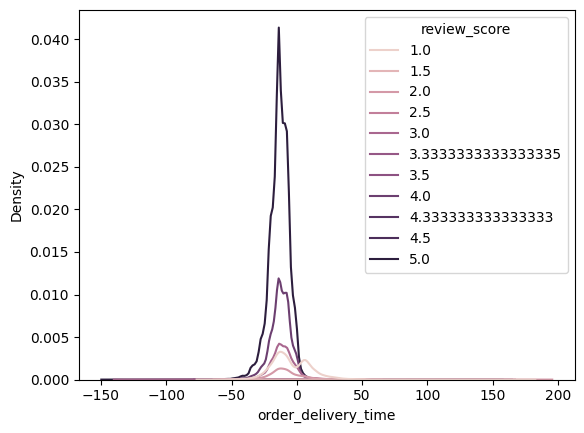

In [ ]:
sns.kdeplot(data = view, x = 'order_delivery_time', hue = 'review_score')

<ipython-input-132-1a3dad62f8c1>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = view, x = 'late_orders', hue = 'review_score')


<Axes: xlabel='late_orders', ylabel='Density'>

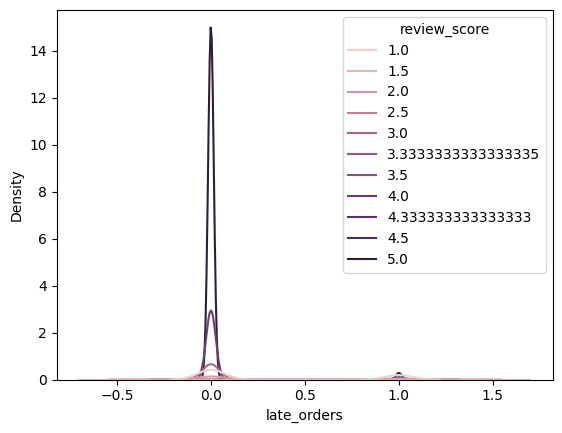

In [ ]:
sns.kdeplot(data = view, x = 'late_orders', hue = 'review_score')

csat (customer satisfaction score)--only responses of 4 'satisfied' and 5 'very satisfied' are included

In [ ]:
#flag reviews > 4 with 1 and less with 0
view['satisfied'] = (view['review_score'] > 4).astype('int')

<Axes: xlabel='late_orders', ylabel='Density'>

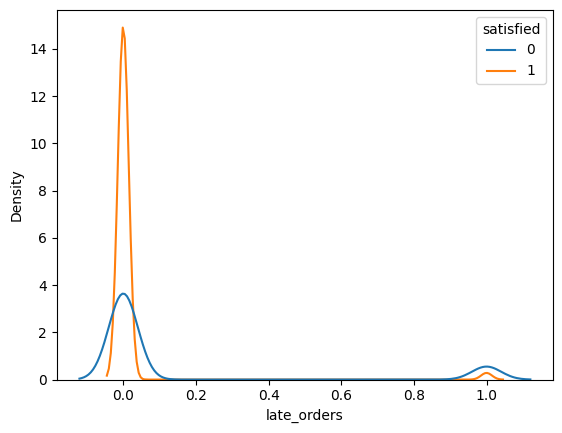

In [ ]:
sns.kdeplot(data = view, x = 'late_orders', hue = 'satisfied')

<Axes: xlabel='order_delivery_time', ylabel='Density'>

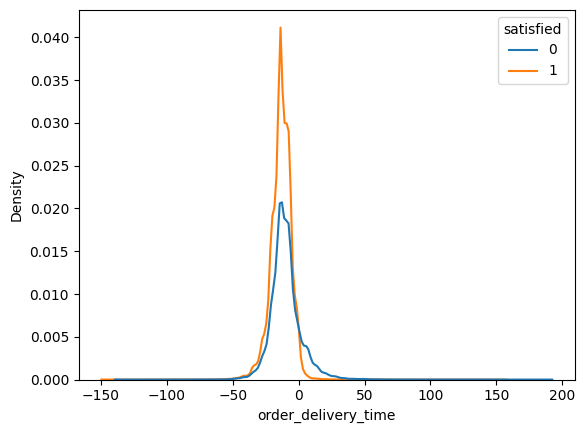

In [ ]:
sns.kdeplot(data = view, x = 'order_delivery_time', hue = 'satisfied')

In [ ]:
view.groupby('satisfied')['order_delivery_time'].agg(['min','mean','median','max'])

min       mean  median    max
satisfied                                 
0         -135.0  -9.726204   -11.0  188.0
1         -147.0 -13.383070   -13.0  155.0

In [ ]:
#view.groupby('satisfied')['order_processing_time'].value_counts()

(0.0, 20.0)

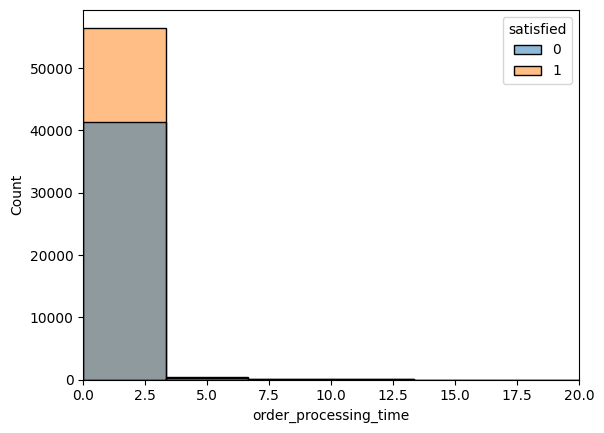

In [ ]:
viewp = sns.histplot(data = view, x = 'order_processing_time', hue = 'satisfied')
viewp.set_xlim(0,20)

In [ ]:
from ydata_profiling import ProfileReport
#report = ProfileReport(merge_reviews, orange_mode = True, minimal = True)

In [ ]:
#report.to_notebook_iframe()